# Initialization

Be sure to run the following notebook first before running this notebook:
- 1-load-and-convert-statsbomb-data.ipynb

In [ ]:
!pip install socceraction
!pip install matplotsoccer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 86 kB 3.7 MB/s 
     |████████████████████████████████| 197 kB 18.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for matplotsoccer: filename=matplotsoccer-0.0.8-py3-none-any.whl size=5984 sha256=1eaa74d88d7ab9dc25e8b9256f491aad5d3bba3af7e7d86ad223d61b3fb0789f
  Stored in directory: /root/.cache/pip/wheels/be/6f/64/335f5a5e7763b284f2f7d8893f20338de4d9f73794fe85ea7d
Successfully built matplotsoccer


In [ ]:
import os
import tqdm
import pandas as pd
import numpy as np
import matplotsoccer

In [ ]:
%load_ext autoreload
%autoreload 2
import socceraction.spadl as spadl
import socceraction.vaep.features as fs
import socceraction.xthreat as xthreat

## Select data

In [ ]:
# Configure file and folder names, use SPADL format.
from google.colab import drive
drive.mount('/content/gdrive')
# %cd '/content/gdrive/My Drive/INFO4001/socceraction/data'
datafolder = "/content/gdrive/My Drive/Friends of Tracking/"

Mounted at /content/gdrive


In [ ]:
spadl_h5 = os.path.join(datafolder, "spadl.h5")
xT_h5 = os.path.join(datafolder, "xT.h5")
predictions_h5 = os.path.join(datafolder, "predictions.h5")

In [ ]:
games = pd.read_hdf(spadl_h5, "games")
print("nb of games:", len(games))

nb of games: 380


In [ ]:
## Read in all actions of games
A = []

for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadl_h5, f"actions/game_{game.game_id}")
    # create_df_actions(actions)
    actions['original_event_id'] = actions['action_id'] = actions.index
    actions = spadl.add_names(actions)
    actions = spadl.play_left_to_right(actions, game.home_team_id)
    A.append(actions) 

A = pd.concat(A)

100%|██████████| 380/380 [00:16<00:00, 22.70it/s]


In [ ]:
A['game_id']=A['game_id'].astype(int)
A['period_id']=A['period_id'].astype(int)
A['team_id']=A['team_id'].astype(int)
A['player_id']=A['player_id'].astype(int)

In [ ]:
A

game_id  period_id  time_seconds  team_id  player_id  start_x  start_y  \
0     2500089          1      2.763597     1659       9637    52.50    34.00   
1     2500089          1      4.761353     1659       8351    42.00    37.40   
2     2500089          1      5.533097     1659       9285    40.95    57.80   
3     2500089          1      7.707561     1659     239411    32.55    47.60   
4     2500089          1     11.614943     1659       9637    69.30    48.96   
...       ...        ...           ...      ...        ...      ...      ...   
1283  2499719          2   2990.768201     1631       8653    11.55    21.76   
1284  2499719          2   2992.491575     1631       8480     7.35    31.96   
1285  2499719          2   2994.900590     1609      49876    56.70    33.32   
1286  2499719          2   2997.086392     1609       7870    76.65    28.56   
1287  2499719          2   3006.647279     1631       8480     5.00    34.00   

       end_x  end_y  bodypart_id  type_id  result_id  original_event_id  \
0      42.00  37.40            0        0          1                  0   
1      40.95  57.80            0        0          1                  1   
2      32.55  47.60            0        0          1                  2   
3      69.30  48.96            0        0          1                  3   
4      74.55  55.76            0        0          1                  4   
...      ...    ...          ...      ...        ...                ...   
1283    7.35  31.96            0        0          1               1283   
1284   48.30  34.68            0        0          0               1284   
1285   76.65  28.56            1        0          1               1285   
1286  105.00  27.20            0       11          0               1286   
1287  105.00   0.00            0       22          0               1287   

      action_id type_name result_name bodypart_name  
0             0      pass     success          foot  
1             1      pass     success          foot  
2             2      pass     success          foot  
3             3      pass     success          foot  
4             4      pass     success          foot  
...         ...       ...         ...           ...  
1283       1283      pass     success          foot  
1284       1284      pass        fail          foot  
1285       1285      pass     success          head  
1286       1286      shot        fail          foot  
1287       1287  goalkick        fail          foot  

[483665 rows x 17 columns]

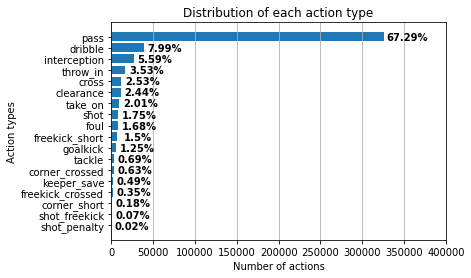

In [ ]:
import matplotlib.pyplot as plt
type,number = np.unique(A['type_name'],return_counts=True)
count_sort_ind = np.argsort(-number)[::-1]

percentage = []
for i in range(len(number)):
    pct = (number[count_sort_ind][i] / number.sum()) * 100
    percentage.append(round(pct,2))


graph = plt.barh(type[count_sort_ind],number[count_sort_ind])
 # Add label names to each axis
plt.xlabel("Number of actions")
plt.ylabel("Action types")
plt.xlim(0,400000)
plt.grid(b=None, which='major', axis='x', )
# Add title to the diagram
plt.title("Distribution of each action type")

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width*1.01+25000,
             y+height/2-0.3,
             str(percentage[i])+'%',
             ha='center',
             weight='bold')
    i+=1

plt.show()

# xT

## Load pre-trained model

In [ ]:
# If you get an SSLError
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

url_grid = "https://karun.in/blog/data/open_xt_12x8_v1.json"
xT_model = xthreat.load_model(url_grid)

## Train a custom model

In [ ]:
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(A);

# iterations:  29


In [ ]:
# A[A['type_name']=='shot']

## Compute xT ratings

In [ ]:
## Predict

# xT should only be used to value actions that move the ball 
# and also keep the current team in possession of the ball
mov_actions = xthreat.get_successful_move_actions(A)
mov_actions["xT_value"] = xTModel.rate(mov_actions.reset_index())
mov_actions[["type_name", "start_x", "start_y", "end_x", "end_y", "xT_value"]][:10]

type_name  start_x  start_y  end_x  end_y  xT_value
0       pass    52.50    34.00  42.00  37.40 -0.002848
1       pass    42.00    37.40  40.95  57.80 -0.001401
2       pass    40.95    57.80  32.55  47.60 -0.001135
3       pass    32.55    47.60  69.30  48.96  0.008513
4       pass    69.30    48.96  74.55  55.76  0.003371
5       pass    74.55    55.76  95.55  63.24  0.003231
11      pass    68.25    46.24  65.10  19.72 -0.002037
12      pass    65.10    19.72  65.10   4.76 -0.002799
13      pass    65.10     4.76  72.45   9.52  0.006892
14      pass    72.45     9.52  47.25  11.56 -0.007546

In [ ]:
mov_actions

game_id  period_id  time_seconds  team_id  player_id  start_x  start_y  \
0     2500089          1      2.763597     1659       9637    52.50    34.00   
1     2500089          1      4.761353     1659       8351    42.00    37.40   
2     2500089          1      5.533097     1659       9285    40.95    57.80   
3     2500089          1      7.707561     1659     239411    32.55    47.60   
4     2500089          1     11.614943     1659       9637    69.30    48.96   
...       ...        ...           ...      ...        ...      ...      ...   
1272  2499719          2   2896.829177     1631     217078    73.50    44.88   
1275  2499719          2   2902.704275     1631     149019    67.20     8.16   
1280  2499719          2   2985.152095     1631       8488    21.00    15.64   
1283  2499719          2   2990.768201     1631       8653    11.55    21.76   
1285  2499719          2   2994.900590     1609      49876    56.70    33.32   

      end_x  end_y  bodypart_id  type_id  result_id  original_event_id  \
0     42.00  37.40            0        0          1                  0   
1     40.95  57.80            0        0          1                  1   
2     32.55  47.60            0        0          1                  2   
3     69.30  48.96            0        0          1                  3   
4     74.55  55.76            0        0          1                  4   
...     ...    ...          ...      ...        ...                ...   
1272  78.75  39.44            0       21          1               1272   
1275  71.40   0.00            0        0          1               1275   
1280  26.25  19.04            1        0          1               1280   
1283   7.35  31.96            0        0          1               1283   
1285  76.65  28.56            1        0          1               1285   

      action_id type_name result_name bodypart_name  xT_value  
0             0      pass     success          foot -0.002848  
1             1      pass     success          foot -0.001401  
2             2      pass     success          foot -0.001135  
3             3      pass     success          foot  0.008513  
4             4      pass     success          foot  0.003371  
...         ...       ...         ...           ...       ...  
1272       1272   dribble     success          foot  0.013995  
1275       1275      pass     success          foot -0.001209  
1280       1280      pass     success          head  0.001517  
1283       1283      pass     success          foot  0.001169  
1285       1285      pass     success          head  0.008528  

[312053 rows x 18 columns]

In [ ]:
# mov_actions = mov_actions.sort_values(['game_id', 'period_id', 'time_seconds']).reset_index(drop=True)
mov_actions[:10]

game_id  period_id  time_seconds  team_id  player_id  start_x  start_y  \
0   2500089          1      2.763597     1659       9637    52.50    34.00   
1   2500089          1      4.761353     1659       8351    42.00    37.40   
2   2500089          1      5.533097     1659       9285    40.95    57.80   
3   2500089          1      7.707561     1659     239411    32.55    47.60   
4   2500089          1     11.614943     1659       9637    69.30    48.96   
5   2500089          1     15.373673     1659     245813    74.55    55.76   
11  2500089          1     50.500582     1659     259531    68.25    46.24   
12  2500089          1     53.100921     1659       9277    65.10    19.72   
13  2500089          1     55.599638     1659      62224    65.10     4.76   
14  2500089          1     56.291411     1659       9739    72.45     9.52   

    end_x  end_y  bodypart_id  type_id  result_id  original_event_id  \
0   42.00  37.40            0        0          1                  0   
1   40.95  57.80            0        0          1                  1   
2   32.55  47.60            0        0          1                  2   
3   69.30  48.96            0        0          1                  3   
4   74.55  55.76            0        0          1                  4   
5   95.55  63.24            0        0          1                  5   
11  65.10  19.72            0        0          1                 11   
12  65.10   4.76            0        0          1                 12   
13  72.45   9.52            0        0          1                 13   
14  47.25  11.56            0        0          1                 14   

    action_id type_name result_name bodypart_name  xT_value  
0           0      pass     success          foot -0.002848  
1           1      pass     success          foot -0.001401  
2           2      pass     success          foot -0.001135  
3           3      pass     success          foot  0.008513  
4           4      pass     success          foot  0.003371  
5           5      pass     success          foot  0.003231  
11         11      pass     success          foot -0.002037  
12         12      pass     success          foot -0.002799  
13         13      pass     success          foot  0.006892  
14         14      pass     success          foot -0.007546

In [ ]:
# merge with A
A = A.merge(mov_actions[['xT_value','game_id','action_id']], left_on=['game_id','action_id'], right_on = ['game_id','action_id'], how='left')

In [ ]:
A

game_id  period_id  time_seconds  team_id  player_id  start_x  \
0       2500089          1      2.763597     1659       9637    52.50   
1       2500089          1      4.761353     1659       8351    42.00   
2       2500089          1      5.533097     1659       9285    40.95   
3       2500089          1      7.707561     1659     239411    32.55   
4       2500089          1     11.614943     1659       9637    69.30   
...         ...        ...           ...      ...        ...      ...   
483660  2499719          2   2990.768201     1631       8653    11.55   
483661  2499719          2   2992.491575     1631       8480     7.35   
483662  2499719          2   2994.900590     1609      49876    56.70   
483663  2499719          2   2997.086392     1609       7870    76.65   
483664  2499719          2   3006.647279     1631       8480     5.00   

        start_y   end_x  end_y  bodypart_id  type_id  result_id  \
0         34.00   42.00  37.40            0        0          1   
1         37.40   40.95  57.80            0        0          1   
2         57.80   32.55  47.60            0        0          1   
3         47.60   69.30  48.96            0        0          1   
4         48.96   74.55  55.76            0        0          1   
...         ...     ...    ...          ...      ...        ...   
483660    21.76    7.35  31.96            0        0          1   
483661    31.96   48.30  34.68            0        0          0   
483662    33.32   76.65  28.56            1        0          1   
483663    28.56  105.00  27.20            0       11          0   
483664    34.00  105.00   0.00            0       22          0   

        original_event_id  action_id type_name result_name bodypart_name  \
0                       0          0      pass     success          foot   
1                       1          1      pass     success          foot   
2                       2          2      pass     success          foot   
3                       3          3      pass     success          foot   
4                       4          4      pass     success          foot   
...                   ...        ...       ...         ...           ...   
483660               1283       1283      pass     success          foot   
483661               1284       1284      pass        fail          foot   
483662               1285       1285      pass     success          head   
483663               1286       1286      shot        fail          foot   
483664               1287       1287  goalkick        fail          foot   

        xT_value  
0      -0.002848  
1      -0.001401  
2      -0.001135  
3       0.008513  
4       0.003371  
...          ...  
483660  0.001169  
483661       NaN  
483662  0.008528  
483663       NaN  
483664       NaN  

[483665 rows x 18 columns]

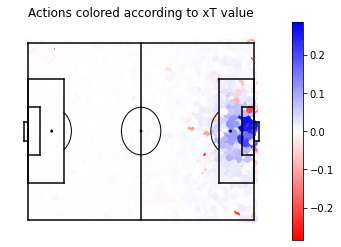

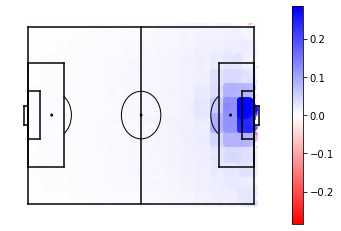

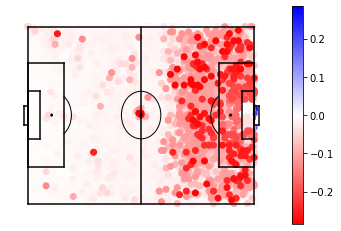

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 
a = mov_actions

# Show scatterplot of actions colored according to xT value
mps.field(show=False)
plt.title("Actions colored according to xT value")
plt.scatter(a.end_x, a.end_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with high xT Values on top
a = a.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(a.end_x, a.end_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with low xT Values on top
a = a.sort_values("xT_value", ascending=False)
mps.field(show=False)
plt.scatter(a.end_x, a.end_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

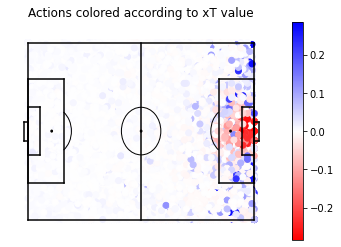

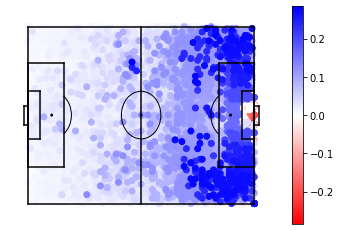

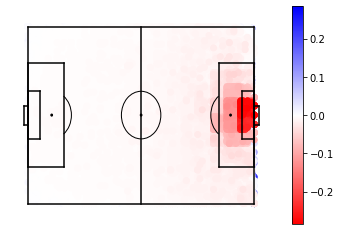

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 
a = mov_actions

# Show scatterplot of actions colored according to xT value
mps.field(show=False)
plt.title("Actions colored according to xT value")
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with high xT Values on top
a = a.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with low xT Values on top
a = a.sort_values("xT_value", ascending=False)
mps.field(show=False)
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

In [ ]:
A

game_id  period_id  time_seconds  team_id  player_id  start_x  \
0       2500089          1      2.763597     1659       9637    52.50   
1       2500089          1      4.761353     1659       8351    42.00   
2       2500089          1      5.533097     1659       9285    40.95   
3       2500089          1      7.707561     1659     239411    32.55   
4       2500089          1     11.614943     1659       9637    69.30   
...         ...        ...           ...      ...        ...      ...   
483660  2499719          2   2990.768201     1631       8653    11.55   
483661  2499719          2   2992.491575     1631       8480     7.35   
483662  2499719          2   2994.900590     1609      49876    56.70   
483663  2499719          2   2997.086392     1609       7870    76.65   
483664  2499719          2   3006.647279     1631       8480     5.00   

        start_y   end_x  end_y  bodypart_id  type_id  result_id  \
0         34.00   42.00  37.40            0        0          1   
1         37.40   40.95  57.80            0        0          1   
2         57.80   32.55  47.60            0        0          1   
3         47.60   69.30  48.96            0        0          1   
4         48.96   74.55  55.76            0        0          1   
...         ...     ...    ...          ...      ...        ...   
483660    21.76    7.35  31.96            0        0          1   
483661    31.96   48.30  34.68            0        0          0   
483662    33.32   76.65  28.56            1        0          1   
483663    28.56  105.00  27.20            0       11          0   
483664    34.00  105.00   0.00            0       22          0   

        original_event_id  action_id type_name result_name bodypart_name  \
0                       0          0      pass     success          foot   
1                       1          1      pass     success          foot   
2                       2          2      pass     success          foot   
3                       3          3      pass     success          foot   
4                       4          4      pass     success          foot   
...                   ...        ...       ...         ...           ...   
483660               1283       1283      pass     success          foot   
483661               1284       1284      pass        fail          foot   
483662               1285       1285      pass     success          head   
483663               1286       1286      shot        fail          foot   
483664               1287       1287  goalkick        fail          foot   

        xT_value  
0      -0.002848  
1      -0.001401  
2      -0.001135  
3       0.008513  
4       0.003371  
...          ...  
483660  0.001169  
483661       NaN  
483662  0.008528  
483663       NaN  
483664       NaN  

[483665 rows x 18 columns]

# VAEP

## Value game states

This section generates features and labels for the game states, trains a predictive machine learning model for each label, and values the game states by applying the trained machine learning models.

1. Generate the features to describe the game states;
2. Generate the labels that capture the value of the game states;
3. Compose a dataset by selecting a set of features and the labels of the game states;
4. Train predictive machine learning models using the dataset;
5. Value the game states using the trained predictive machine learning model.

**Note:** The code in this section is based on the [2-compute-features-and-labels.ipynb](https://github.com/ML-KULeuven/socceraction/blob/master/public-notebooks/2-compute-features-and-labels.ipynb) and [3-estimate-scoring-and-conceding-probabilities.ipynb](https://github.com/ML-KULeuven/socceraction/blob/master/public-notebooks/3-estimate-scoring-and-conceding-probabilities.ipynb) notebooks in the `socceraction` repository.

In [ ]:
df_games = pd.read_hdf(spadl_h5, key='games')
df_actiontypes = pd.read_hdf(spadl_h5, key='actiontypes')
df_bodyparts = pd.read_hdf(spadl_h5, key='bodyparts')
df_results = pd.read_hdf(spadl_h5, key='results')

In [ ]:
nb_prev_actions = 3

### Generate game state features

The following cell lists a number of *feature generators* from the `features` module in the `socceraction` library. Each function expects either a `DataFrame` object containing actions (i.e., individual actions) or a list of `DataFrame` objects containing consecutive actions (i.e., game states), and returns the corresponding *feature* for the individual action or game state.

In [ ]:
import warnings
from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile

import pandas as pd
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
from sklearn.metrics import brier_score_loss, roc_auc_score
from socceraction.spadl.wyscout import create_df_actions
from socceraction.vaep.formula import value
from xgboost import XGBClassifier

In [ ]:
functions_features = [
    features.actiontype_onehot,
    features.bodypart_onehot,
    features.result_onehot,
    features.goalscore,
    features.startlocation,
    features.endlocation,
    features.movement,
    features.space_delta,
    features.startpolar,
    features.endpolar,
    features.team,
    features.time_delta
]

The following cell generates game states from consecutive actions in each game and computes the features for each game state.

1. Obtain the actions for the game (i.e., `df_actions`) by looping through the games;
2. Construct game states of a given length from the actions (i.e., `dfs_gamestates`);
3. Compute the features for the constructed game states (i.e., `df_features`) by looping through the list of *feature generators*.

In [ ]:
for _, game in tqdm.tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf(spadl_h5, key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .reset_index(drop=True)
    )
    
    dfs_gamestates = features.gamestates(df_actions, nb_prev_actions=nb_prev_actions)
    dfs_gamestates = features.play_left_to_right(dfs_gamestates, game['home_team_id'])
    
    df_features = pd.concat([function(dfs_gamestates) for function in functions_features], axis=1)
    df_features.to_hdf(os.path.join(datafolder, "features.h5"), key=f'game_{game_id}')

100%|██████████| 380/380 [01:44<00:00,  3.65it/s]


### Generate game state labels

The following cell lists a number of *label generators* from the `labels` module in the `socceraction` library. Each function expects either a `DataFrame` object containing actions (i.e., individual actions) or a list of `DataFrame` objects containing consecutive actions (i.e., game states), and returns the corresponding *label* for the individual action or game state.

In [ ]:
functions_labels = [
    labels.scores,
    labels.concedes
]

The following cell computes the labels for each action:

1. Obtain the actions for the game (i.e., `df_actions`) by looping through the games;
2. Compute the labels for the actions (i.e., `df_labels`) by looping through the list of *label generators*.

In [ ]:
for _, game in tqdm.tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf(spadl_h5, key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .reset_index(drop=True)
    )
    
    df_labels = pd.concat([function(df_actions) for function in functions_labels], axis=1)
    df_labels.to_hdf(os.path.join(datafolder, 'labels.h5'), key=f'game_{game_id}')

100%|██████████| 380/380 [00:51<00:00,  7.31it/s]


In [ ]:
df_actions

game_id  period_id  time_seconds  team_id  player_id  start_x  \
0     2499719.0        1.0      2.758649   1609.0    25413.0    51.45   
1     2499719.0        1.0      4.946850   1609.0   370224.0    32.55   
2     2499719.0        1.0      6.542188   1609.0     3319.0    53.55   
3     2499719.0        1.0      8.143395   1609.0   120339.0    36.75   
4     2499719.0        1.0     10.302366   1609.0   167145.0    43.05   
...         ...        ...           ...      ...        ...      ...   
1283  2499719.0        2.0   2990.768201   1631.0     8653.0    93.45   
1284  2499719.0        2.0   2992.491575   1631.0     8480.0    97.65   
1285  2499719.0        2.0   2994.900590   1609.0    49876.0    56.70   
1286  2499719.0        2.0   2997.086392   1609.0     7870.0    76.65   
1287  2499719.0        2.0   3006.647279   1631.0     8480.0   100.00   

      start_y   end_x  end_y  bodypart_id  type_id  result_id type_name  \
0       34.68   32.55  14.96            0        0          1      pass   
1       14.96   53.55  17.00            0        0          1      pass   
2       17.00   36.75  19.72            1        0          1      pass   
3       19.72   43.05   3.40            1        0          1      pass   
4        3.40   75.60   8.16            0        0          1      pass   
...       ...     ...    ...          ...      ...        ...       ...   
1283    46.24   97.65  36.04            0        0          1      pass   
1284    36.04   56.70  33.32            0        0          0      pass   
1285    33.32   76.65  28.56            1        0          1      pass   
1286    28.56  105.00  27.20            0       11          0      shot   
1287    34.00    0.00  68.00            0       22          0  goalkick   

     result_name bodypart_name  
0        success          foot  
1        success          foot  
2        success          head  
3        success          head  
4        success          foot  
...          ...           ...  
1283     success          foot  
1284        fail          foot  
1285     success          head  
1286        fail          foot  
1287        fail          foot  

[1288 rows x 15 columns]

In [ ]:
df_features

type_pass_a0  type_cross_a0  type_throw_in_a0  type_freekick_crossed_a0  \
0             True          False             False                     False   
1             True          False             False                     False   
2             True          False             False                     False   
3             True          False             False                     False   
4             True          False             False                     False   
...            ...            ...               ...                       ...   
1283          True          False             False                     False   
1284          True          False             False                     False   
1285          True          False             False                     False   
1286         False          False             False                     False   
1287         False          False             False                     False   

      type_freekick_short_a0  type_corner_crossed_a0  type_corner_short_a0  \
0                      False                   False                 False   
1                      False                   False                 False   
2                      False                   False                 False   
3                      False                   False                 False   
4                      False                   False                 False   
...                      ...                     ...                   ...   
1283                   False                   False                 False   
1284                   False                   False                 False   
1285                   False                   False                 False   
1286                   False                   False                 False   
1287                   False                   False                 False   

      type_take_on_a0  type_foul_a0  type_tackle_a0  ...  end_dist_to_goal_a0  \
0               False         False           False  ...            74.910107   
1               False         False           False  ...            54.185815   
2               False         False           False  ...            69.727906   
3               False         False           False  ...            69.095315   
4               False         False           False  ...            39.141610   
...               ...           ...             ...  ...                  ...   
1283            False         False           False  ...            97.671306   
1284            False         False           False  ...            56.704077   
1285            False         False           False  ...            28.867215   
1286            False         False           False  ...             6.800000   
1287            False         False           False  ...            34.000000   

      end_angle_to_goal_a0  end_dist_to_goal_a1  end_angle_to_goal_a1  \
0                 0.256991            74.910107              0.256991   
1                 0.319124            74.910107              0.256991   
2                 0.206255            54.185815              0.319124   
3                 0.458793            69.727906              0.206255   
4                 0.721041            69.095315              0.458793   
...                    ...                  ...                   ...   
1283              0.020888            94.248184              0.130238   
1284              0.011992            97.671306              0.020888   
1285              0.189583            48.304787              0.014078   
1286              1.570796            28.867215              0.189583   
1287              1.570796           105.219960              0.064672   

      end_dist_to_goal_a2  end_angle_to_goal_a2  team_1  team_2  time_delta_1  \
0               74.910107              0.256991    True    True      0.000000   
1               74.910107              0.256991    True    True      2.188201   
2  

### Generate dataset

The following cell generates a list of names for the features to be included in the dataset.

In [ ]:
columns_features = features.feature_column_names(functions_features, nb_prev_actions=nb_prev_actions)

The following cell obtains the relevant features for each game and stores them in the `df_features` `DataFrame` object.

In [ ]:
dfs_features = []
for _, game in tqdm.tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_features = pd.read_hdf(os.path.join(datafolder, "features.h5"), key=f'game_{game_id}')
    dfs_features.append(df_features[columns_features])
df_features = pd.concat(dfs_features).reset_index(drop=True)

100%|██████████| 380/380 [00:05<00:00, 68.77it/s]


In [ ]:
df_features.head(10)

type_pass_a0  type_cross_a0  type_throw_in_a0  type_freekick_crossed_a0  \
0          True          False             False                     False   
1          True          False             False                     False   
2          True          False             False                     False   
3          True          False             False                     False   
4          True          False             False                     False   
5          True          False             False                     False   
6         False           True             False                     False   
7         False          False             False                     False   
8         False           True             False                     False   
9         False          False             False                     False   

   type_freekick_short_a0  type_corner_crossed_a0  type_corner_short_a0  \
0                   False                   False                 False   
1                   False                   False                 False   
2                   False                   False                 False   
3                   False                   False                 False   
4                   False                   False                 False   
5                   False                   False                 False   
6                   False                   False                 False   
7                   False                   False                 False   
8                   False                   False                 False   
9                   False                   False                 False   

   type_take_on_a0  type_foul_a0  type_tackle_a0  ...  end_dist_to_goal_a0  \
0            False         False           False  ...            63.091679   
1            False         False           False  ...            68.328929   
2            False         False           False  ...            73.715416   
3            False         False           False  ...            38.707772   
4            False         False           False  ...            37.425928   
5            False         False           False  ...            30.729141   
6            False         False           False  ...             8.400000   
7            False         False           False  ...           106.094842   
8            False         False           False  ...            25.925192   
9            False         False           False  ...            89.647658   

   end_angle_to_goal_a0  end_dist_to_goal_a1  end_angle_to_goal_a1  \
0              0.053916            63.091679              0.053916   
1              0.355773            63.091679              0.053916   
2              0.185556            68.328929              0.355773   
3              0.396818            73.715416              0.185556   
4              0.620467            38.707772              0.396818   
5              1.258205            37.425928              0.620467   
6              0.000000            30.729141              1.258205   
7              0.246030            96.600000              0.000000   
8              1.489705            25.925192              1.489705   
9              0.388999           106.094842              0.246030   

   end_dist_to_goal_a2  end_angle_to_goal_a2  team_1  team_2  time_delta_1  \
0            63.091679              0.053916    True    True      0.000000   
1            63.091679              0.053916    True    True      1.997756   
2            63.091679              0.053916    True    True      0.771744   
3            68.328929              0.355773    True    True      2.174464   
4            73.715416              0.185556    True    True      3.907382   
5            38.707772              0.396818    True    True      3.758730   
6            37.425928              0.620467    True    True      2.210584   
7            99.923872              0.296969   False   False    

The following cell lists the names of the labels to be included in the dataset.

In [ ]:
columns_labels = [
    'scores',
    'concedes'
]

The following cell obtains the relevant labels for each game and stores them in the `df_labels` `DataFrame` object.

In [ ]:
dfs_labels = []
for _, game in tqdm.tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_labels = pd.read_hdf(os.path.join(datafolder, 'labels.h5'), key=f'game_{game_id}')
    dfs_labels.append(df_labels[columns_labels])
df_labels = pd.concat(dfs_labels).reset_index(drop=True)

100%|██████████| 380/380 [00:03<00:00, 119.59it/s]


In [ ]:
df_labels.head(10)

scores  concedes
0   False     False
1   False     False
2   False     False
3   False     False
4   False     False
5   False     False
6   False     False
7   False     False
8   False     False
9   False     False

### Train classifiers

The following cell trains an XGBoost classifier for each label using the computed features. For each label:
1. Construct an XGBoost classifier with default hyperparameters;
2. Train the classifier using the computed features and the label;
3. Store the trained classifier in the `models` `dict`.

In [ ]:
df_features

type_pass_a0  type_cross_a0  type_throw_in_a0  \
0               True          False             False   
1               True          False             False   
2               True          False             False   
3               True          False             False   
4               True          False             False   
...              ...            ...               ...   
483660          True          False             False   
483661          True          False             False   
483662          True          False             False   
483663         False          False             False   
483664         False          False             False   

        type_freekick_crossed_a0  type_freekick_short_a0  \
0                          False                   False   
1                          False                   False   
2                          False                   False   
3                          False                   False   
4                          False                   False   
...                          ...                     ...   
483660                     False                   False   
483661                     False                   False   
483662                     False                   False   
483663                     False                   False   
483664                     False                   False   

        type_corner_crossed_a0  type_corner_short_a0  type_take_on_a0  \
0                        False                 False            False   
1                        False                 False            False   
2                        False                 False            False   
3                        False                 False            False   
4                        False                 False            False   
...                        ...                   ...              ...   
483660                   False                 False            False   
483661                   False                 False            False   
483662                   False                 False            False   
483663                   False                 False            False   
483664                   False                 False            False   

        type_foul_a0  type_tackle_a0  ...  end_dist_to_goal_a0  \
0              False           False  ...            63.091679   
1              False           False  ...            68.328929   
2              False           False  ...            73.715416   
3              False           False  ...            38.707772   
4              False           False  ...            37.425928   
...              ...             ...  ...                  ...   
483660         False           False  ...            97.671306   
483661         False           False  ...            56.704077   
483662         False           False  ...            28.867215   
483663         False           False  ...             6.800000   
483664         False           False  ...            34.000000   

        end_angle_to_goal_a0  end_dist_to_goal_a1  end_angle_to_goal_a1  \
0                   0.053916            63.091679              0.053916   
1                   0.355773            63.091679              0.053916   
2                   0.185556            68.328929              0.355773   
3                   0.396818            73.715416              0.185556   
4                   0.620467            38.707772              0.396818   
...                      ...                  ...                   ...   
483660              0.020888            94.248184              0.130238   
483661              0.011992            97.671306              0.020888   
483662              0.189583            48.304787              0.014078   
483663              1.570796            28.867215              0.189583   
483664              1.570796           105.219960              0.064672   

        end_dist_to_goal_a2  en

In [ ]:
df_labels

scores  concedes
0        False     False
1        False     False
2        False     False
3        False     False
4        False     False
...        ...       ...
483660   False     False
483661   False     False
483662   False     False
483663   False     False
483664   False     False

[483665 rows x 2 columns]

In [ ]:
%%time
models = {}
for column_labels in columns_labels:
    model = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False
    )
    model.fit(df_features, df_labels[column_labels])
    models[column_labels] = model

CPU times: user 4min 12s, sys: 637 ms, total: 4min 13s
Wall time: 4min 14s


In [ ]:
model

XGBClassifier(eval_metric='logloss', use_label_encoder=False)

In [ ]:
# import pickle
# with open(os.path.join(datafolder, "VAEP_model"), "wb") as fp:   #Pickling
#   pickle.dump(model, fp)

In [ ]:
import pickle

with open(os.path.join(datafolder, "VAEP_model"), "rb") as fp:   # Unpickling
  VAEP_model = pickle.load(fp)

### Estimate probabilities

The following cell predicts the labels for the game states using the trained XGBoost classifier. For each label:
1. Retrieve the model for the label;
2. Estimate the probabilities of the labels being `False` and `True` given the computed features;
3. Keep the probabilities for the `True` label;
4. Store the probabilities as a `Series` object in the `dfs_predictions` `dict`.

In [ ]:
dfs_predictions = {}
for column_labels in columns_labels:
    model = models[column_labels]
    probabilities = model.predict_proba(df_features)
    predictions = probabilities[:, 1]
    dfs_predictions[column_labels] = pd.Series(predictions)
df_predictions = pd.concat(dfs_predictions, axis=1)

In [ ]:
df_predictions.head(10)

scores  concedes
0  0.007358  0.001960
1  0.006764  0.002133
2  0.006148  0.002158
3  0.012629  0.001944
4  0.014924  0.001562
5  0.018039  0.001620
6  0.012479  0.004233
7  0.003547  0.041633
8  0.013167  0.003292
9  0.002511  0.015838

The following cell obtains the `game_id` for each action in order to store the predictions per game.

In [ ]:
dfs_game_ids = []
for _, game in tqdm.tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf(spadl_h5, key=f'actions/game_{game_id}')
    dfs_game_ids.append(df_actions['game_id'])
df_game_ids = pd.concat(dfs_game_ids, axis=0).astype('int').reset_index(drop=True)

100%|██████████| 380/380 [00:04<00:00, 90.96it/s]


The following cell concatenates the `DataFrame` objects with predictions and `game_id`s for each action into a single `DataFrame` object.

In [ ]:
df_predictions = pd.concat([df_predictions, df_game_ids], axis=1)

In [ ]:
df_predictions.head(10)

scores  concedes  game_id
0  0.007358  0.001960  2500089
1  0.006764  0.002133  2500089
2  0.006148  0.002158  2500089
3  0.012629  0.001944  2500089
4  0.014924  0.001562  2500089
5  0.018039  0.001620  2500089
6  0.012479  0.004233  2500089
7  0.003547  0.041633  2500089
8  0.013167  0.003292  2500089
9  0.002511  0.015838  2500089

The following cell groups the predictions per game based on their `game_id`.

In [ ]:
df_predictions_per_game = df_predictions.groupby('game_id')

The following cell stores the predictions in the `predictions.h5` HDF5 file per game.

In [ ]:
for game_id, df_predictions in tqdm.tqdm(df_predictions_per_game):
    df_predictions = df_predictions.reset_index(drop=True)
    df_predictions[columns_labels].to_hdf('predictions.h5', key=f'game_{game_id}')

100%|██████████| 380/380 [00:03<00:00, 118.21it/s]


## Value on-the-ball actions

**Note:** The code in this section is based on the [4-compute-vaep-values.ipynb](https://github.com/ML-KULeuven/socceraction/blob/master/public-notebooks/4-compute-vaep-values.ipynb) notebook in the `socceraction` repository.

In [ ]:
df_players = pd.read_hdf(spadl_h5, key='players')
df_teams = pd.read_hdf(spadl_h5, key='teams')

In [ ]:
dfs_values = []
for _, game in tqdm.tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf(spadl_h5, key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .merge(df_players, how='left')
        .merge(df_teams, how='left')
        .reset_index(drop=True)
    )
    
    df_predictions = pd.read_hdf(predictions_h5, key=f'game_{game_id}')
    df_values = value(df_actions, df_predictions['scores'], df_predictions['concedes'])
    
    df_all = pd.concat([df_actions, df_predictions, df_values], axis=1)
    dfs_values.append(df_all)

100%|██████████| 380/380 [00:18<00:00, 20.84it/s]


In [ ]:
df_values = (pd.concat(dfs_values)
    .sort_values(['game_id', 'period_id', 'time_seconds'])
    .reset_index(drop=True)
)

In [ ]:
df_values[
    ['short_name', 'scores', 'concedes', 'offensive_value', 'defensive_value', 'vaep_value']
].head(10)

short_name    scores  concedes  offensive_value  defensive_value  \
0    A. Lacazette  0.006478  0.002003         0.000000        -0.000000   
1      R. Holding  0.008359  0.001983         0.001882         0.000021   
2         M. Özil  0.007020  0.001753        -0.001339         0.000230   
3  Mohamed Elneny  0.005954  0.001814        -0.001066        -0.000061   
4        Bellerín  0.013879  0.001725         0.007925         0.000089   
5         M. Özil  0.009308  0.002866        -0.004570        -0.001141   
6      H. Maguire  0.005129  0.002951         0.002263         0.006357   
7        Bellerín  0.012155  0.002068         0.009204         0.003061   
8        Bellerín  0.010885  0.001686        -0.001269         0.000382   
9        G. Xhaka  0.008632  0.001764        -0.002254        -0.000079   

   vaep_value  
0    0.000000  
1    0.001902  
2   -0.001110  
3   -0.001127  
4    0.008014  
5   -0.005711  
6    0.008620  
7    0.012265  
8   -0.000887  
9   -0.002332

## Rate players

### Rate according to total VAEP value

In [ ]:
df_ranking = (df_values[['player_id', 'team_name', 'short_name', 'vaep_value']]
    .groupby(['player_id', 'team_name', 'short_name'])
    .agg(vaep_count=('vaep_value', 'count'), vaep_sum=('vaep_value', 'sum'))
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

In [ ]:
df_ranking.head(10)

player_id             team_name     short_name  vaep_count   vaep_sum
0   120353.0          Liverpool FC  Mohamed Salah        1568  28.457769
1     8717.0  Tottenham Hotspur FC        H. Kane        1153  19.642441
2    38021.0    Manchester City FC   K. De Bruyne        3528  17.931269
3    26150.0     Leicester City FC      R. Mahrez        2022  17.909473
4    25707.0            Chelsea FC      E. Hazard        1974  16.764914
5       54.0  Tottenham Hotspur FC     C. Eriksen        2959  16.701059
6     8317.0    Manchester City FC    David Silva        2925  13.893208
7     8325.0    Manchester City FC      S. Agüero         982  13.748281
8    11066.0    Manchester City FC    R. Sterling        1693  13.698047
9    49872.0         Stoke City FC     X. Shaqiri        1722  13.230244

### Rate according to total VAEP value per 90 minutes

In [ ]:
df_player_games = pd.read_hdf(spadl_h5, 'player_games')
df_player_games = df_player_games[df_player_games['game_id'].isin(df_games['game_id'])]

In [ ]:
df_minutes_played = (df_player_games[['player_id', 'minutes_played']]
    .groupby('player_id')
    .sum()
    .reset_index()
)

In [ ]:
df_minutes_played.head(10)

player_id  minutes_played
0         36     1238.400194
1         38      382.741398
2         48     3344.850202
3         54     3350.424005
4         56      267.266792
5         74     1515.130449
6         93     2941.903193
7        107     2839.106630
8        116     2497.512961
9        120      234.603990

In [ ]:
df_ranking_p90 = df_ranking.merge(df_minutes_played)
df_ranking_p90 = df_ranking_p90[df_ranking_p90['minutes_played'] > 360]
df_ranking_p90['vaep_rating'] = df_ranking_p90['vaep_sum'] * 90 / df_ranking_p90['minutes_played']
df_ranking_p90 = df_ranking_p90.sort_values('vaep_rating', ascending=False)

In [ ]:
df_ranking_p90.head(10)

player_id             team_name         short_name  vaep_count   vaep_sum  \
0    120353.0          Liverpool FC      Mohamed Salah        1568  28.457769   
39     3802.0          Liverpool FC  Philippe Coutinho        1014   8.972772   
7      8325.0    Manchester City FC          S. Agüero         982  13.748281   
4     25707.0            Chelsea FC          E. Hazard        1974  16.764914   
1      8717.0  Tottenham Hotspur FC            H. Kane        1153  19.642441   
3     26150.0     Leicester City FC          R. Mahrez        2022  17.909473   
92    25867.0            Arsenal FC      P. Aubameyang         437   6.348079   
2     38021.0    Manchester City FC       K. De Bruyne        3528  17.931269   
34   134513.0  Manchester United FC         A. Martial        1108   9.212837   
6      8317.0    Manchester City FC        David Silva        2925  13.893208   

    minutes_played  vaep_rating  
0      2996.529579     0.854722  
39     1134.538547     0.711787  
7      2038.785220     0.606903  
4      2505.438518     0.602227  
1      3203.994283     0.551755  
3      3063.065477     0.526222  
92     1097.576549     0.520535  
2      3190.369684     0.505839  
34     1650.191521     0.502460  
6      2519.126467     0.496358

In [ ]:
df_ranking_p90.to_csv('ranking.csv', index=False)

In [ ]:
df_values

game_id  period_id  time_seconds  team_id  player_id  start_x  \
0       2499719.0        1.0      2.758649   1609.0    25413.0    51.45   
1       2499719.0        1.0      4.946850   1609.0   370224.0    32.55   
2       2499719.0        1.0      6.542188   1609.0     3319.0    53.55   
3       2499719.0        1.0      8.143395   1609.0   120339.0    36.75   
4       2499719.0        1.0     10.302366   1609.0   167145.0    43.05   
...           ...        ...           ...      ...        ...      ...   
483660  2500098.0        2.0   2785.702032   1633.0    20620.0    55.65   
483661  2500098.0        2.0   2789.232666   1633.0    14703.0   103.95   
483662  2500098.0        2.0   2790.457942   1623.0     8239.0   102.90   
483663  2500098.0        2.0   2829.821084   1633.0    70965.0   105.00   
483664  2500098.0        2.0   2834.127168   1633.0     8005.0    90.30   

        start_y   end_x  end_y  bodypart_id  ...     first_name  \
0         34.68   32.55  14.96            0  ...      Alexandre   
1         14.96   53.55  17.00            0  ...            Rob   
2         17.00   36.75  19.72            1  ...          Mesut   
3         19.72   43.05   3.40            1  ...  Mohamed Naser   
4          3.40   75.60   8.16            0  ...         Héctor   
...         ...     ...    ...          ...  ...            ...   
483660     7.48  103.95  19.04            0  ...         Pedro    
483661    19.04  103.95  19.04            0  ...          Marko   
483662    21.08  105.00  21.76            0  ...       Leighton   
483663     0.00   92.40  36.04            0  ...     João Mário   
483664    34.00  105.00  27.20            0  ...  James Michael   

                      last_name  birth_date  short_team_name  \
0                     Lacazette  1991-05-28          Arsenal   
1                       Holding  1995-09-20          Arsenal   
2                          Özil  1988-10-15          Arsenal   
3                Elsayed Elneny  1992-07-11          Arsenal   
4               Bellerín Moruno  1995-03-19          Arsenal   
...                         ...         ...              ...   
483660         Mba Obiang Avomo  1992-03-27  West Ham United   
483661               Arnautović  1989-04-19  West Ham United   
483662                   Baines  1984-12-11          Everton   
483663  Naval da Costa Eduardo   1993-01-19  West Ham United   
483664                  Collins  1983-08-23  West Ham United   

                 team_name    scores  concedes offensive_value  \
0               Arsenal FC  0.006478  0.002003        0.000000   
1               Arsenal FC  0.008359  0.001983        0.001882   
2               Arsenal FC  0.007020  0.001753       -0.001339   
3               Arsenal FC  0.005954  0.001814       -0.001066   
4               Arsenal FC  0.013879  0.001725        0.007925   
...                    ...       ...       ...             ...   
483660  West Ham United FC  0.073629  0.002002        0.061087   
483661  West Ham United FC  0.033620  0.003220       -0.040009   
483662          Everton FC  0.005756  0.065104        0.002536   
483663  West Ham United FC  0.077987  0.002695        0.031487   
483664  West Ham United FC  0.020461  0.003544       -0.057525   

       defensive_value vaep_value  
0            -0.000000   0.000000  
1             0.000021   0.001902  
2             0.000230  -0.001110  
3            -0.000061  -0.001127  
4             0.000089   0.008014  
...                ...        ...  
483660       -0.000245   0.060842  
483661       -0.001218  -0.041227  
483662       -0.031484  -0.028948  
483663       -0.002695   0.028792  
483664       -0.000849  -0.058374  

[483665 rows x 26 columns]

In [ ]:
A_sorted = A.sort_values(['game_id', 'period_id', 'time_seconds']).reset_index(drop=True)
cols_to_use = df_values.columns.difference(A_sorted.columns)
xT_and_VAEP = pd.merge(A_sorted, df_values[cols_to_use], left_index=True, right_index=True)

In [ ]:
players = pd.read_json(os.path.join(datafolder, "players.json"))
role_ls = []
for i in range(len(players)):
  role_ls.append(players['role'].to_dict()[i]['name'])
players['roleName'] = role_ls
players = players.set_index('wyId')

In [ ]:
xT_and_VAEP = xT_and_VAEP.merge(players['roleName'], left_on=['player_id'], right_on = ['wyId'], how='left')

In [ ]:
xT_and_VAEP.columns

Index(['game_id', 'period_id', 'time_seconds', 'team_id', 'player_id',
       'start_x', 'start_y', 'end_x', 'end_y', 'bodypart_id', 'type_id',
       'result_id', 'original_event_id', 'action_id', 'type_name',
       'result_name', 'bodypart_name', 'xT_value', 'birth_date', 'concedes',
       'defensive_value', 'first_name', 'last_name', 'offensive_value',
       'scores', 'short_name', 'short_team_name', 'team_name', 'vaep_value',
       'roleName'],
      dtype='object')

In [17]:
xT_and_VAEP[['xT_value','I_V','T_V','CxT']] = xT_and_VAEP[['xT_value','I_V','T_V','CxT']].fillna(value=0)

In [ ]:
xT_and_VAEP['DAxT_value'] = xT_and_VAEP['xT_value'] + xT_and_VAEP['I_V'] + xT_and_VAEP['T_V'] + xT_and_VAEP['CxT']
xT_and_VAEP['DAxT_value']

In [ ]:
xT_VAEP_ranking = (xT_and_VAEP[['player_id', 'team_name', 'short_name', 'first_name', 'last_name', 'roleName', 'vaep_value', 'DAxT_value']]
    .groupby(['player_id', 'team_name', 'short_name', 'roleName'])
    .agg(vaep_count=('vaep_value', 'count'), vaep_sum=('vaep_value', 'sum'), DAxT_sum=('DAxT_value', 'sum'))
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

In [ ]:
xT_VAEP_ranking[xT_VAEP_ranking['roleName']=='Defender'].head(10)

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
xT_and_VAEP = xT_and_VAEP.sort_values("defensive_value", ascending=True)
mps.field(show=False)
plt.scatter(xT_and_VAEP.start_x, xT_and_VAEP.start_y, c=xT_and_VAEP.defensive_value, cmap="bwr_r")
plt.clim(-0.4,0.4)
plt.colorbar()
plt.show()

# Prepare training set

In [ ]:
# xT1 x1 y1 xT2 x2 y2
def prepare_training(dataset, n):
  input_x = []
  input_y = []
  y_loc = []
  for i in tqdm.tqdm(range(len(dataset)-n+1)):
    consecutive = True
    for j in range(i,i+n):
      if dataset.iloc[j]['action_id'] != dataset.iloc[i]['action_id'] + j - i:
        consecutive = False
    if consecutive:
      values = []
      for j in range(i,i+n-1):
        values.extend(dataset.iloc[j][['xT_value','start_x','start_y']].tolist())
      # values.append(dataset.iloc[i+n-1]['xT_value'])
      input_x.append(values)
      input_y.append(dataset.iloc[i+n-1]['xT_value'])
      y_loc.append(dataset.iloc[i+n-1][['start_x','start_y']].tolist())
  return input_x,input_y, y_loc

In [ ]:
input_x, input_y, y_loc = prepare_training(mov_actions,3) 

100%|██████████| 312051/312051 [08:53<00:00, 584.93it/s]


## Players interaction

In [ ]:
# relative interaction in consecutive 2 events: which palyer performs the action
def prepare_inter(dataset, n):
  interaction = []
  for i in tqdm.tqdm(range(len(dataset)-n+1)):
    consecutive = True
    for j in range(i,i+n):
      if dataset.iloc[j]['action_id'] != dataset.iloc[i]['action_id'] + j - i:
        consecutive = False
    if consecutive:
      values = [[0 for _ in range(n)] for _ in range(n-1)]
      players = []
      for j in range(i,i+n):
        if dataset.iloc[j]['player_id'] not in players:
          players.append(dataset.iloc[j]['player_id'])
      for j in range(i,i+n-1):
        index = players.index(dataset.iloc[j+1]['player_id'])
        values[j-i][index] = 1
      interaction.append(sum(values, []))
  return interaction

In [ ]:
input_interaction = prepare_inter(mov_actions,3) 

100%|██████████| 312051/312051 [06:26<00:00, 808.21it/s]


In [ ]:
len(input_interaction)

192260

## Player features

In [ ]:
# input: xT1 x1 y1 xT2 x2 y2 xT3 x3 y3
def prepare_players(dataset, player_dict, n):
  player = []
  for i in tqdm.tqdm(range(len(dataset)-n+1)):
    consecutive = True
    for j in range(i,i+n):
      if dataset.iloc[j]['action_id'] != dataset.iloc[i]['action_id'] + j - i:
        consecutive = False
    if consecutive:
      values = []
      for j in range(i,i+n-1):
        playerid = str(dataset.iloc[j]['player_id'])
        values.append(player_dict[playerid].tolist())
      player.append(sum(values, []))
  return player

In [ ]:
player_feature = prepare_players(mov_actions,node_vectors,3) 

100%|██████████| 312051/312051 [04:47<00:00, 1083.82it/s]


In [ ]:
len(player_feature)

192260

## Match context

In [ ]:
# input: xT1 x1 y1 xT2 x2 y2 xT3 x3 y3
def prepare_matches(dataset, match_dict, n):
  match = []
  for i in tqdm.tqdm(range(len(dataset)-n+1)):
    consecutive = True
    for j in range(i,i+n):
      if dataset.iloc[j]['action_id'] != dataset.iloc[i]['action_id'] + j - i:
        consecutive = False
    if consecutive:
      gameid = dataset.iloc[j]['game_id']
      match.append(match_dict[gameid])
  return match

In [ ]:
match_context = prepare_matches(mov_actions,match_emb_dict,3) 

100%|██████████| 312051/312051 [04:16<00:00, 1215.23it/s]


In [ ]:
len(match_context)

192260

## Save training set

In [ ]:
# import pickle
# with open(os.path.join(datafolder, "input_x"), "wb") as fp:   #Pickling
#   pickle.dump(input_x, fp)
# with open(os.path.join(datafolder, "input_y"), "wb") as fp:   #Pickling
#   pickle.dump(input_y, fp)
# with open(os.path.join(datafolder, "y_loc"), "wb") as fp:   #Pickling
#   pickle.dump(y_loc, fp)
# with open(os.path.join(datafolder, "input_interaction"), "wb") as fp:   #Pickling
#   pickle.dump(input_interaction, fp)
# with open(os.path.join(datafolder, "player_feature"), "wb") as fp:   #Pickling
#   pickle.dump(player_feature, fp)
# with open(os.path.join(datafolder, "input_match_emb"), "wb") as fp:   #Pickling
#   pickle.dump(match_context, fp)

# Load data

In [ ]:
import pickle
import os

# end x,y coordinate
with open(os.path.join(datafolder, "input_x_start"), "rb") as fp:   # Unpickling
  input_x = pickle.load(fp)
with open(os.path.join(datafolder, "input_y_start"), "rb") as fp:   # Unpickling
  input_y = pickle.load(fp)
with open(os.path.join(datafolder, "y_loc_start"), "rb") as fp:   # Unpickling
  y_loc = pickle.load(fp)
 
print(input_x[:10])
print(input_y[:10])
print(y_loc[:10])

[[-0.0028476490683726433, 52.5, 34.0, -0.0014011915927555144, 42.0, 37.4], [-0.0014011915927555144, 42.0, 37.4, -0.001135121549107651, 40.95, 57.8], [-0.001135121549107651, 40.95, 57.8, 0.008513376427628073, 32.55, 47.6], [0.008513376427628073, 32.55, 47.6, 0.003371489566524777, 69.3, 48.96], [-0.0020374983642784186, 68.25, 46.24, -0.0027987578110592725, 65.1, 19.72], [-0.0027987578110592725, 65.1, 19.72, 0.00689219539399988, 65.1, 4.759999999999998], [0.00689219539399988, 65.1, 4.759999999999998, -0.007545556041654607, 72.45, 9.519999999999996], [-0.007545556041654607, 72.45, 9.519999999999996, 0.0006688409182975235, 47.25, 11.560000000000002], [0.0006688409182975235, 47.25, 11.560000000000002, -0.0019873405180572037, 49.35, 36.72], [-0.0019873405180572037, 49.35, 36.72, 0.0006705065210138323, 39.900000000000006, 54.4]]
[-0.001135121549107651, 0.008513376427628073, 0.003371489566524777, 0.003231316329083609, 0.00689219539399988, -0.007545556041654607, 0.0006688409182975235, -0.0019873

In [ ]:
len(input_x)

192260

In [ ]:
# Combine xT value and x,y coordinate for input_y

long_y = []
for i in range(len(input_y)):
  long = y_loc[i][:]
  long.insert(0,input_y[i])
  long_y.append(long)
long_y[:10]

[[-0.001135121549107651, 40.95, 57.8],
 [0.008513376427628073, 32.55, 47.6],
 [0.003371489566524777, 69.3, 48.96],
 [0.003231316329083609, 74.55, 55.76],
 [0.00689219539399988, 65.1, 4.759999999999998],
 [-0.007545556041654607, 72.45, 9.519999999999996],
 [0.0006688409182975235, 47.25, 11.560000000000002],
 [-0.0019873405180572037, 49.35, 36.72],
 [0.0006705065210138323, 39.900000000000006, 54.4],
 [0.0035741989106102476, 51.45, 61.2]]

### With interaction

In [ ]:
import pickle

with open(os.path.join(datafolder, "input_interaction"), "rb") as fp:   # Unpickling
  input_interaction = pickle.load(fp)
 
print(input_interaction[:10])

[[0, 1, 0, 0, 0, 1], [0, 1, 0, 0, 0, 1], [0, 1, 0, 0, 0, 1], [0, 1, 0, 0, 0, 1], [0, 1, 0, 0, 0, 1], [0, 1, 0, 0, 0, 1], [0, 1, 0, 0, 0, 1], [0, 1, 0, 0, 0, 1], [0, 1, 0, 0, 0, 1], [0, 1, 0, 0, 0, 1]]


In [ ]:
len(input_interaction)

192260

In [ ]:
input_x_inter = []
for i in range(len(input_x)):
  input_x_inter.append(input_x[i]+input_interaction[i])
input_x_inter[0]

[-0.0028476490683726433,
 52.5,
 34.0,
 -0.0014011915927555144,
 42.0,
 37.4,
 0,
 1,
 0,
 0,
 0,
 1]

### With node

In [ ]:
import pickle

with open(os.path.join(datafolder, "player_feature"), "rb") as fp:   # Unpickling
  player_feature = pickle.load(fp)
 
print(player_feature[:10])

[[-0.6269760131835938, 0.7590446472167969, -0.754845142364502, -0.1944783329963684, 0.23779895901679993, -0.5530419945716858, -0.4059191942214966, -0.6581368446350098, -0.5838632583618164, 0.8800260424613953, -0.839249312877655, -0.1197420209646225, 0.21941810846328735, -0.596145510673523, -0.38367289304733276, -0.5766109228134155], [-0.5838632583618164, 0.8800260424613953, -0.839249312877655, -0.1197420209646225, 0.21941810846328735, -0.596145510673523, -0.38367289304733276, -0.5766109228134155, -0.628408670425415, 0.7646999955177307, -0.6861425638198853, -0.22055958211421967, 0.2629871666431427, -0.5230193734169006, -0.2974063754081726, -0.5715208649635315], [-0.628408670425415, 0.7646999955177307, -0.6861425638198853, -0.22055958211421967, 0.2629871666431427, -0.5230193734169006, -0.2974063754081726, -0.5715208649635315, -0.4272622764110565, 0.7996357679367065, -0.9838655591011047, 0.001972824800759554, 0.33726513385772705, -0.5454654097557068, -0.5967193245887756, -0.28299820423126

In [ ]:
len(player_feature)

192260

In [ ]:
input_x_player = []
for i in range(len(input_x)):
  input_x_player.append(input_x[i]+player_feature[i])
input_x_player[0]

[-0.0028476490683726433,
 52.5,
 34.0,
 -0.0014011915927555144,
 42.0,
 37.4,
 -0.6269760131835938,
 0.7590446472167969,
 -0.754845142364502,
 -0.1944783329963684,
 0.23779895901679993,
 -0.5530419945716858,
 -0.4059191942214966,
 -0.6581368446350098,
 -0.5838632583618164,
 0.8800260424613953,
 -0.839249312877655,
 -0.1197420209646225,
 0.21941810846328735,
 -0.596145510673523,
 -0.38367289304733276,
 -0.5766109228134155]

### With match

In [ ]:
import pickle

with open(os.path.join(datafolder, "input_match_emb"), "rb") as fp:   # Unpickling
  input_match_emb = pickle.load(fp)

print(input_match_emb[:10])

[[-0.47382665, 0.78121793, -0.26751205, 0.14467715, -0.309874, -0.045002073, 0.687512, -0.47863728, 0.5575255, 0.41399735, 0.085005805, -0.3067403, -0.2725461, -0.23234823, 0.70706207, -0.2523363], [-0.47382665, 0.78121793, -0.26751205, 0.14467715, -0.309874, -0.045002073, 0.687512, -0.47863728, 0.5575255, 0.41399735, 0.085005805, -0.3067403, -0.2725461, -0.23234823, 0.70706207, -0.2523363], [-0.47382665, 0.78121793, -0.26751205, 0.14467715, -0.309874, -0.045002073, 0.687512, -0.47863728, 0.5575255, 0.41399735, 0.085005805, -0.3067403, -0.2725461, -0.23234823, 0.70706207, -0.2523363], [-0.47382665, 0.78121793, -0.26751205, 0.14467715, -0.309874, -0.045002073, 0.687512, -0.47863728, 0.5575255, 0.41399735, 0.085005805, -0.3067403, -0.2725461, -0.23234823, 0.70706207, -0.2523363], [-0.47382665, 0.78121793, -0.26751205, 0.14467715, -0.309874, -0.045002073, 0.687512, -0.47863728, 0.5575255, 0.41399735, 0.085005805, -0.3067403, -0.2725461, -0.23234823, 0.70706207, -0.2523363], [-0.47382665, 

In [ ]:
len(input_match_emb)

192260

In [ ]:
input_x_match = []
for i in range(len(input_x)):
  input_x_match.append(input_x[i]+input_match_emb[i])
input_x_match[0]

[-0.0028476490683726433,
 52.5,
 34.0,
 -0.0014011915927555144,
 42.0,
 37.4,
 -0.47382665,
 0.78121793,
 -0.26751205,
 0.14467715,
 -0.309874,
 -0.045002073,
 0.687512,
 -0.47863728,
 0.5575255,
 0.41399735,
 0.085005805,
 -0.3067403,
 -0.2725461,
 -0.23234823,
 0.70706207,
 -0.2523363]

### With node+match

In [ ]:
import pickle

with open(os.path.join(datafolder, "player_feature"), "rb") as fp:   # Unpickling
  player_feature = pickle.load(fp)
with open(os.path.join(datafolder, "input_match_emb"), "rb") as fp:   # Unpickling
  input_match_emb = pickle.load(fp)

In [ ]:
input_x_node_match = []
for i in range(len(input_x)):
  input_x_node_match.append(input_x[i]+player_feature[i]+input_match_emb[i])
input_x_node_match[0]

[-0.0028476490683726433,
 52.5,
 34.0,
 -0.0014011915927555144,
 42.0,
 37.4,
 -0.6269760131835938,
 0.7590446472167969,
 -0.754845142364502,
 -0.1944783329963684,
 0.23779895901679993,
 -0.5530419945716858,
 -0.4059191942214966,
 -0.6581368446350098,
 -0.5838632583618164,
 0.8800260424613953,
 -0.839249312877655,
 -0.1197420209646225,
 0.21941810846328735,
 -0.596145510673523,
 -0.38367289304733276,
 -0.5766109228134155,
 -0.47382665,
 0.78121793,
 -0.26751205,
 0.14467715,
 -0.309874,
 -0.045002073,
 0.687512,
 -0.47863728,
 0.5575255,
 0.41399735,
 0.085005805,
 -0.3067403,
 -0.2725461,
 -0.23234823,
 0.70706207,
 -0.2523363]

### With inter+node+match

In [ ]:
import pickle

with open(os.path.join(datafolder, "input_interaction"), "rb") as fp:   # Unpickling
  input_interaction = pickle.load(fp)
with open(os.path.join(datafolder, "player_feature"), "rb") as fp:   # Unpickling
  player_feature = pickle.load(fp)
with open(os.path.join(datafolder, "input_match_emb"), "rb") as fp:   # Unpickling
  input_match_emb = pickle.load(fp)

In [ ]:
input_x_inter_node_match = []
for i in range(len(input_x)):
  input_x_inter_node_match.append(input_x[i]+input_interaction[i]+player_feature[i]+input_match_emb[i])
input_x_inter_node_match[0]

[-0.0028476490683726433,
 52.5,
 34.0,
 -0.0014011915927555144,
 42.0,
 37.4,
 0,
 1,
 0,
 0,
 0,
 1,
 -0.6269760131835938,
 0.7590446472167969,
 -0.754845142364502,
 -0.1944783329963684,
 0.23779895901679993,
 -0.5530419945716858,
 -0.4059191942214966,
 -0.6581368446350098,
 -0.5838632583618164,
 0.8800260424613953,
 -0.839249312877655,
 -0.1197420209646225,
 0.21941810846328735,
 -0.596145510673523,
 -0.38367289304733276,
 -0.5766109228134155,
 -0.47382665,
 0.78121793,
 -0.26751205,
 0.14467715,
 -0.309874,
 -0.045002073,
 0.687512,
 -0.47863728,
 0.5575255,
 0.41399735,
 0.085005805,
 -0.3067403,
 -0.2725461,
 -0.23234823,
 0.70706207,
 -0.2523363]

# Preprocessing

In [ ]:
input_x = np.asarray(input_x)
input_y = np.asarray(input_y)
long_y = np.asarray(long_y)
y_loc = np.asarray(y_loc)

input_x_inter = np.asarray(input_x_inter)
input_x_player = np.asarray(input_x_player)
input_x_match = np.asarray(input_x_match)

input_x_node_match = np.asarray(input_x_node_match)
input_x_inter_node_match = np.asarray(input_x_inter_node_match)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
scaler_x.fit(input_x)
input_x = scaler_x.transform(input_x)

scaler_x_inter = MinMaxScaler()
scaler_x_inter.fit(input_x_inter)
input_x_inter = scaler_x_inter.transform(input_x_inter)

scaler_x_player = MinMaxScaler()
scaler_x_player.fit(input_x_player)
input_x_player = scaler_x_player.transform(input_x_player)

scaler_x_match = MinMaxScaler()
scaler_x_match.fit(input_x_match)
input_x_match = scaler_x_match.transform(input_x_match)

scaler_x_node_match = MinMaxScaler()
scaler_x_node_match.fit(input_x_node_match)
input_x_node_match = scaler_x_node_match.transform(input_x_node_match)

scaler_x_inter_node_match = MinMaxScaler()
scaler_x_inter_node_match.fit(input_x_inter_node_match)
input_x_inter_node_match = scaler_x_inter_node_match.transform(input_x_inter_node_match)

scaler_y = MinMaxScaler()
scaler_y.fit(input_y.reshape(-1,1))
input_y = scaler_y.transform(input_y.reshape(-1,1))

In [ ]:
input_x

array([[0.50121647, 0.5       , 0.5       , 0.50379337, 0.4       ,
        0.55      ],
       [0.50379337, 0.4       , 0.55      , 0.50426739, 0.39      ,
        0.85      ],
       [0.50426739, 0.39      , 0.85      , 0.52145647, 0.31      ,
        0.7       ],
       ...,
       [0.5257967 , 0.15      , 0.86      , 0.50721604, 0.29      ,
        0.09      ],
       [0.50721604, 0.29      , 0.09      , 0.51789732, 0.23      ,
        0.35      ],
       [0.51789732, 0.23      , 0.35      , 0.51818777, 0.65      ,
        0.06      ]])

# Construct the MLP model

In [ ]:
# Imports
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import numpy as np

In [8]:
# Set the input shape
input_shape = (6,)
print(f'Feature shape: {input_shape}')

# Create the model
MLP = Sequential()
MLP.add(Dense(10, input_shape=input_shape, activation='elu'))
MLP.add(Dense(10, activation='elu'))
MLP.add(Dense(10, activation='elu'))
MLP.add(Dense(1, activation='elu'))

# Configure the model and start training
MLP.compile(loss='mean_absolute_error', optimizer='Adadelta', metrics=['mean_squared_error'])
MLP.fit(input_x, input_y, epochs=50 , batch_size=72, verbose=1, validation_split=0.2)

Feature shape: (6,)
Epoch 1/50
2137/2137 [==============================] - 6s 3ms/step - loss: 0.1711 - mean_squared_error: 0.0497 - val_loss: 0.1578 - val_mean_squared_error: 0.0412
Epoch 2/50
2137/2137 [==============================] - 5s 3ms/step - loss: 0.1428 - mean_squared_error: 0.0336 - val_loss: 0.1321 - val_mean_squared_error: 0.0284
Epoch 3/50
2137/2137 [==============================] - 5s 2ms/step - loss: 0.1183 - mean_squared_error: 0.0231 - val_loss: 0.1091 - val_mean_squared_error: 0.0196
Epoch 4/50
2137/2137 [==============================] - 6s 3ms/step - loss: 0.0970 - mean_squared_error: 0.0159 - val_loss: 0.0898 - val_mean_squared_error: 0.0136
Epoch 5/50
2137/2137 [==============================] - 9s 4ms/step - loss: 0.0800 - mean_squared_error: 0.0111 - val_loss: 0.0750 - val_mean_squared_error: 0.0097
Epoch 6/50
2137/2137 [==============================] - 7s 3ms/step - loss: 0.0675 - mean_squared_error: 0.0080 - val_loss: 0.0641 - val_mean_squared_error: 0.0

## Save the model

In [ ]:
from keras.models import load_model
MLP.save(os.path.join(datafolder, "MLP_baseline.h5"))

# Load the MLP model

In [ ]:
from keras.models import load_model
MLP = load_model(os.path.join(datafolder, "MLP_baseline.h5"))

In [ ]:
MLP.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                70        
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


## MLP plot

In [ ]:
prediction_MLP = MLP.predict(input_x)
inv_prediction_MLP = scaler_y.inverse_transform(prediction_MLP)

6009/6009 [==============================] - 8s 1ms/step


In [ ]:
original_MLP = pd.DataFrame(columns=['x','y','xT_value'])
original_MLP['x'] = pd.Series(long_y[:,1])
original_MLP['y'] = pd.Series(long_y[:,2])
original_MLP['xT_value'] = pd.Series(inv_prediction_MLP.reshape(len(inv_prediction_MLP),))
original_MLP

x      y  xT_value
0       40.95  57.80 -0.001010
1       32.55  47.60 -0.000220
2       69.30  48.96  0.004389
3       74.55  55.76  0.000697
4       65.10   4.76  0.000091
...       ...    ...       ...
192255  44.10  53.04  0.005215
192256  80.85  44.88  0.006401
192257  24.15  23.80 -0.022349
192258  68.25   4.08  0.003863
192259  75.60  11.56  0.002002

[192260 rows x 3 columns]

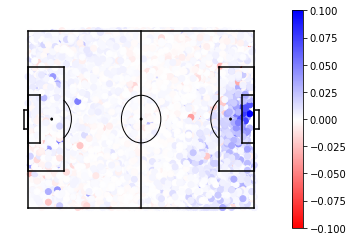

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# whole = whole.sort_values("xT_value", ascending=False)
mps.field(show=False)
plt.scatter(original_MLP.x, original_MLP.y, c=original_MLP.xT_value, cmap="bwr_r")
plt.clim(-0.1,0.1)
plt.colorbar()
plt.show()

# Construct the Transformer model

In [ ]:
inp_x_TF = inp_x.reshape(192260,6,1)

In [ ]:
input_y.shape

(192260, 1)

In [ ]:
n_classes = 1

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_transformer_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes)(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = inp_x_TF.shape[1:]

transformer_model = build_transformer_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

transformer_model.compile(
    loss='mean_absolute_error', optimizer='Adadelta', metrics=['mean_squared_error'],
)
transformer_model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 1)]       0           []                               
                                                                                                  
 layer_normalization_16 (LayerN  (None, 6, 1)        2           ['input_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_8 (MultiH  (None, 6, 1)        7169        ['layer_normalization_16[0][0]', 
 eadAttention)                                                    'layer_normalization_16[0][0]'] 
                                                                                            

In [3]:
transformer_model.fit(
    inp_x_TF,
    input_y,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
)

Epoch 1/50
2404/2404 [==============================] - 47s 19ms/step - loss: 0.0113 - mean_squared_error: 0.0011 - val_loss: 0.0117 - val_mean_squared_error: 0.0011
Epoch 2/50
2404/2404 [==============================] - 33s 14ms/step - loss: 0.0113 - mean_squared_error: 0.0011 - val_loss: 0.0117 - val_mean_squared_error: 0.0011
Epoch 3/50
2404/2404 [==============================] - 33s 14ms/step - loss: 0.0113 - mean_squared_error: 0.0011 - val_loss: 0.0117 - val_mean_squared_error: 0.0011
Epoch 4/50
2404/2404 [==============================] - 35s 15ms/step - loss: 0.0113 - mean_squared_error: 0.0011 - val_loss: 0.0117 - val_mean_squared_error: 0.0011
Epoch 5/50
2404/2404 [==============================] - 34s 14ms/step - loss: 0.0113 - mean_squared_error: 0.0011 - val_loss: 0.0117 - val_mean_squared_error: 0.0011
Epoch 6/50
2404/2404 [==============================] - 34s 14ms/step - loss: 0.0113 - mean_squared_error: 0.0011 - val_loss: 0.0116 - val_mean_squared_error: 0.0011
Epoc

### Save the model

In [ ]:
# from keras.models import load_model
# transformer_model.save(os.path.join(datafolder, "Transformer_model.h5"))

In [ ]:
# from keras.models import load_model
# transformer_model.save(os.path.join(datafolder, "Transformer_model_ep100.h5"))

In [ ]:
from keras.models import load_model
transformer_model.save(os.path.join(datafolder, "Transformer_model_reshape.h5"))

In [ ]:
from keras.models import load_model
transformer_model.save(os.path.join(datafolder, "Transformer_model_reshape_ep100.h5"))

# Load the Transformer model

In [ ]:
from keras.models import load_model
transformer_model_reshape_ep100 = load_model(os.path.join(datafolder, "Transformer_model_reshape_ep100.h5"))

### Transformer plot

In [ ]:
inp_x_TF = inp_x.reshape(192260,6,1)
prediction_TF = transformer_model_reshape_ep100.predict(inp_x_TF)

6009/6009 [==============================] - 109s 18ms/step


In [ ]:
inv_prediction_TF = scaler_y.inverse_transform(prediction_TF)

In [ ]:
original_TF = pd.DataFrame(columns=['x','y','xT_value'])
original_TF['x'] = pd.Series(long_y[:,1])
original_TF['y'] = pd.Series(long_y[:,2])
original_TF['xT_value'] = pd.Series(inv_prediction_TF.reshape(192260))
original_TF

x      y  xT_value
0       40.95  57.80 -0.006438
1       32.55  47.60 -0.000226
2       69.30  48.96 -0.000101
3       74.55  55.76  0.002180
4       65.10   4.76 -0.002611
...       ...    ...       ...
192255  44.10  53.04 -0.002811
192256  80.85  44.88  0.002026
192257  24.15  23.80  0.010839
192258  68.25   4.08  0.001042
192259  75.60  11.56  0.004482

[192260 rows x 3 columns]

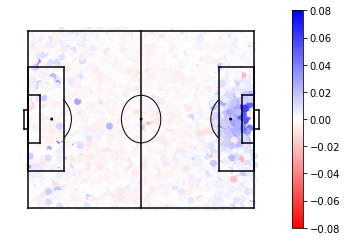

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# original_TF = original_TF.sort_values("xT_value", ascending=False)
mps.field(show=False)
plt.scatter(original_TF.x, original_TF.y, c=original_TF.xT_value, cmap="bwr_r")
plt.clim(-0.08,0.08)
plt.colorbar()
plt.show()

# Construct the LSTM model

In [ ]:
import os 
import numpy as np
import math
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Embedding, Masking, Dropout, Conv1D, MaxPooling1D, Reshape
from keras.models import load_model

In [ ]:
model_LSTM = Sequential()
inp_x = input_x.reshape((input_x.shape[0], 1, input_x.shape[1]))
model_LSTM.add(LSTM(50, input_shape=(inp_x.shape[1], inp_x.shape[2]), return_sequences=True))
model_LSTM.add(Dense(10))
model_LSTM.add(Dense(10))
model_LSTM.add(Dense(1))

model_LSTM.compile(loss='mean_absolute_error', optimizer='Adadelta', metrics=['mean_squared_error'])
model_LSTM.fit(inp_x, input_y, epochs=50, batch_size=72, verbose=1, validation_split=0.2)

Epoch 1/50
2137/2137 [==============================] - 9s 3ms/step - loss: 0.3069 - mean_squared_error: 0.0991 - val_loss: 0.2066 - val_mean_squared_error: 0.0461
Epoch 2/50
2137/2137 [==============================] - 7s 3ms/step - loss: 0.1038 - mean_squared_error: 0.0158 - val_loss: 0.0629 - val_mean_squared_error: 0.0061
Epoch 3/50
2137/2137 [==============================] - 7s 3ms/step - loss: 0.0577 - mean_squared_error: 0.0053 - val_loss: 0.0523 - val_mean_squared_error: 0.0045
Epoch 4/50
2137/2137 [==============================] - 7s 3ms/step - loss: 0.0484 - mean_squared_error: 0.0039 - val_loss: 0.0439 - val_mean_squared_error: 0.0033
Epoch 5/50
2137/2137 [==============================] - 7s 3ms/step - loss: 0.0406 - mean_squared_error: 0.0029 - val_loss: 0.0369 - val_mean_squared_error: 0.0025
Epoch 6/50
2137/2137 [==============================] - 7s 3ms/step - loss: 0.0339 - mean_squared_error: 0.0022 - val_loss: 0.0306 - val_mean_squared_error: 0.0019
Epoch 7/50
2137/

### Save the model

In [ ]:
from keras.models import load_model
model_LSTM.save(os.path.join(datafolder, "LSTM_nor_final.h5"))

# Load the LSTM model

In [ ]:
from keras.models import load_model
model_LSTM = load_model(os.path.join(datafolder, "LSTM_nor_final.h5"))

## LSTM_nor_model plot

In [ ]:
inp_x = input_x.reshape((input_x.shape[0], 1, input_x.shape[1]))
prediction_LSTM = model_LSTM.predict(inp_x)

6009/6009 [==============================] - 11s 2ms/step


In [ ]:
inv_prediction_LSTM = scaler_y.inverse_transform(prediction_LSTM[:,0])

In [ ]:
original_LSTM = pd.DataFrame(columns=['x','y','xT_value'])
original_LSTM['x'] = pd.Series(long_y[:,1])
original_LSTM['y'] = pd.Series(long_y[:,2])
original_LSTM['xT_value'] = pd.Series(inv_prediction_LSTM.reshape(192260))
original_LSTM

x      y  xT_value
0       40.95  57.80  0.000514
1       32.55  47.60  0.000576
2       69.30  48.96  0.002708
3       74.55  55.76  0.002448
4       65.10   4.76  0.000067
...       ...    ...       ...
192255  44.10  53.04  0.000760
192256  80.85  44.88  0.004349
192257  24.15  23.80  0.001418
192258  68.25   4.08  0.001500
192259  75.60  11.56  0.002635

[192260 rows x 3 columns]

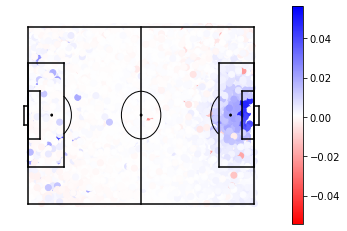

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# original_LSTM = original_LSTM.sort_values("xT_value", ascending=False)
mps.field(show=False)
plt.scatter(original_LSTM.x, original_LSTM.y, c=original_LSTM.xT_value, cmap="bwr_r")
# plt.clim(-0.1,0.1)
plt.colorbar()
plt.show()

# Construct the LSTM model (node2vec)

In [ ]:
import os 
import numpy as np
import math
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Embedding, Masking, Dropout, Conv1D, MaxPooling1D, Reshape
from keras.models import load_model

In [11]:
model_player = Sequential()
inp_x_player = input_x_player.reshape((input_x_player.shape[0], 1, input_x_player.shape[1]))
model_player.add(LSTM(50, input_shape=(inp_x_player.shape[1], inp_x_player.shape[2]), return_sequences=True))
model_player.add(Dense(10))
model_player.add(Dense(10))
model_player.add(Dense(1))

model_player.compile(loss='mean_absolute_error', optimizer='Adadelta', metrics=['mean_squared_error'])
model_player.fit(inp_x_player, input_y, epochs=50, batch_size=72, verbose=1, validation_split=0.2)

Epoch 1/50
2137/2137 [==============================] - 25s 10ms/step - loss: 0.0106 - mean_squared_error: 9.2102e-04 - val_loss: 0.0110 - val_mean_squared_error: 9.1434e-04
Epoch 2/50
2137/2137 [==============================] - 22s 11ms/step - loss: 0.0106 - mean_squared_error: 9.2098e-04 - val_loss: 0.0110 - val_mean_squared_error: 9.1044e-04
Epoch 3/50
2137/2137 [==============================] - 19s 9ms/step - loss: 0.0106 - mean_squared_error: 9.2082e-04 - val_loss: 0.0110 - val_mean_squared_error: 9.1263e-04
Epoch 4/50
2137/2137 [==============================] - 20s 9ms/step - loss: 0.0106 - mean_squared_error: 9.2073e-04 - val_loss: 0.0110 - val_mean_squared_error: 9.1411e-04
Epoch 5/50
2137/2137 [==============================] - 22s 10ms/step - loss: 0.0106 - mean_squared_error: 9.2065e-04 - val_loss: 0.0109 - val_mean_squared_error: 9.1228e-04
Epoch 6/50
2137/2137 [==============================] - 21s 10ms/step - loss: 0.0106 - mean_squared_error: 9.2028e-04 - val_loss: 0.

### Save the model

In [ ]:
from keras.models import load_model
model_player.save(os.path.join(datafolder, "LSTM_nor_final_node_ep100.h5"))

# Load the LSTM model (node2vec)

In [ ]:
from keras.models import load_model
model_player = load_model(os.path.join(datafolder, "LSTM_nor_final_node_ep100.h5"))

### LSTM_nor_model_node plot

In [ ]:
inp_x_player = input_x_player.reshape((input_x_player.shape[0], 1, input_x_player.shape[1]))
prediction_player = model_player.predict(inp_x_player)

6009/6009 [==============================] - 12s 2ms/step


In [ ]:
inv_prediction_player = scaler_y.inverse_transform(prediction_player[:,0])

In [ ]:
inp_x_player

array([[[0.50121647, 0.5       , 0.5       , ..., 0.08995118,
         0.46517623, 0.25301684]],

       [[0.50379337, 0.4       , 0.55      , ..., 0.12720075,
         0.49840256, 0.25518326]],

       [[0.50426739, 0.39      , 0.85      , ..., 0.11576701,
         0.38311947, 0.37798382]],

       ...,

       [[0.5257967 , 0.15      , 0.86      , ..., 0.5127668 ,
         0.52147415, 0.20141323]],

       [[0.50721604, 0.29      , 0.09      , ..., 0.515307  ,
         0.53914124, 0.30741139]],

       [[0.51789732, 0.23      , 0.35      , ..., 0.55129692,
         0.52197106, 0.18772461]]])

In [ ]:
original_player = pd.DataFrame(columns=['x','y','xT_value'])
original_player['x'] = pd.Series(long_y[:,1])
original_player['y'] = pd.Series(long_y[:,2])
original_player['xT_value'] = pd.Series(inv_prediction_player.reshape(192260))
original_player

x      y  xT_value
0       40.95  57.80  0.000945
1       32.55  47.60  0.000686
2       69.30  48.96  0.002289
3       74.55  55.76  0.001624
4       65.10   4.76  0.001259
...       ...    ...       ...
192255  44.10  53.04  0.001705
192256  80.85  44.88  0.002720
192257  24.15  23.80 -0.000882
192258  68.25   4.08  0.002616
192259  75.60  11.56  0.002935

[192260 rows x 3 columns]

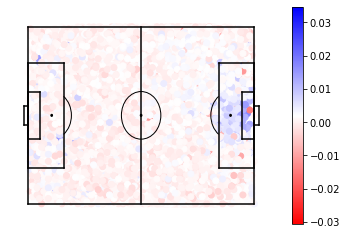

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# original_player = original_player.sort_values("xT_value", ascending=False)
mps.field(show=False)
plt.scatter(original_player.x, original_player.y, c=original_player.xT_value, cmap="bwr_r")
# plt.clim(-0.04,0.04)
plt.colorbar()
plt.show()

# Construct the LSTM model (interaction)

In [ ]:
import os 
import numpy as np
import math
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Embedding, Masking, Dropout, Conv1D, MaxPooling1D, Reshape
from keras.models import load_model

In [10]:
model_inter = Sequential()
inp_x_inter = input_x_inter.reshape((input_x_inter.shape[0], 1, input_x_inter.shape[1]))
model_inter.add(LSTM(50, input_shape=(inp_x_inter.shape[1], inp_x_inter.shape[2]), return_sequences=True))
model_inter.add(Dense(10))
model_inter.add(Dense(10))
model_inter.add(Dense(1))

model_inter.compile(loss='mean_absolute_error', optimizer='Adadelta', metrics=['mean_squared_error'])
model_inter.fit(inp_x_inter, input_y, epochs=50, batch_size=72, verbose=1, validation_split=0.2)

Epoch 1/50
2137/2137 [==============================] - 14s 6ms/step - loss: 0.0111 - mean_squared_error: 9.4699e-04 - val_loss: 0.0112 - val_mean_squared_error: 9.4792e-04
Epoch 2/50
2137/2137 [==============================] - 12s 5ms/step - loss: 0.0111 - mean_squared_error: 9.4674e-04 - val_loss: 0.0112 - val_mean_squared_error: 9.4689e-04
Epoch 3/50
2137/2137 [==============================] - 13s 6ms/step - loss: 0.0111 - mean_squared_error: 9.4664e-04 - val_loss: 0.0112 - val_mean_squared_error: 9.4467e-04
Epoch 4/50
2137/2137 [==============================] - 11s 5ms/step - loss: 0.0110 - mean_squared_error: 9.4656e-04 - val_loss: 0.0112 - val_mean_squared_error: 9.4413e-04
Epoch 5/50
2137/2137 [==============================] - 11s 5ms/step - loss: 0.0110 - mean_squared_error: 9.4623e-04 - val_loss: 0.0112 - val_mean_squared_error: 9.4596e-04
Epoch 6/50
2137/2137 [==============================] - 11s 5ms/step - loss: 0.0110 - mean_squared_error: 9.4598e-04 - val_loss: 0.0112

### Save the model

In [ ]:
from keras.models import load_model
model_inter.save(os.path.join(datafolder, "LSTM_nor_final_inter.h5"))

# Load the LSTM model (interaction)

In [ ]:
from keras.models import load_model
model_inter = load_model(os.path.join(datafolder, "LSTM_nor_final_inter.h5"))

## LSTM_nor_model_interaction plot



In [ ]:
inp_x_inter = input_x_inter.reshape((input_x_inter.shape[0], 1, input_x_inter.shape[1]))
prediction_inter = model_inter.predict(inp_x_inter)

6009/6009 [==============================] - 11s 2ms/step


In [ ]:
inv_prediction_inter = scaler_y.inverse_transform(prediction_inter[:,0])

In [ ]:
original_inter = pd.DataFrame(columns=['x','y','xT_value'])
original_inter['x'] = pd.Series(long_y[:,1])
original_inter['y'] = pd.Series(long_y[:,2])
original_inter['xT_value'] = pd.Series(inv_prediction_inter.reshape(192260))
original_inter

x      y  xT_value
0       40.95  57.80  0.001066
1       32.55  47.60  0.001150
2       69.30  48.96  0.001104
3       74.55  55.76  0.002031
4       65.10   4.76  0.000621
...       ...    ...       ...
192255  44.10  53.04  0.000156
192256  80.85  44.88  0.002515
192257  24.15  23.80  0.001573
192258  68.25   4.08  0.001040
192259  75.60  11.56  0.000950

[192260 rows x 3 columns]

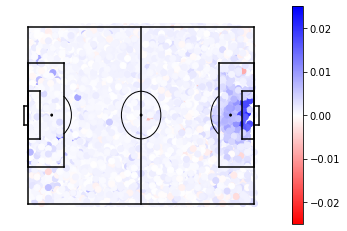

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# original_inter = original_inter.sort_values("xT_value", ascending=False)
mps.field(show=False)
plt.scatter(original_inter.x, original_inter.y, c=original_inter.xT_value, cmap="bwr_r")
plt.clim(-0.025,0.025)
plt.colorbar()
plt.show()

# Construct the LSTM model (match)

In [ ]:
import os 
import numpy as np
import math
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Embedding, Masking, Dropout, Conv1D, MaxPooling1D, Reshape
from keras.models import load_model

In [14]:
model_match = Sequential()
inp_x_match = input_x_match.reshape((input_x_match.shape[0], 1, input_x_match.shape[1]))
model_match.add(LSTM(50, input_shape=(inp_x_match.shape[1], inp_x_match.shape[2]), return_sequences=True))
model_match.add(Dense(10))
model_match.add(Dense(10))
model_match.add(Dense(1))

model_match.compile(loss='mean_absolute_error', optimizer='Adadelta', metrics=['mean_squared_error'])
model_match.fit(inp_x_match, input_y, epochs=50, batch_size=72, verbose=1, validation_split=0.2)

Epoch 1/50
2137/2137 [==============================] - 14s 6ms/step - loss: 0.0109 - mean_squared_error: 9.4305e-04 - val_loss: 0.0112 - val_mean_squared_error: 9.4123e-04
Epoch 2/50
2137/2137 [==============================] - 12s 5ms/step - loss: 0.0109 - mean_squared_error: 9.4274e-04 - val_loss: 0.0112 - val_mean_squared_error: 9.3989e-04
Epoch 3/50
2137/2137 [==============================] - 13s 6ms/step - loss: 0.0109 - mean_squared_error: 9.4262e-04 - val_loss: 0.0112 - val_mean_squared_error: 9.3767e-04
Epoch 4/50
2137/2137 [==============================] - 11s 5ms/step - loss: 0.0109 - mean_squared_error: 9.4234e-04 - val_loss: 0.0112 - val_mean_squared_error: 9.3713e-04
Epoch 5/50
2137/2137 [==============================] - 11s 5ms/step - loss: 0.0109 - mean_squared_error: 9.4220e-04 - val_loss: 0.0112 - val_mean_squared_error: 9.3896e-04
Epoch 6/50
2137/2137 [==============================] - 11s 5ms/step - loss: 0.0109 - mean_squared_error: 9.4195e-04 - val_loss: 0.0112

### Save the model

In [ ]:
from keras.models import load_model
model_match.save(os.path.join(datafolder, "LSTM_nor_final_match_ep100.h5"))

# Load the LSTM model (match)

In [ ]:
from keras.models import load_model
model_match = load_model(os.path.join(datafolder, "LSTM_nor_final_match_ep100.h5"))

### LSTM_nor_model_match plot

In [ ]:
inp_x_match = input_x_match.reshape((input_x_match.shape[0], 1, input_x_match.shape[1]))
prediction_match = model_match.predict(inp_x_match)

6009/6009 [==============================] - 12s 2ms/step


In [ ]:
inv_prediction_match = scaler_y.inverse_transform(prediction_match[:,0])

In [ ]:
original_match = pd.DataFrame(columns=['x','y','xT_value'])
original_match['x'] = pd.Series(long_y[:,1])
original_match['y'] = pd.Series(long_y[:,2])
original_match['xT_value'] = pd.Series(inv_prediction_match.reshape(192260))
original_match

x      y  xT_value
0       40.95  57.80  0.000396
1       32.55  47.60  0.000303
2       69.30  48.96  0.001504
3       74.55  55.76  0.001632
4       65.10   4.76  0.000669
...       ...    ...       ...
192255  44.10  53.04  0.002093
192256  80.85  44.88  0.003560
192257  24.15  23.80  0.002496
192258  68.25   4.08  0.002659
192259  75.60  11.56  0.002651

[192260 rows x 3 columns]

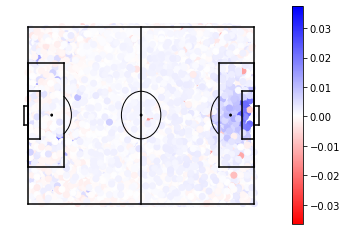

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# original_match = original_match.sort_values("xT_value", ascending=False)
mps.field(show=False)
plt.scatter(original_match.x, original_match.y, c=original_match.xT_value, cmap="bwr_r")
# plt.clim(-0.04,0.04)
plt.colorbar()
plt.show()

# Construct the LSTM model (node+match)

In [ ]:
import os 
import numpy as np
import math
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Embedding, Masking, Dropout, Conv1D, MaxPooling1D, Reshape
from keras.models import load_model

In [15]:
model_node_match = Sequential()
inp_x_node_match = input_x_node_match.reshape((input_x_node_match.shape[0], 1, input_x_node_match.shape[1]))
model_node_match.add(LSTM(50, input_shape=(inp_x_node_match.shape[1], inp_x_node_match.shape[2]), return_sequences=True))
model_node_match.add(Dense(10))
model_node_match.add(Dense(10))
model_node_match.add(Dense(1))

model_node_match.compile(loss='mean_absolute_error', optimizer='Adadelta', metrics=['mean_squared_error'])
model_node_match.fit(inp_x_node_match, input_y, epochs=50, batch_size=72, verbose=1, validation_split=0.2)

Epoch 1/50
2137/2137 [==============================] - 17s 6ms/step - loss: 0.4002 - mean_squared_error: 0.1686 - val_loss: 0.2514 - val_mean_squared_error: 0.0665
Epoch 2/50
2137/2137 [==============================] - 11s 5ms/step - loss: 0.1031 - mean_squared_error: 0.0171 - val_loss: 0.0521 - val_mean_squared_error: 0.0042
Epoch 3/50
2137/2137 [==============================] - 17s 8ms/step - loss: 0.0446 - mean_squared_error: 0.0033 - val_loss: 0.0374 - val_mean_squared_error: 0.0025
Epoch 4/50
2137/2137 [==============================] - 19s 9ms/step - loss: 0.0311 - mean_squared_error: 0.0020 - val_loss: 0.0253 - val_mean_squared_error: 0.0015
Epoch 5/50
2137/2137 [==============================] - 15s 7ms/step - loss: 0.0209 - mean_squared_error: 0.0013 - val_loss: 0.0173 - val_mean_squared_error: 0.0011
Epoch 6/50
2137/2137 [==============================] - 14s 6ms/step - loss: 0.0148 - mean_squared_error: 0.0010 - val_loss: 0.0132 - val_mean_squared_error: 9.5949e-04
Epoch 

### Save the model

In [ ]:
from keras.models import load_model
model_node_match.save(os.path.join(datafolder, "LSTM_nor_final_node_match_ep100.h5"))

# Load the LSTM model (node+match)

In [ ]:
from keras.models import load_model
model_node_match = load_model(os.path.join(datafolder, "LSTM_nor_final_node_match_ep100.h5"))

### LSTM_nor_model_node_match plot

In [ ]:
inp_x_node_match = input_x_node_match.reshape((input_x_node_match.shape[0], 1, input_x_node_match.shape[1]))
prediction_node_match = model_node_match.predict(inp_x_node_match)

6009/6009 [==============================] - 11s 2ms/step


In [ ]:
inv_prediction_node_match = scaler_y.inverse_transform(prediction_node_match[:,0])

In [ ]:
original_node_match = pd.DataFrame(columns=['x','y','xT_value'])
original_node_match['x'] = pd.Series(long_y[:,1])
original_node_match['y'] = pd.Series(long_y[:,2])
original_node_match['xT_value'] = pd.Series(inv_prediction_node_match.reshape(192260))
original_node_match

x      y  xT_value
0       40.95  57.80  0.000117
1       32.55  47.60  0.000697
2       69.30  48.96  0.000237
3       74.55  55.76  0.000270
4       65.10   4.76  0.000306
...       ...    ...       ...
192255  44.10  53.04  0.002081
192256  80.85  44.88  0.004204
192257  24.15  23.80  0.003418
192258  68.25   4.08  0.003402
192259  75.60  11.56  0.002964

[192260 rows x 3 columns]

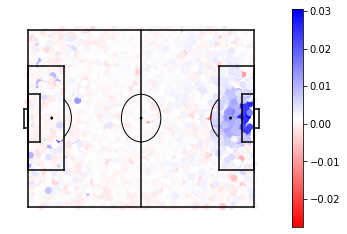

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# original_match = original_match.sort_values("xT_value", ascending=False)
mps.field(show=False)
plt.scatter(original_node_match.x, original_node_match.y, c=original_node_match.xT_value, cmap="bwr_r")
# plt.clim(-0.04,0.04)
plt.colorbar()
plt.show()

# Construct the LSTM model (inter+node+match)

In [ ]:
import os 
import numpy as np
import math
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Embedding, Masking, Dropout, Conv1D, MaxPooling1D, Reshape
from keras.models import load_model

In [16]:
model_inter_node_match = Sequential()
inp_x_inter_node_match = input_x_inter_node_match.reshape((input_x_inter_node_match.shape[0], 1, input_x_inter_node_match.shape[1]))
model_inter_node_match.add(LSTM(50, input_shape=(inp_x_inter_node_match.shape[1], inp_x_inter_node_match.shape[2]), return_sequences=True))
model_inter_node_match.add(Dense(10))
model_inter_node_match.add(Dense(10))
model_inter_node_match.add(Dense(1))

model_inter_node_match.compile(loss='mean_absolute_error', optimizer='Adadelta', metrics=['mean_squared_error'])
model_inter_node_match.fit(inp_x_inter_node_match, input_y, epochs=50, batch_size=72, verbose=1, validation_split=0.2)

Epoch 1/50
2137/2137 [==============================] - 25s 10ms/step - loss: 0.0108 - mean_squared_error: 9.2602e-04 - val_loss: 0.0111 - val_mean_squared_error: 9.1934e-04
Epoch 2/50
2137/2137 [==============================] - 22s 11ms/step - loss: 0.0108 - mean_squared_error: 9.2598e-04 - val_loss: 0.0111 - val_mean_squared_error: 9.1544e-04
Epoch 3/50
2137/2137 [==============================] - 19s 9ms/step - loss: 0.0108 - mean_squared_error: 9.2582e-04 - val_loss: 0.0111 - val_mean_squared_error: 9.1763e-04
Epoch 4/50
2137/2137 [==============================] - 20s 9ms/step - loss: 0.0108 - mean_squared_error: 9.2573e-04 - val_loss: 0.0111 - val_mean_squared_error: 9.1911e-04
Epoch 5/50
2137/2137 [==============================] - 22s 10ms/step - loss: 0.0108 - mean_squared_error: 9.2565e-04 - val_loss: 0.0111 - val_mean_squared_error: 9.1728e-04
Epoch 6/50
2137/2137 [==============================] - 21s 10ms/step - loss: 0.0108 - mean_squared_error: 9.2528e-04 - val_loss: 0.

### Save the model

In [ ]:
from keras.models import load_model
model_inter_node_match.save(os.path.join(datafolder, "LSTM_nor_final_inter_node_match_ep100.h5"))

# Load the LSTM model (inter+node+match)

In [ ]:
from keras.models import load_model
model_inter_node_match = load_model(os.path.join(datafolder, "LSTM_nor_final_inter_node_match_ep100.h5"))

### LSTM_nor_model_inter_node_match plt

In [ ]:
inp_x_inter_node_match = input_x_inter_node_match.reshape((input_x_inter_node_match.shape[0], 1, input_x_inter_node_match.shape[1]))
prediction_inter_node_match = model_inter_node_match.predict(inp_x_inter_node_match)

6009/6009 [==============================] - 11s 2ms/step


In [ ]:
inv_prediction_inter_node_match = scaler_y.inverse_transform(prediction_inter_node_match[:,0])

In [ ]:
original_inter_node_match = pd.DataFrame(columns=['x','y','xT_value'])
original_inter_node_match['x'] = pd.Series(long_y[:,1])
original_inter_node_match['y'] = pd.Series(long_y[:,2])
original_inter_node_match['xT_value'] = pd.Series(inv_prediction_inter_node_match.reshape(192260))
original_inter_node_match

x      y  xT_value
0       40.95  57.80  0.000545
1       32.55  47.60 -0.000040
2       69.30  48.96  0.000874
3       74.55  55.76  0.000859
4       65.10   4.76 -0.001214
...       ...    ...       ...
192255  44.10  53.04  0.000615
192256  80.85  44.88  0.002141
192257  24.15  23.80  0.004319
192258  68.25   4.08  0.001549
192259  75.60  11.56  0.001227

[192260 rows x 3 columns]

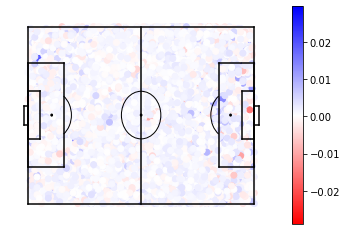

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# original_match = original_match.sort_values("xT_value", ascending=False)
mps.field(show=False)
plt.scatter(original_inter_node_match.x, original_inter_node_match.y, c=original_inter_node_match.xT_value, cmap="bwr_r")
# plt.clim(-0.025,0.025)
plt.colorbar()
plt.show()

# Graph embedding

## Node2Vec

### Model

In [ ]:
!pip install node2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=ad3907a47a3d834400aa1605e3be8dd8f4666ce63c63c014918c83c23a71c558
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [ ]:
import networkx as nx

edge = []
edge_w = dict()
for i in range(len(A)-1):
  if A.iloc[i+1]['time_seconds'] > A.iloc[i]['time_seconds']:
    a = A.iloc[i]['player_id']
    b = A.iloc[i+1]['player_id']
    edge.append((a, b)) # (节点号1，节点号2)
    if (a, b) in edge_w:
      edge_w[(a, b)] += 1
    else:
      edge_w[(a, b)] = 1
    # edge.append((a, b, math.sqrt(abs(A.iloc[i]['start_x']-A.iloc[i]['end_x'])**2+abs(A.iloc[i]['start_y']-A.iloc[i]['end_y'])**2))) # TypeError: 'float' object is not iterable

# edge
# G = nx.DiGraph(nx.from_edgelist(edge))

In [ ]:
edgelist = []
for key, value in edge_w.items():
    temp = [key[0],key[1],value]
    edgelist.append(temp)
edgelist[:10]

[[9637, 8351, 51],
 [8351, 9285, 163],
 [9285, 239411, 27],
 [239411, 9637, 3],
 [9637, 245813, 14],
 [245813, 9285, 9],
 [9285, 9433, 6],
 [9433, 9285, 9],
 [9285, 8643, 6],
 [8643, 9285, 7]]

In [ ]:
G = nx.DiGraph()   # or DiGraph, MultiGraph, MultiDiGraph, etc
G.add_weighted_edges_from(edgelist)

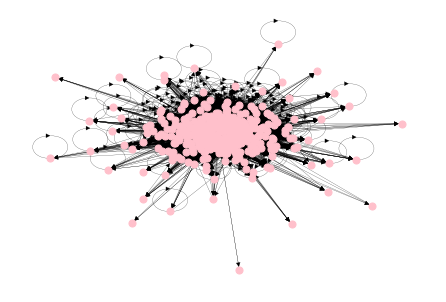

In [ ]:
import matplotlib.pyplot as plt
nx.draw(G, width=0.2, 
        node_color='pink', node_size=50)
plt.show()

In [ ]:
import networkx as nx
from node2vec import Node2Vec

# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(G, dimensions=8, walk_length=30, num_walks=200, workers=4)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

Computing transition probabilities:   0%|          | 0/514 [00:00<?, ?it/s]

In [ ]:
# Look for most similar nodes
node_vectors.wv.most_similar('3319',topn=20)  # Output node names are always strings

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


[('7870', 0.9989074468612671),
 ('3560', 0.9982960820198059),
 ('49876', 0.9981584548950195),
 ('167145', 0.9981518983840942),
 ('7855', 0.997915506362915),
 ('230020', 0.9969263076782227),
 ('25413', 0.996338963508606),
 ('14869', 0.9959533214569092),
 ('7945', 0.9950326681137085),
 ('25867', 0.9940996170043945),
 ('7864', 0.9938384294509888),
 ('20612', 0.9936320781707764),
 ('120339', 0.9931467175483704),
 ('279717', 0.9926503896713257),
 ('7873', 0.9921155571937561),
 ('370224', 0.9907102584838867),
 ('7882', 0.9901800751686096),
 ('7856', 0.9853032827377319),
 ('171283', 0.982231855392456),
 ('413002', 0.9758116006851196)]

In [ ]:
EMBEDDING_FILENAME = os.path.join(datafolder, 'node2vec.txt')
# Save embeddings for later use
model.wv.save_word2vec_format(EMBEDDING_FILENAME, binary=False)


EMBEDDING_MODEL_FILENAME = os.path.join(datafolder, 'node_model.txt')
# Save model for later use
model.save(EMBEDDING_MODEL_FILENAME)

In [ ]:
# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder

edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

# Look for embeddings on the fly - here we pass normal tuples
edges_embs[('9433', '8643')]
''' OUTPUT
array([ 5.75068220e-03, -1.10937878e-02,  3.76693785e-01,  2.69105062e-02,
       ... ... ....
       ..................................................................],
      dtype=float32)
'''

# Get all edges in a separate KeyedVectors instance - use with caution could be huge for big networks
edges_kv = edges_embs.as_keyed_vectors()

# Look for most similar edges - this time tuples must be sorted and as str
edges_kv.most_similar(str(('9285', '9433')))


EDGES_EMBEDDING_FILENAME = os.path.join(datafolder, 'edge_emb.txt')
# Save embeddings for later use
edges_kv.save_word2vec_format(EDGES_EMBEDDING_FILENAME)

Generating edge features: 100%|██████████| 132355/132355.0 [00:01<00:00, 81228.11it/s]


In [ ]:
node_vec = model.wv

In [ ]:
model.wv['9637']

array([-0.626976  ,  0.75904465, -0.75484514, -0.19447833,  0.23779896,
       -0.553042  , -0.4059192 , -0.65813684], dtype=float32)

In [ ]:
player_vec = []
for id in A['player_id']:
  # print(id)
  player_vec.append(model.wv[str(id)].tolist())

In [ ]:
len(player_vec)

483665

### Save & load Node2Vec model

In [ ]:
from gensim.models import KeyedVectors
# node_vec.save(os.path.join(datafolder, 'node_vectors.kv'))
node_vectors = KeyedVectors.load(os.path.join(datafolder, 'node_vectors.kv'))

In [ ]:
node_vectors['9637'].tolist()

[-0.6269760131835938,
 0.7590446472167969,
 -0.754845142364502,
 -0.1944783329963684,
 0.23779895901679993,
 -0.5530419945716858,
 -0.4059191942214966,
 -0.6581368446350098]

# GAT

## players features

In [ ]:
player_unique = []
for i in range(len(A)):
  if A.iloc[i]['player_id'] not in player_unique:
    player_unique.append(A.iloc[i]['player_id'])

In [ ]:
edge[:10]

[(9637, 8351),
 (8351, 9285),
 (9285, 239411),
 (239411, 9637),
 (9637, 245813),
 (245813, 9285),
 (9285, 9433),
 (9433, 9285),
 (9285, 8643),
 (8643, 9285)]

In [ ]:
G.nodes(9637)

NodeDataView({9637: None, 8351: None, 9285: None, 239411: None, 245813: None, 9433: None, 8643: None, 259531: None, 9277: None, 62224: None, 9739: None, 134102: None, 8925: None, 8284: None, 10108: None, 12242: None, 93: None, 8726: None, 8433: None, 8125: None, 9206: None, 8980: None, 0: None, 11669: None, 7989: None, 9127: None, 8296: None, 9179: None, 532949: None, 8471: None, 127537: None, 8422: None, 25430: None, 7988: None, 486252: None, 8623: None, 454: None, 235555: None, 8285: None, 25537: None, 8370: None, 8530: None, 5281: None, 8425: None, 8554: None, 8360: None, 8358: None, 8958: None, 119951: None, 7853: None, 3577: None, 261: None, 38031: None, 8686: None, 7907: None, 8049: None, 25703: None, 8290: None, 8897: None, 55979: None, 9419: None, 14796: None, 132: None, 15215: None, 20612: None, 167145: None, 230020: None, 370224: None, 14869: None, 25867: None, 282550: None, 56038: None, 7870: None, 25662: None, 62389: None, 214654: None, 105338: None, 49876: None, 25413: Non

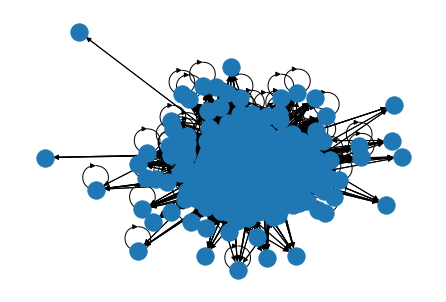

In [ ]:
nx.draw(G)
plt.show()

In [ ]:
Adj = nx.adjacency_matrix(G).todense()

In [ ]:
Adj

matrix([[1, 1, 1, ..., 0, 1, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
players = pd.read_json(os.path.join(datafolder, "players.json"))
players = players.set_index('wyId')
players['age'] = 2018-players['birthDate'].str[:4].astype(int)

In [ ]:
player_unique[:10]

In [ ]:
all_features = players.reindex(player_unique)[['weight','height','age','foot','currentTeamId','currentNationalTeamId']]

In [ ]:
all_features['foot'] = all_features['foot'].astype('category')
all_features['currentTeamId'] = all_features['currentTeamId'].astype('category')
all_features['currentNationalTeamId'] = all_features['currentNationalTeamId'].astype('category')

In [ ]:
all_features

weight  height   age   foot currentTeamId currentNationalTeamId
wyId                                                                   
9637      74.0   180.0  26.0  right          1659                  7336
8351      73.0   178.0  32.0   left          1659                  null
9285      75.0   178.0  32.0   left          1659                  null
239411    77.0   196.0  25.0   left          1659                  null
245813    80.0   184.0  22.0  right          1659                  null
...        ...     ...   ...    ...           ...                   ...
297258    70.0   178.0  23.0  right          1628                  null
227756    72.0   174.0  21.0  right          3315                  null
20450     65.0   170.0  28.0  right           696                  null
447254    64.0   188.0  18.0  right          1627                  2417
134708    75.0   185.0  23.0  right          2451                  null

[514 rows x 6 columns]

In [ ]:
# ### Data Preprocessing
numeric_features = all_features.dtypes[all_features.dtypes != 'category'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x-x.mean())/(x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

# ##### Get Dummies
all_features = pd.get_dummies(all_features, dummy_na=True)
# all_features = A.merge(all_features, left_on=['player_id'], right_on = ['wyId'], how='left')[all_features.columns]

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
players_features = csr_matrix(all_features.values)

# players_features = np.asmatrix(all_features.values)

In [ ]:
players_features

<514x174 sparse matrix of type '<class 'numpy.float64'>'
	with 3081 stored elements in Compressed Sparse Row format>

## Match sequence

In [ ]:
matches = pd.read_json(os.path.join(datafolder, "matches_England.json"))

In [ ]:
matches

status  roundId  gameweek  \
0    Played  4405654        38   
1    Played  4405654        38   
2    Played  4405654        38   
3    Played  4405654        38   
4    Played  4405654        38   
..      ...      ...       ...   
375  Played  4405654         1   
376  Played  4405654         1   
377  Played  4405654         1   
378  Played  4405654         1   
379  Played  4405654         1   

                                             teamsData  seasonId  \
0    {'1646': {'scoreET': 0, 'coachId': 8880, 'side...    181150   
1    {'1628': {'scoreET': 0, 'coachId': 8357, 'side...    181150   
2    {'1609': {'scoreET': 0, 'coachId': 7845, 'side...    181150   
3    {'1651': {'scoreET': 0, 'coachId': 8093, 'side...    181150   
4    {'1644': {'scoreET': 0, 'coachId': 93112, 'sid...    181150   
..                                                 ...       ...   
375  {'1623': {'scoreET': 0, 'coachId': 268779, 'si...    181150   
376  {'10531': {'scoreET': 0, 'coachId': 381291, 's...    181150   
377  {'1659': {'scoreET': 0, 'coachId': 8934, 'side...    181150   
378  {'1644': {'scoreET': 0, 'coachId': 71037, 'sid...    181150   
379  {'1609': {'scoreET': 0, 'coachId': 7845, 'side...    181150   

                 dateutc  winner                     venue     wyId  \
0    2018-05-13 14:00:00    1659                 Turf Moor  2500089   
1    2018-05-13 14:00:00    1628             Selhurst Park  2500090   
2    2018-05-13 14:00:00    1609  The John Smith's Stadium  2500091   
3    2018-05-13 14:00:00    1612                   Anfield  2500092   
4    2018-05-13 14:00:00    1611              Old Trafford  2500093   
..                   ...     ...                       ...      ...   
375  2017-08-12 14:00:00    1623             Goodison Park  2499723   
376  2017-08-12 14:00:00       0        St. Mary's Stadium  2499726   
377  2017-08-12 14:00:00    1627             The Hawthorns  2499728   
378  2017-08-12 11:30:00       0     Vicarage Road Stadium  2499727   
379  2017-08-11 18:45:00    1609          Emirates Stadium  2499719   

                                             label  \
0                 Burnley - AFC Bournemouth, 1 - 2   
1     Crystal Palace - West Bromwich Albion, 2 - 0   
2               Huddersfield Town - Arsenal, 0 - 1   
3        Liverpool - Brighton & Hove Albion, 4 - 0   
4               Manchester United - Watford, 1 - 0   
..                                             ...   
375                    Everton - Stoke City, 1 - 0   
376              Southampton - Swansea City, 0 - 0   
377  West Bromwich Albion - AFC Bournemouth, 1 - 0   
378                     Watford - Liverpool, 3 - 3   
379                Arsenal - Leicester City, 4 - 3   

                                    date  \
0       May 13, 2018 at 4:00:00 PM GMT+2   
1       May 13, 2018 at 4:00:00 PM GMT+2   
2       May 13, 2018 at 4:00:00 PM GMT+2   
3       May 13, 2018 at 4:00:00 PM GMT+2   
4       May 13, 2018 at 4:00:00 PM GMT+2   
..                                   ...   
375  August 12, 2017 at 4:00:00 PM GMT+2   
376  August 12, 2017 at 4:00:00 PM GMT+2   
377  August 12, 2017 at 4:00:00 PM GMT+2   
378  August 12, 2017 at 1:30:00 PM GMT+2   
379  August 11, 2017 at 8:45:00 PM GMT+2   

                                              referees duration  competitionId  
0    [{'refereeId': 385705, 'role': 'referee'}, {'r...  Regular            364  
1    [{'refereeId': 381851, 'role': 'referee'}, {'r...  Regular            364  
2    [{'refereeId': 384965, 'role': 'referee'}, {'r...  Regular            364  
3    [{'refereeId': 385704, 'role': 'referee'}, {'r...  Regular            364  
4    [{'refereeId': 381853, 'role': 'referee'}, {'r...  Regular            364  
..                                                 ...      ...            ...  
375  [{'refereeId': 385915, 'role': 'referee'}, {'r...  Regular            364  
376  [{'refereeId': 385916, 'role': 'referee'}, {'r...  Regular            364  
377  [{'refereeId':

In [ ]:
match_order = matches['wyId'].tolist()

In [ ]:
match_order[:10]

[2500089,
 2500090,
 2500091,
 2500092,
 2500093,
 2500094,
 2500095,
 2500096,
 2500097,
 2500098]

In [ ]:
pd.json_normalize(matches['teamsData'].iloc[0]).iloc[:, [0,1,2,3,4,5,6,10,11,12,13,14,15,16,17,21]].values.tolist()[0]

[0, 8880, 'home', 1646, 1, 0, 1, 1, 0, 8934, 'away', 1659, 2, 0, 1, 0]

In [ ]:
matches_info_col = ['scoreET1', 'coachId1', 'side1','teamId1','score1','scoreP1','hasFormation1','scoreHT1','ScoreET2', 'coachId2', 'side2','teamId2','score2','scoreP2','hasFormation2','scoreHT2']
matches_info = pd.DataFrame(columns=matches_info_col)
for i in range(380):
    matches_info = matches_info.append(pd.Series(pd.json_normalize(matches['teamsData'].iloc[i]).iloc[:, [0,1,2,3,4,5,6,10,11,12,13,14,15,16,17,21]].values.tolist()[0], index = matches_info_col),ignore_index=True)

In [ ]:
convert_dict = {'scoreET1': int, 
          'coachId1':"category", 
          'side1':"category",
          'teamId1':"category",
          'score1': int,
          'scoreP1': int,
          'hasFormation1': int,
          'scoreHT1': int,
          'ScoreET2': int, 
          'coachId2':"category", 
          'side2':"category",
          'teamId2':"category",
          'score2': int,
          'scoreP2': int,
          'hasFormation2': int,
          'scoreHT2': int
                }
 
matches_info = matches_info.astype(convert_dict)

In [ ]:
matches_info['winner'] = matches['winner'].astype('category')

In [ ]:
team1 = matches_info['teamId1'].values.tolist()
team2 = matches_info['teamId2'].values.tolist()

In [ ]:
team2[:10]

[1659, 1627, 1673, 1612, 1611, 1610, 1619, 1639, 1624, 1633]

In [ ]:
len(matches_info)

380

In [ ]:
import networkx as nx

match_edge = []
for i in range(len(team1)):
  for j in range(len(team1)):
    if team1[i] == team1[j] and i != j:
      match_edge.append((i,j))
  for k in range(len(team2)):
    if team1[i] == team2[k] and i != k:
      match_edge.append((i,k))
for i in range(len(team2)):
  for j in range(len(team1)):
    if team2[i] == team1[j] and i != j:
      match_edge.append((i,j))
  for k in range(len(team2)):
    if team2[i] == team2[k] and i != k:
      match_edge.append((i,k))

In [ ]:
match_edge[:10]

[(0, 30),
 (0, 42),
 (0, 74),
 (0, 106),
 (0, 129),
 (0, 135),
 (0, 144),
 (0, 167),
 (0, 176),
 (0, 186)]

In [ ]:
G_match = nx.Graph(nx.from_edgelist(match_edge))

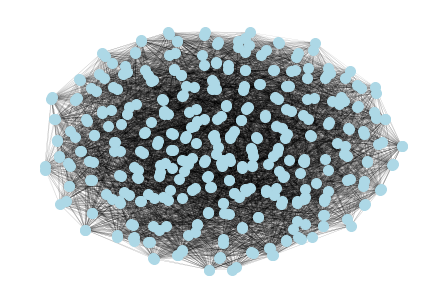

In [ ]:
Adj = nx.adjacency_matrix(G_match).todense()
from scipy.sparse import csr_matrix
Adj = csr_matrix(Adj)
import matplotlib.pyplot as plt
nx.draw(G_match, width=0.05, 
        node_color='lightblue', node_size=100)
plt.show()

In [ ]:
# ### Data Preprocessing
numeric_features = matches_info.dtypes[matches_info.dtypes != 'category'].index
matches_info[numeric_features] = matches_info[numeric_features].apply(
    lambda x: (x-x.mean())/(x.std()))
matches_info[numeric_features] = matches_info[numeric_features].fillna(0)

# ##### Get Dummies
matches_info = pd.get_dummies(matches_info, dummy_na=True)
# matches_info = A.merge(matches_info, left_on=['player_id'], right_on = ['wyId'], how='left')[matches_info.columns]

In [ ]:
match_Y = matches_info[matches_info.columns[-22:]].values

In [ ]:
match_Y.shape

(380, 22)

In [ ]:
matches_info = matches_info[matches_info.columns[:-22]]

In [ ]:
matches_info

scoreET1    score1  scoreP1  hasFormation1  scoreHT1  ScoreET2    score2  \
0         0.0 -0.134905      0.0            0.0  0.705118       0.0  0.343019   
1         0.0  0.748954      0.0            0.0 -0.655008       0.0 -1.105284   
2         0.0 -0.134905      0.0            0.0  0.705118       0.0 -1.105284   
3         0.0 -1.018763      0.0            0.0 -0.655008       0.0  1.791322   
4         0.0 -1.018763      0.0            0.0 -0.655008       0.0 -0.381132   
..        ...       ...      ...            ...       ...       ...       ...   
375       0.0 -0.134905      0.0            0.0  0.705118       0.0 -1.105284   
376       0.0 -1.018763      0.0            0.0 -0.655008       0.0 -1.105284   
377       0.0 -1.018763      0.0            0.0 -0.655008       0.0 -0.381132   
378       0.0  1.632812      0.0            0.0  2.065245       0.0  1.067171   
379       0.0  2.516671      0.0            0.0  2.065245       0.0  1.067171   

     scoreP2  hasFormation2  scoreHT2  ...  teamId2_1631.0  teamId2_1633.0  \
0        0.0            0.0 -0.791152  ...               0               0   
1        0.0            0.0 -0.791152  ...               0               0   
2        0.0            0.0 -0.791152  ...               0               0   
3        0.0            0.0  1.683233  ...               0               0   
4        0.0            0.0  0.446041  ...               0               0   
..       ...            ...       ...  ...             ...             ...   
375      0.0            0.0 -0.791152  ...               0               0   
376      0.0            0.0 -0.791152  ...               0               0   
377      0.0            0.0  0.446041  ...               0               0   
378      0.0            0.0  0.446041  ...               0               0   
379      0.0            0.0  1.683233  ...               1               0   

     teamId2_1639.0  teamId2_1644.0  teamId2_1646.0  teamId2_1651.0  \
0                 0               0               0               0   
1                 0               0               0               0   
2                 0               0               0               0   
3                 0               0               0               0   
4                 0               0               0               0   
..              ...             ...             ...             ...   
375               1               0               0               0   
376               0               0               0               0   
377               0               0               0               0   
378               0               0               0               0   
379               0               0               0               0   

     teamId2_1659.0  teamId2_1673.0  teamId2_10531.0  teamId2_nan  
0                 1               0                0            0  
1                 0               0                0            0  
2                 0               1                0            0  
3                 0               0                0            0  
4                 0               0                0            0  
..              ...             ...              ...          ...  
375               0               0                0            0  
376               0               0                0            0  
377               0               0                0            0  
378               0               0                0            0  
379               0               0                0            0  

[380 rows x 123 columns]

In [ ]:
matches_info.columns

Index(['scoreET1', 'score1', 'scoreP1', 'hasFormation1', 'scoreHT1',
       'ScoreET2', 'score2', 'scoreP2', 'hasFormation2', 'scoreHT2',
       ...
       'teamId2_1631.0', 'teamId2_1633.0', 'teamId2_1639.0', 'teamId2_1644.0',
       'teamId2_1646.0', 'teamId2_1651.0', 'teamId2_1659.0', 'teamId2_1673.0',
       'teamId2_10531.0', 'teamId2_nan'],
      dtype='object', length=123)

In [ ]:
from scipy.sparse import csr_matrix
match_features = csr_matrix(matches_info.values)

In [ ]:
match_features

<380x123 sparse matrix of type '<class 'numpy.float64'>'
	with 3800 stored elements in Compressed Sparse Row format>

### Save graph input

In [ ]:
# import pickle
# with open(os.path.join(datafolder, "Adj_match"), "wb") as fp:   #Pickling
#   pickle.dump(Adj, fp)
# with open(os.path.join(datafolder, "match_features"), "wb") as fp:   #Pickling
#   pickle.dump(match_features, fp)
# with open(os.path.join(datafolder, "match_Y"), "wb") as fp:   #Pickling
#   pickle.dump(match_Y, fp)

### Load graph input

In [ ]:
import pickle

with open(os.path.join(datafolder, "Adj_match"), "rb") as fp:   # Unpickling
  Adj = pickle.load(fp)
with open(os.path.join(datafolder, "match_features"), "rb") as fp:   # Unpickling
  match_features = pickle.load(fp)
with open(os.path.join(datafolder, "match_Y"), "rb") as fp:   # Unpickling
  match_Y = pickle.load(fp)

print(Adj[0])
print(match_features[0])
print(match_Y[0])

  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	1
  (0, 13)	1
  (0, 14)	1
  (0, 15)	1
  (0, 16)	1
  (0, 17)	1
  (0, 18)	1
  (0, 19)	1
  (0, 20)	1
  (0, 21)	1
  (0, 22)	1
  (0, 23)	1
  (0, 24)	1
  :	:
  (0, 222)	1
  (0, 226)	1
  (0, 237)	1
  (0, 252)	1
  (0, 262)	1
  (0, 278)	1
  (0, 285)	1
  (0, 294)	1
  (0, 298)	1
  (0, 318)	1
  (0, 322)	1
  (0, 335)	1
  (0, 336)	1
  (0, 346)	1
  (0, 349)	1
  (0, 352)	1
  (0, 357)	1
  (0, 360)	1
  (0, 361)	1
  (0, 362)	1
  (0, 363)	1
  (0, 364)	1
  (0, 365)	1
  (0, 366)	1
  (0, 367)	1
  (0, 1)	-0.134904725297433
  (0, 4)	0.7051182171839286
  (0, 6)	0.34301918961058964
  (0, 9)	-0.7911521964771601
  (0, 19)	1.0
  (0, 43)	1.0
  (0, 60)	1.0
  (0, 78)	1.0
  (0, 99)	1.0
  (0, 119)	1.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


In [ ]:
match_features.shape

(380, 123)

## Graph Attention

In [ ]:
from __future__ import absolute_import
 
from keras import activations, constraints, initializers, regularizers
from keras import backend as K
from keras.layers import Layer, Dropout, LeakyReLU
 
 
class GraphAttention(Layer):
 
    def __init__(self,
                 F_,
                 attn_heads=1,
                 attn_heads_reduction='concat',  # {'concat', 'average'}
                 dropout_rate=0.5,
                 activation='relu',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 attn_kernel_initializer='glorot_uniform',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 attn_kernel_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 attn_kernel_constraint=None,
                 **kwargs):
        if attn_heads_reduction not in {'concat', 'average'}:
            raise ValueError('Possbile reduction methods: concat, average')
 
        self.F_ = F_  # Number of output features (F' in the paper)
        self.attn_heads = attn_heads  # Number of attention heads (K in the paper)
        self.attn_heads_reduction = attn_heads_reduction  # Eq. 5 and 6 in the paper
        self.dropout_rate = dropout_rate  # Internal dropout rate
        self.activation = activations.get(activation)  # Eq. 4 in the paper
        self.use_bias = use_bias
 
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.attn_kernel_initializer = initializers.get(attn_kernel_initializer)
 
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.attn_kernel_regularizer = regularizers.get(attn_kernel_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
 
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.attn_kernel_constraint = constraints.get(attn_kernel_constraint)
        self.supports_masking = False
 
        # Populated by build()
        self.kernels = []       # Layer kernels for attention heads
        self.biases = []        # Layer biases for attention heads
        self.attn_kernels = []  # Attention kernels for attention heads
 
        if attn_heads_reduction == 'concat':
            # Output will have shape (..., K * F')
            self.output_dim = self.F_ * self.attn_heads
        else:
            # Output will have shape (..., F')
            self.output_dim = self.F_
 
        super(GraphAttention, self).__init__(**kwargs)
 
    def build(self, input_shape):
        assert len(input_shape) >= 2
        F = input_shape[0][-1]
 
        # Initialize weights for each attention head
        for head in range(self.attn_heads):
            # Layer kernel
            kernel = self.add_weight(shape=(F, self.F_),
                                     initializer=self.kernel_initializer,
                                     regularizer=self.kernel_regularizer,
                                     constraint=self.kernel_constraint,
                                     name='kernel_{}'.format(head))
            self.kernels.append(kernel)
 
            # # Layer bias
            if self.use_bias:
                bias = self.add_weight(shape=(self.F_, ),
                                       initializer=self.bias_initializer,
                                       regularizer=self.bias_regularizer,
                                       constraint=self.bias_constraint,
                                       name='bias_{}'.format(head))
                self.biases.append(bias)
 
            # Attention kernels
            attn_kernel_self = self.add_weight(shape=(self.F_, 1),
                                               initializer=self.attn_kernel_initializer,
                                               regularizer=self.attn_kernel_regularizer,
                                               constraint=self.attn_kernel_constraint,
                                               name='attn_kernel_self_{}'.format(head),)
            attn_kernel_neighs = self.add_weight(shape=(self.F_, 1),
                                                 initializer=self.attn_kernel_initializer,
                                                 regularizer=self.attn_kernel_regularizer,
                                                 constraint=self.attn_kernel_constraint,
                                                 name='attn_kernel_neigh_{}'.format(head))
            self.attn_kernels.append([attn_kernel_self, attn_kernel_neighs])
        self.built = True
 
    def call(self, inputs):
        X = inputs[0]  # Node features (N x F)
        A = inputs[1]  # Adjacency matrix (N x N)
 
        outputs = []
        for head in range(self.attn_heads):
            kernel = self.kernels[head]  # W in the paper (F x F')
            attention_kernel = self.attn_kernels[head]  # Attention kernel a in the paper (2F' x 1)
 
            # Compute inputs to attention network
            features = K.dot(X, kernel)  # (N x F')
 
            # Compute feature combinations
            # Note: [[a_1], [a_2]]^T [[Wh_i], [Wh_2]] = [a_1]^T [Wh_i] + [a_2]^T [Wh_j]
            attn_for_self = K.dot(features, attention_kernel[0])    # (N x 1), [a_1]^T [Wh_i]
            attn_for_neighs = K.dot(features, attention_kernel[1])  # (N x 1), [a_2]^T [Wh_j]
 
            # Attention head a(Wh_i, Wh_j) = a^T [[Wh_i], [Wh_j]]
            dense = attn_for_self + K.transpose(attn_for_neighs)  # (N x N) via broadcasting
 
            # Add nonlinearty
            dense = LeakyReLU(alpha=0.2)(dense)
 
            # Mask values before activation (Vaswani et al., 2017)
            mask = -10e9 * (1.0 - A)
            dense += mask
 
            # Apply softmax to get attention coefficients
            dense = K.softmax(dense)  # (N x N)
 
            # Apply dropout to features and attention coefficients
            dropout_attn = Dropout(self.dropout_rate)(dense)  # (N x N)
            dropout_feat = Dropout(self.dropout_rate)(features)  # (N x F')
 
            # Linear combination with neighbors' features
            node_features = K.dot(dropout_attn, dropout_feat)  # (N x F')
 
            if self.use_bias:
                node_features = K.bias_add(node_features, self.biases[head])
 
            # Add output of attention head to final output
            outputs.append(node_features)
 
        # Aggregate the heads' output according to the reduction method
        if self.attn_heads_reduction == 'concat':
            output = K.concatenate(outputs)  # (N x KF')
        else:
            output = K.mean(K.stack(outputs), axis=0)  # N x F')
 
        output = self.activation(output)
        return output
 
    def compute_output_shape(self, input_shape):
        output_shape = input_shape[0][0], self.output_dim
        return output_shape

In [ ]:
import scipy.sparse as sp
def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    print("preprocess_features")

    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0. 
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features.todense()

In [ ]:
from __future__ import division
 
import numpy as np
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers import Input, Dropout, LSTM, Dense
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
 
# from graph_attention_layer import GraphAttention
# from utils import load_data, preprocess_features
 
# # Read data
# A, X, Y_train, Y_val, Y_test, idx_train, idx_val, idx_test = load_data('citeseer')
 
# Parameters
N = match_features.shape[0]                # Number of nodes in the graph
F = match_features.shape[1]
n_classes = match_Y.shape[1]                # Original feature dimension
F_ = 16                        # Output size of first GraphAttention layer
S_ = 32
T_ = 16
n_attn_heads = 8              # Number of attention heads in first GAT layer

dropout_rate = 0.3            # Dropout rate (between and inside GAT layers)
l2_reg = 5e-4/2               # Factor for l2 regularization
learning_rate = 1e-3          # Learning rate for Adam
epochs = 2000                # Number of training epochs
es_patience = 100             # Patience fot early stopping
 
# Preprocessing operations
match_features = preprocess_features(match_features)
Adj = Adj + np.eye(Adj.shape[0])  # Add self-loops

preprocess_features


In [ ]:
idx_train = np.array([True]*300+[False]*80)
idx_val = np.array([False]*300+[True]*40+[False]*40)
idx_test = np.array([False]*340+[True]*40)

In [ ]:
Y_train = np.zeros(match_Y.shape)
Y_val = np.zeros(match_Y.shape)
Y_test = np.zeros(match_Y.shape)
# print(y_train.shape," ",y_test.shape," ",y_val.shape)

# 替换了true位置
Y_train[idx_train, :] = match_Y[idx_train, :]
Y_val[idx_val, :] = match_Y[idx_val, :]
Y_test[idx_test, :] = match_Y[idx_test, :]

In [ ]:
# Model definition (as per Section 3.3 of the paper)
X_in = Input(shape=(F,))
A_in = Input(shape=(N,))

dropout1 = Dropout(dropout_rate)(X_in)
graph_attention_1 = GraphAttention(F_,
                                   attn_heads=n_attn_heads,
                                   attn_heads_reduction='concat',
                                   dropout_rate=dropout_rate,
                                   activation='elu',
                                   kernel_regularizer=l2(l2_reg),
                                   attn_kernel_regularizer=l2(l2_reg))([dropout1, A_in])
dropout2 = Dropout(dropout_rate)(graph_attention_1)
graph_attention_2 = GraphAttention(S_,
                                   attn_heads=n_attn_heads,
                                   attn_heads_reduction='concat',
                                   dropout_rate=dropout_rate,
                                   activation='elu',
                                   kernel_regularizer=l2(l2_reg),
                                   attn_kernel_regularizer=l2(l2_reg))([dropout2, A_in])
dropout3 = Dropout(dropout_rate)(graph_attention_2)
graph_attention_3 = GraphAttention(T_,
                                   attn_heads=1,
                                   attn_heads_reduction='concat',
                                   dropout_rate=dropout_rate,
                                   activation='elu',
                                   kernel_regularizer=l2(l2_reg),
                                   attn_kernel_regularizer=l2(l2_reg))([dropout3, A_in])
dropout4 = Dropout(dropout_rate)(graph_attention_3)
graph_attention_4 = GraphAttention(n_classes,
                                   attn_heads=1,
                                   attn_heads_reduction='average',
                                   dropout_rate=dropout_rate,
                                   activation='softmax',
                                   kernel_regularizer=l2(l2_reg),
                                   attn_kernel_regularizer=l2(l2_reg))([dropout4, A_in])
 
# Build model
model = Model(inputs=[X_in, A_in], outputs=graph_attention_4)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()
 
# Callbacks
es_callback = EarlyStopping(monitor='acc', patience=es_patience)
tb_callback = TensorBoard(batch_size=N)
mc_callback = ModelCheckpoint('logs/best_model.h5',
                              monitor='acc',
                              save_best_only=True,
                              save_weights_only=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 123)]        0           []                               
                                                                                                  
 dropout (Dropout)              (None, 123)          0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 380)]        0           []                               
                                                                                                  
 graph_attention (GraphAttentio  (None, 128)         16128       ['dropout[0][0]',                
 n)                                                               'input_2[0][0]']            

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Train model
validation_data = ([match_features, Adj], Y_val, idx_val)
model.fit([match_features, Adj],
          Y_train,
          sample_weight=idx_train,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,  # Shuffling data means shuffling the whole graph
          callbacks=[es_callback, tb_callback, mc_callback])

# Load best model
# model.load_weights('logs/best_model.h5')

# Evaluate model
eval_results = model.evaluate([match_features, Adj],
                              Y_test,
                              sample_weight=idx_test,
                              batch_size=N,
                              verbose=0)
print('Done.\n'
      'Test loss: {}\n'
      'Test accuracy: {}'.format(*eval_results))

Layer GraphAttention has arguments ['self', 'F_', 'attn_heads', 'attn_heads_reduction', 'dropout_rate', 'activation', 'use_bias', 'kernel_initializer', 'bias_initializer', 'attn_kernel_initializer', 'kernel_regularizer', 'bias_regularizer', 'attn_kernel_regularizer', 'activity_regularizer', 'kernel_constraint', 'bias_constraint', 'attn_kernel_constraint']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Epoch 1/2000
1/1 [==============================] - 6s 6s/step - loss: 2.8010 - acc: 0.0233 - val_loss: 0.5139 - val_acc: 0.0250
Epoch 2/2000
1/1 [==============================] - 0s 110ms/step - loss: 2.7942 - acc: 0.0867 - val_loss: 0.5122 - val_acc: 0.0500
Epoch 3/2000
1/1 [==============================] - 0s 60ms/step - loss: 2.7722 - acc: 0.0667 - val_loss: 0.5103 - val_acc: 0.0500
Epoch 4/2000
1/1 [==============================] - 0s 60ms/step - loss: 2.7921 - acc: 0.0567 - val_loss: 0.5086 - val_acc: 0.0750
Epoch 5/2000
1/1 [==============================] - 0s 47ms/step - loss: 2.7606 - acc: 0.0800 - val_loss: 0.5069 - val_acc: 0.1000
Epoch 6/2000
1/1 [==============================] - 0s 48ms/step - loss: 2.7029 - acc: 0.0733 - val_loss: 0.5053 - val_acc: 0.1000
Epoch 7/2000
1/1 [==============================] - 0s 49ms/step - loss: 2.7412 - acc: 0.0767 - val_loss: 0.5037 - val_acc: 0.1000
Epoch 8/2000
1/1 [==============================] - 0s 47ms/step - loss: 2.7046 - ac

In [ ]:
hidden_model = Model(inputs=model.input,outputs=model.get_layer(index=7).output)
hidden_result = hidden_model.predict([match_features, Adj],batch_size=match_features.shape[0])
hidden_result[0]

1/1 [==============================] - 0s 456ms/step


array([-0.47382665,  0.78121793, -0.26751205,  0.14467715, -0.309874  ,
       -0.04500207,  0.687512  , -0.47863728,  0.5575255 ,  0.41399735,
        0.0850058 , -0.3067403 , -0.2725461 , -0.23234823,  0.70706207,
       -0.2523363 ], dtype=float32)

## Save match embedding list

In [ ]:
# with open(os.path.join(datafolder, "match_emb"), "wb") as fp:   #Pickling
#   pickle.dump(hidden_result, fp)

## Load match embedding list

In [ ]:
with open(os.path.join(datafolder, "match_emb"), "rb") as fp:   # Unpickling
  match_emb = pickle.load(fp)

In [ ]:
match_emb[0]

array([-0.47382665,  0.78121793, -0.26751205,  0.14467715, -0.309874  ,
       -0.04500207,  0.687512  , -0.47863728,  0.5575255 ,  0.41399735,
        0.0850058 , -0.3067403 , -0.2725461 , -0.23234823,  0.70706207,
       -0.2523363 ], dtype=float32)

In [ ]:
match_emb_dict = {}
for i in range(len(match_order)):
    match_emb_dict[match_order[i]] = list(match_emb[i])

In [ ]:
match_emb_dict[2500089]

[-0.47382665,
 0.78121793,
 -0.26751205,
 0.14467715,
 -0.309874,
 -0.045002073,
 0.687512,
 -0.47863728,
 0.5575255,
 0.41399735,
 0.085005805,
 -0.3067403,
 -0.2725461,
 -0.23234823,
 0.70706207,
 -0.2523363]

#### Save match embedding dict

In [ ]:
# import pickle
# with open(os.path.join(datafolder, "match_emb_dict"), "wb") as fp:   #Pickling
#   pickle.dump(match_emb_dict, fp)

#### Load match embedding dict

In [ ]:
import pickle

with open(os.path.join(datafolder, "match_emb_dict"), "rb") as fp:   # Unpickling
  match_emb_dict = pickle.load(fp)

# Extract defensive actions

## Interception

In [ ]:
A[(A['type_name']=='interception') & (A['result_name']=='success')]

game_id  period_id  time_seconds  team_id  player_id  start_x  \
32      2500089          1    162.344692     1646         93    65.10   
53      2500089          1    250.936858     1659     245813    79.80   
54      2500089          1    251.131442     1646      10108    10.50   
84      2500089          1    404.417921     1659       9277    40.95   
117     2500089          1    536.635559     1659       8726     9.45   
...         ...        ...           ...      ...        ...      ...   
483605  2499719          2   2648.635810     1609       7879    29.40   
483636  2499719          2   2839.705842     1609       3560    27.30   
483640  2499719          2   2847.881925     1609       3560    14.70   
483656  2499719          2   2985.152095     1631       8488    21.00   
483659  2499719          2   2988.398325     1609       7870    73.50   

        start_y  end_x  end_y  bodypart_id  type_id  result_id  \
32        63.24  67.20  68.00            0       10          1   
53        56.44  94.50  57.80            0       10          1   
54        10.20  10.50  10.20            0       10          1   
84        19.04  40.95  19.04            0       10          1   
117       45.56   9.45  45.56            0       10          1   
...         ...    ...    ...          ...      ...        ...   
483605     6.12  30.45   0.00            0       10          1   
483636    23.12  27.30  23.12            0       10          1   
483640    31.96  15.75  58.48            0       10          1   
483656    15.64  21.00  15.64            0       10          1   
483659    46.24  93.45  46.24            0       10          1   

        original_event_id  action_id     type_name result_name bodypart_name  \
32                     32         32  interception     success          foot   
53                     53         53  interception     success          foot   
54                     54         54  interception     success          foot   
84                     84         84  interception     success          foot   
117                   117        117  interception     success          foot   
...                   ...        ...           ...         ...           ...   
483605               1228       1228  interception     success          foot   
483636               1259       1259  interception     success          foot   
483640               1263       1263  interception     success          foot   
483656               1279       1279  interception     success          foot   
483659               1282       1282  interception     success          foot   

        xT_value  
32           NaN  
53           NaN  
54           NaN  
84           NaN  
117          NaN  
...          ...  
483605       NaN  
483636       NaN  
483640       NaN  
483656       NaN  
483659       NaN  

[22940 rows x 18 columns]

In [ ]:
# inteception
def extract_interception(dataset, n):
  input_x = []
  y_loc = []
  y_index = []
  for i in tqdm.tqdm(range(len(dataset)-n+1)):
    sufficient = True
    if dataset.iloc[i+n-1]['type_name'] != 'interception' or dataset.iloc[i+n-1]['result_name'] != 'success':
      continue
    for j in range(i,i+n-1):
      if dataset.iloc[j]['type_name'] != 'pass' and dataset.iloc[j]['type_name'] != 'dribble' and dataset.iloc[j]['type_name'] != 'cross':
        sufficient = False
    for j in range(i,i+n):
      if dataset.iloc[j]['action_id'] != dataset.iloc[i]['action_id'] + j - i:
        sufficient = False
      elif dataset.iloc[j]['result_name'] != 'success':
        sufficient = False
    if sufficient:
      values = []
      for j in range(i,i+n-1):
        values.extend(dataset.iloc[j][['xT_value','start_x','start_y']].tolist())
      input_x.append(values)
      y_loc.append(dataset.iloc[i+n-1][['start_x','start_y']].tolist())
      y_index.append(i+n-1)
  return input_x, y_loc,y_index

In [ ]:
interception_x, interception_loc, interception_index = extract_interception(A,3) 

100%|██████████| 483663/483663 [03:06<00:00, 2598.50it/s]


In [ ]:
len(interception_x) # 1124

1124

### extract interaction

In [ ]:
# inteception
def extract_interception_interaction(dataset, n):
  interaction = []
  for i in tqdm.tqdm(range(len(dataset)-n+1)):
    sufficient = True
    if dataset.iloc[i+n-1]['type_name'] != 'interception' or dataset.iloc[i+n-1]['result_name'] != 'success':
      continue
    for j in range(i,i+n-1):
      if dataset.iloc[j]['type_name'] != 'pass' and dataset.iloc[j]['type_name'] != 'dribble' and dataset.iloc[j]['type_name'] != 'cross':
        sufficient = False
    for j in range(i,i+n):
      if dataset.iloc[j]['action_id'] != dataset.iloc[i]['action_id'] + j - i:
        sufficient = False
      elif dataset.iloc[j]['result_name'] != 'success':
        sufficient = False
    if sufficient:
      values = [[0 for _ in range(n)] for _ in range(n-1)]
      players = []
      for j in range(i,i+n):
        if dataset.iloc[j]['player_id'] not in players:
          players.append(dataset.iloc[j]['player_id'])
      for j in range(i,i+n-1):
        index = players.index(dataset.iloc[j+1]['player_id'])
        values[j-i][index] = 1
      interaction.append(sum(values, []))
  return interaction

In [ ]:
interception_interaction = extract_interception_interaction(A,3) 

100%|██████████| 483663/483663 [01:55<00:00, 4175.39it/s]


### extract node

In [ ]:
# inteception
def extract_interception_node(dataset, player_dict, n):
  nodes = []
  for i in tqdm.tqdm(range(len(dataset)-n+1)):
    sufficient = True
    if dataset.iloc[i+n-1]['type_name'] != 'interception' or dataset.iloc[i+n-1]['result_name'] != 'success':
      continue
    for j in range(i,i+n-1):
      if dataset.iloc[j]['type_name'] != 'pass' and dataset.iloc[j]['type_name'] != 'dribble' and dataset.iloc[j]['type_name'] != 'cross':
        sufficient = False
    for j in range(i,i+n):
      if dataset.iloc[j]['action_id'] != dataset.iloc[i]['action_id'] + j - i:
        sufficient = False
      elif dataset.iloc[j]['result_name'] != 'success':
        sufficient = False
    if sufficient:
      values = []
      for j in range(i,i+n-1):
        playerid = str(dataset.iloc[j]['player_id'])
        values.append(player_dict[playerid].tolist())
      nodes.append(sum(values, []))
  return nodes

In [ ]:
interception_node = extract_interception_node(A,node_vectors,3) 

100%|██████████| 483663/483663 [01:29<00:00, 5393.69it/s]


### extract match

In [ ]:
# inteception
def extract_interception_match(dataset, match_dict, n):
  match = []
  for i in tqdm.tqdm(range(len(dataset)-n+1)):
    sufficient = True
    if dataset.iloc[i+n-1]['type_name'] != 'interception' or dataset.iloc[i+n-1]['result_name'] != 'success':
      continue
    for j in range(i,i+n-1):
      if dataset.iloc[j]['type_name'] != 'pass' and dataset.iloc[j]['type_name'] != 'dribble' and dataset.iloc[j]['type_name'] != 'cross':
        sufficient = False
    for j in range(i,i+n):
      if dataset.iloc[j]['action_id'] != dataset.iloc[i]['action_id'] + j - i:
        sufficient = False
      elif dataset.iloc[j]['result_name'] != 'success':
        sufficient = False
    if sufficient:
      gameid = dataset.iloc[j]['game_id']
      match.append(match_dict[gameid])
  return match

In [ ]:
interception_match = extract_interception_match(A,match_emb_dict,3) 

100%|██████████| 483663/483663 [01:28<00:00, 5469.46it/s]


## Tackle

In [ ]:
# tackle
def extract_tackle(dataset, n):
  input_x = []
  y_loc = []
  y_index = []
  for i in tqdm.tqdm(range(len(dataset)-n+1)):
    sufficient = True
    if dataset.iloc[i+n-1]['type_name'] != 'tackle' or dataset.iloc[i+n-1]['result_name'] != 'success':
      continue
    for j in range(i,i+n-1):
      if dataset.iloc[j]['type_name'] != 'pass' and dataset.iloc[j]['type_name'] != 'dribble' and dataset.iloc[j]['type_name'] != 'cross':
        sufficient = False
    for j in range(i,i+n):
      if dataset.iloc[j]['action_id'] != dataset.iloc[i]['action_id'] + j - i:
        sufficient = False
      elif dataset.iloc[j]['result_name'] != 'success':
        sufficient = False
    if sufficient:
      values = []
      for j in range(i,i+n-1):
        values.extend(dataset.iloc[j][['xT_value','start_x','start_y']].tolist())
      input_x.append(values)
      y_loc.append(dataset.iloc[i+n-1][['start_x','start_y']].tolist())
      y_index.append(i+n-1)
  return input_x, y_loc, y_index

In [ ]:
tackle_x, tackle_loc, tackle_index = extract_tackle(A,3) 

100%|██████████| 483663/483663 [01:29<00:00, 5385.50it/s]


In [ ]:
len(tackle_x) # 777

777

### extract interaction

In [ ]:
# tackle
def extract_tackle_interaction(dataset, n):
  tackle = []
  for i in tqdm.tqdm(range(len(dataset)-n+1)):
    sufficient = True
    if dataset.iloc[i+n-1]['type_name'] != 'tackle' or dataset.iloc[i+n-1]['result_name'] != 'success':
      continue
    for j in range(i,i+n-1):
      if dataset.iloc[j]['type_name'] != 'pass' and dataset.iloc[j]['type_name'] != 'dribble' and dataset.iloc[j]['type_name'] != 'cross':
        sufficient = False
    for j in range(i,i+n):
      if dataset.iloc[j]['action_id'] != dataset.iloc[i]['action_id'] + j - i:
        sufficient = False
      elif dataset.iloc[j]['result_name'] != 'success':
        sufficient = False
    if sufficient:
      values = [[0 for _ in range(n)] for _ in range(n-1)]
      players = []
      for j in range(i,i+n):
        if dataset.iloc[j]['player_id'] not in players:
          players.append(dataset.iloc[j]['player_id'])
      for j in range(i,i+n-1):
        index = players.index(dataset.iloc[j+1]['player_id'])
        values[j-i][index] = 1
      tackle.append(sum(values, []))
  return tackle

In [ ]:
tackle_interaction = extract_tackle_interaction(A,3) 

100%|██████████| 483663/483663 [01:14<00:00, 6459.73it/s]


### extract node

In [ ]:
# tackle
def extract_tackle_node(dataset, player_dict, n):
  nodes = []
  for i in tqdm.tqdm(range(len(dataset)-n+1)):
    sufficient = True
    if dataset.iloc[i+n-1]['type_name'] != 'tackle' or dataset.iloc[i+n-1]['result_name'] != 'success':
      continue
    for j in range(i,i+n-1):
      if dataset.iloc[j]['type_name'] != 'pass' and dataset.iloc[j]['type_name'] != 'dribble' and dataset.iloc[j]['type_name'] != 'cross':
        sufficient = False
    for j in range(i,i+n):
      if dataset.iloc[j]['action_id'] != dataset.iloc[i]['action_id'] + j - i:
        sufficient = False
      elif dataset.iloc[j]['result_name'] != 'success':
        sufficient = False
    if sufficient:
      values = []
      for j in range(i,i+n-1):
        playerid = str(dataset.iloc[j]['player_id'])
        values.append(player_dict[playerid].tolist())
      nodes.append(sum(values, []))
  return nodes

In [ ]:
tackle_node = extract_tackle_node(A,node_vectors,3) 

100%|██████████| 483663/483663 [00:56<00:00, 8495.94it/s]


In [ ]:
len(tackle_node)

777

### extract match

In [ ]:
# tackle
def extract_tackle_match(dataset, match_dict, n):
  match = []
  for i in tqdm.tqdm(range(len(dataset)-n+1)):
    sufficient = True
    if dataset.iloc[i+n-1]['type_name'] != 'tackle' or dataset.iloc[i+n-1]['result_name'] != 'success':
      continue
    for j in range(i,i+n-1):
      if dataset.iloc[j]['type_name'] != 'pass' and dataset.iloc[j]['type_name'] != 'dribble' and dataset.iloc[j]['type_name'] != 'cross':
        sufficient = False
    for j in range(i,i+n):
      if dataset.iloc[j]['action_id'] != dataset.iloc[i]['action_id'] + j - i:
        sufficient = False
      elif dataset.iloc[j]['result_name'] != 'success':
        sufficient = False
    if sufficient:
      gameid = dataset.iloc[j]['game_id']
      match.append(match_dict[gameid])
  return match

In [ ]:
tackle_match = extract_tackle_match(A,match_emb_dict,3) 

100%|██████████| 483663/483663 [00:57<00:00, 8425.47it/s]


## Clearance

In [ ]:
# clearance
def extract_clearance(dataset, n):
  input_x = []
  y_loc = []
  y_index = []
  for i in tqdm.tqdm(range(len(dataset)-n+1)):
    sufficient = True
    if dataset.iloc[i+n-1]['type_name'] != 'clearance' or dataset.iloc[i+n-1]['result_name'] != 'success':
      continue
    for j in range(i,i+n-1):
      if dataset.iloc[j]['type_name'] != 'pass' and dataset.iloc[j]['type_name'] != 'dribble' and dataset.iloc[j]['type_name'] != 'cross':
        sufficient = False
    for j in range(i,i+n):
      if dataset.iloc[j]['action_id'] != dataset.iloc[i]['action_id'] + j - i:
        sufficient = False
      elif dataset.iloc[j]['result_name'] != 'success':
        sufficient = False
    if sufficient:
      values = []
      for j in range(i,i+n-1):
        values.extend(dataset.iloc[j][['xT_value','start_x','start_y']].tolist())
      input_x.append(values)
      y_loc.append(dataset.iloc[i+n-1][['start_x','start_y']].tolist())
      y_index.append(i+n-1)
  return input_x, y_loc, y_index

In [ ]:
clearance_x, clearance_loc, clearance_index = extract_clearance(A,3) 

100%|██████████| 483663/483663 [02:42<00:00, 2979.17it/s]


In [ ]:
len(clearance_x) # 189

189

### extract interaction

In [ ]:
# clearance
def extract_clearance_interaction(dataset, n):
  clearance = []
  for i in tqdm.tqdm(range(len(dataset)-n+1)):
    sufficient = True
    if dataset.iloc[i+n-1]['type_name'] != 'clearance' or dataset.iloc[i+n-1]['result_name'] != 'success':
      continue
    for j in range(i,i+n-1):
      if dataset.iloc[j]['type_name'] != 'pass' and dataset.iloc[j]['type_name'] != 'dribble' and dataset.iloc[j]['type_name'] != 'cross':
        sufficient = False
    for j in range(i,i+n):
      if dataset.iloc[j]['action_id'] != dataset.iloc[i]['action_id'] + j - i:
        sufficient = False
      elif dataset.iloc[j]['result_name'] != 'success':
        sufficient = False
    if sufficient:
      values = [[0 for _ in range(n)] for _ in range(n-1)]
      players = []
      for j in range(i,i+n):
        if dataset.iloc[j]['player_id'] not in players:
          players.append(dataset.iloc[j]['player_id'])
      for j in range(i,i+n-1):
        index = players.index(dataset.iloc[j+1]['player_id'])
        values[j-i][index] = 1
      clearance.append(sum(values, []))
  return clearance

In [ ]:
clearance_interaction = extract_clearance_interaction(A,3) 

100%|██████████| 483663/483663 [01:14<00:00, 6460.57it/s]


### extract node

In [ ]:
# clearance
def extract_clearance_node(dataset, player_dict, n):
  nodes = []
  for i in tqdm.tqdm(range(len(dataset)-n+1)):
    sufficient = True
    if dataset.iloc[i+n-1]['type_name'] != 'clearance' or dataset.iloc[i+n-1]['result_name'] != 'success':
      continue
    for j in range(i,i+n-1):
      if dataset.iloc[j]['type_name'] != 'pass' and dataset.iloc[j]['type_name'] != 'dribble' and dataset.iloc[j]['type_name'] != 'cross':
        sufficient = False
    for j in range(i,i+n):
      if dataset.iloc[j]['action_id'] != dataset.iloc[i]['action_id'] + j - i:
        sufficient = False
      elif dataset.iloc[j]['result_name'] != 'success':
        sufficient = False
    if sufficient:
      values = []
      for j in range(i,i+n-1):
        playerid = str(dataset.iloc[j]['player_id'])
        values.append(player_dict[playerid].tolist())
      nodes.append(sum(values, []))
  return nodes

In [ ]:
clearance_node = extract_clearance_node(A,node_vectors,3) 

100%|██████████| 483663/483663 [00:59<00:00, 8074.18it/s]


In [ ]:
len(clearance_node) # 189

189

### extract match

In [ ]:
# clearance
def extract_clearance_match(dataset, match_dict, n):
  match = []
  for i in tqdm.tqdm(range(len(dataset)-n+1)):
    sufficient = True
    if dataset.iloc[i+n-1]['type_name'] != 'clearance' or dataset.iloc[i+n-1]['result_name'] != 'success':
      continue
    for j in range(i,i+n-1):
      if dataset.iloc[j]['type_name'] != 'pass' and dataset.iloc[j]['type_name'] != 'dribble' and dataset.iloc[j]['type_name'] != 'cross':
        sufficient = False
    for j in range(i,i+n):
      if dataset.iloc[j]['action_id'] != dataset.iloc[i]['action_id'] + j - i:
        sufficient = False
      elif dataset.iloc[j]['result_name'] != 'success':
        sufficient = False
    if sufficient:
      gameid = dataset.iloc[j]['game_id']
      match.append(match_dict[gameid])
  return match

In [ ]:
clearance_match = extract_clearance_match(A,match_emb_dict,3) 

100%|██████████| 483663/483663 [00:59<00:00, 8083.06it/s]


# Save testing set

In [ ]:
import pickle
# with open(os.path.join(datafolder, "interception_x_start"), "wb") as fp:   #Pickling
#   pickle.dump(interception_x, fp)
# with open(os.path.join(datafolder, "interception_loc_start"), "wb") as fp:   #Pickling
#   pickle.dump(interception_loc, fp)
# with open(os.path.join(datafolder, "interception_index"), "wb") as fp:   #Pickling
#   pickle.dump(interception_index, fp)
# with open(os.path.join(datafolder, "interception_interaction"), "wb") as fp:   #Pickling
#   pickle.dump(interception_interaction, fp)
# with open(os.path.join(datafolder, "interception_node"), "wb") as fp:   #Pickling
#   pickle.dump(interception_node, fp)
# with open(os.path.join(datafolder, "interception_match"), "wb") as fp:   #Pickling
#   pickle.dump(interception_match, fp)

# with open(os.path.join(datafolder, "tackle_x_start"), "wb") as fp:   #Pickling
#   pickle.dump(tackle_x, fp)
# with open(os.path.join(datafolder, "tackle_loc_start"), "wb") as fp:   #Pickling
#   pickle.dump(tackle_loc, fp)
# with open(os.path.join(datafolder, "tackle_index"), "wb") as fp:   #Pickling
#   pickle.dump(tackle_index, fp)
# with open(os.path.join(datafolder, "tackle_interaction"), "wb") as fp:   #Pickling
#   pickle.dump(tackle_interaction, fp)
# with open(os.path.join(datafolder, "tackle_node"), "wb") as fp:   #Pickling
#   pickle.dump(tackle_node, fp)
# with open(os.path.join(datafolder, "tackle_match"), "wb") as fp:   #Pickling
#   pickle.dump(tackle_match, fp)

# with open(os.path.join(datafolder, "clearance_x_start"), "wb") as fp:   #Pickling
#   pickle.dump(clearance_x, fp)
# with open(os.path.join(datafolder, "clearance_loc_start"), "wb") as fp:   #Pickling
#   pickle.dump(clearance_loc, fp)
# with open(os.path.join(datafolder, "clearance_index"), "wb") as fp:   #Pickling
#   pickle.dump(clearance_index, fp)
# with open(os.path.join(datafolder, "clearance_interaction"), "wb") as fp:   #Pickling
#   pickle.dump(clearance_interaction, fp)
# with open(os.path.join(datafolder, "clearance_node"), "wb") as fp:   #Pickling
#   pickle.dump(clearance_node, fp)
# with open(os.path.join(datafolder, "clearance_match"), "wb") as fp:   #Pickling
#   pickle.dump(clearance_match, fp)

# Load training set

In [ ]:
import pickle
with open(os.path.join(datafolder, "interception_x_start"), "rb") as fp:   # Unpickling
  interception_x = pickle.load(fp)
with open(os.path.join(datafolder, "interception_loc_start"), "rb") as fp:   # Unpickling
  interception_loc = pickle.load(fp)
with open(os.path.join(datafolder, "interception_index"), "rb") as fp:   # Unpickling
  interception_index = pickle.load(fp)
with open(os.path.join(datafolder, "interception_interaction"), "rb") as fp:   # Unpickling
  interception_interaction = pickle.load(fp)
with open(os.path.join(datafolder, "interception_node"), "rb") as fp:   # Unpickling
  interception_node = pickle.load(fp)
with open(os.path.join(datafolder, "interception_match"), "rb") as fp:   # Unpickling
  interception_match = pickle.load(fp)


with open(os.path.join(datafolder, "tackle_x_start"), "rb") as fp:   # Unpickling
  tackle_x = pickle.load(fp)
with open(os.path.join(datafolder, "tackle_loc_start"), "rb") as fp:   # Unpickling
  tackle_loc = pickle.load(fp)
with open(os.path.join(datafolder, "tackle_index"), "rb") as fp:   # Unpickling
  tackle_index = pickle.load(fp)
with open(os.path.join(datafolder, "tackle_interaction"), "rb") as fp:   # Unpickling
  tackle_interaction = pickle.load(fp)
with open(os.path.join(datafolder, "tackle_node"), "rb") as fp:   # Unpickling
  tackle_node = pickle.load(fp)
with open(os.path.join(datafolder, "tackle_match"), "rb") as fp:   # Unpickling
  tackle_match = pickle.load(fp)

with open(os.path.join(datafolder, "clearance_x_start"), "rb") as fp:   # Unpickling
  clearance_x = pickle.load(fp)
with open(os.path.join(datafolder, "clearance_loc_start"), "rb") as fp:   # Unpickling
  clearance_loc = pickle.load(fp)
with open(os.path.join(datafolder, "clearance_index"), "rb") as fp:   # Unpickling
  clearance_index = pickle.load(fp)
with open(os.path.join(datafolder, "clearance_interaction"), "rb") as fp:   # Unpickling
  clearance_interaction = pickle.load(fp)
with open(os.path.join(datafolder, "clearance_node"), "rb") as fp:   # Unpickling
  clearance_node = pickle.load(fp)
with open(os.path.join(datafolder, "clearance_match"), "rb") as fp:   # Unpickling
  clearance_match = pickle.load(fp)
 

print(interception_x[:10])
print(interception_loc[:10])
print(interception_index[:10])
print(interception_interaction[:10])
print(interception_node[:10])
print(interception_match[:10])
print(tackle_x[:10])
print(tackle_loc[:10])
print(tackle_index[:10])
print(tackle_interaction[:10])
print(tackle_node[:10])
print(tackle_match[:10])
print(clearance_x[:10])
print(clearance_loc[:10])
print(clearance_index[:10])
print(clearance_interaction[:10])
print(clearance_node[:10])
print(clearance_match[:10])

[[0.001551229147089668, 82.95, 61.88, 0.0, 81.9, 53.72], [-0.0016431574473558704, 54.6, 36.04, 0.0018322076878530234, 48.3, 29.24], [0.0012089811072983018, 35.7, 25.840000000000003, 0.00021963649350070086, 39.900000000000006, 23.120000000000005], [-0.003540707082793443, 87.15, 20.4, 0.0981537351335334, 95.55, 14.280000000000001], [0.0020226455495851907, 26.25, 63.92, -0.0009975380166862419, 35.7, 61.2], [-0.0007799095628256911, 78.75, 3.4, 0.11676888655385988, 73.5, 8.84], [-0.0037840557376857854, 78.75, 65.96, -0.0038402408753210205, 74.55, 65.96], [0.004223672601346564, 71.4, 32.64, 0.004584726148002361, 75.6, 30.6], [-0.004725349088411462, 49.35, 55.08, 0.010725168198772433, 34.65, 65.96], [-0.0015508201290734096, 63.0, 7.48, 0.006430294158844097, 48.3, 19.72]]
[[79.8, 56.44], [13.650000000000006, 23.120000000000005], [54.6, 36.72], [9.45, 34.68], [60.9, 5.44], [9.450000000000003, 25.840000000000003], [45.15, 3.4], [21.0, 25.840000000000003], [30.450000000000003, 17.68], [40.95, 52.

In [ ]:
len(interception_node)

1124

## Combine interaction

In [ ]:
interception_x_inter = []
for i in range(len(interception_x)):
  interception_x_inter.append(interception_x[i]+interception_interaction[i])

tackle_x_inter = []
for i in range(len(tackle_x)):
  tackle_x_inter.append(tackle_x[i]+tackle_interaction[i])

clearance_x_inter = []
for i in range(len(clearance_x)):
  clearance_x_inter.append(clearance_x[i]+clearance_interaction[i])

## Combine node

In [ ]:
interception_x_node = []
for i in range(len(interception_x)):
  interception_x_node.append(interception_x[i]+interception_node[i])

tackle_x_node = []
for i in range(len(tackle_x)):
  tackle_x_node.append(tackle_x[i]+tackle_node[i])

clearance_x_node = []
for i in range(len(clearance_x)):
  clearance_x_node.append(clearance_x[i]+clearance_node[i])

## Combine match

In [ ]:
interception_x_match = []
for i in range(len(interception_x)):
  interception_x_match.append(interception_x[i]+interception_match[i])

tackle_x_match = []
for i in range(len(tackle_x)):
  tackle_x_match.append(tackle_x[i]+tackle_match[i])

clearance_x_match = []
for i in range(len(clearance_x)):
  clearance_x_match.append(clearance_x[i]+clearance_match[i])

## Combine node+match

In [ ]:
interception_x_node_match = []
for i in range(len(interception_x)):
  interception_x_node_match.append(interception_x[i]+interception_node[i]+interception_match[i])

tackle_x_node_match = []
for i in range(len(tackle_x)):
  tackle_x_node_match.append(tackle_x[i]+tackle_node[i]+tackle_match[i])

clearance_x_node_match = []
for i in range(len(clearance_x)):
  clearance_x_node_match.append(clearance_x[i]+clearance_node[i]+clearance_match[i])

## Combine inter+node+match

In [ ]:
interception_x_inter_node_match = []
for i in range(len(interception_x)):
  interception_x_inter_node_match.append(interception_x[i]+interception_interaction[i]+interception_node[i]+interception_match[i])

tackle_x_inter_node_match = []
for i in range(len(tackle_x)):
  tackle_x_inter_node_match.append(tackle_x[i]+tackle_interaction[i]+tackle_node[i]+tackle_match[i])

clearance_x_inter_node_match = []
for i in range(len(clearance_x)):
  clearance_x_inter_node_match.append(clearance_x[i]+clearance_interaction[i]+clearance_node[i]+clearance_match[i])

# Preprocessing

In [ ]:
interception_x = np.asarray(interception_x)
interception_loc = np.asarray(interception_loc)
interception_x_inter = np.asarray(interception_x_inter)
interception_x_node = np.asarray(interception_x_node)
interception_x_match = np.asarray(interception_x_match)
interception_x_node_match = np.asarray(interception_x_node_match)
interception_x_inter_node_match = np.asarray(interception_x_inter_node_match)

tackle_x = np.asarray(tackle_x)
tackle_loc = np.asarray(tackle_loc)
tackle_x_inter = np.asarray(tackle_x_inter)
tackle_x_node = np.asarray(tackle_x_node)
tackle_x_match = np.asarray(tackle_x_match)
tackle_x_node_match = np.asarray(tackle_x_node_match)
tackle_x_inter_node_match = np.asarray(tackle_x_inter_node_match)

clearance_x = np.asarray(clearance_x)
clearance_loc = np.asarray(clearance_loc)
clearance_x_inter = np.asarray(clearance_x_inter)
clearance_x_node = np.asarray(clearance_x_node)
clearance_x_match = np.asarray(clearance_x_match)
clearance_x_node_match = np.asarray(clearance_x_node_match)
clearance_x_inter_node_match = np.asarray(clearance_x_inter_node_match)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

interception_x = scaler_x.transform(interception_x)
tackle_x = scaler_x.transform(tackle_x)
clearance_x = scaler_x.transform(clearance_x)

interception_x_inter = scaler_x_inter.transform(interception_x_inter)
tackle_x_inter = scaler_x_inter.transform(tackle_x_inter)
clearance_x_inter = scaler_x_inter.transform(clearance_x_inter)

interception_x_node = scaler_x_player.transform(interception_x_node)
tackle_x_node = scaler_x_player.transform(tackle_x_node)
clearance_x_node = scaler_x_player.transform(clearance_x_node)

interception_x_match = scaler_x_match.transform(interception_x_match)
tackle_x_match = scaler_x_match.transform(tackle_x_match)
clearance_x_match = scaler_x_match.transform(clearance_x_match)

interception_x_node_match = scaler_x_node_match.transform(interception_x_node_match)
tackle_x_node_match = scaler_x_node_match.transform(tackle_x_node_match)
clearance_x_node_match = scaler_x_node_match.transform(clearance_x_node_match)

interception_x_inter_node_match = scaler_x_inter_node_match.transform(interception_x_inter_node_match)
tackle_x_inter_node_match = scaler_x_inter_node_match.transform(tackle_x_inter_node_match)
clearance_x_inter_node_match = scaler_x_inter_node_match.transform(clearance_x_inter_node_match)

# Prediction

## Interception

### Original

In [ ]:
# test_interception = model.predict(interception_x, verbose=1)
test_interception = MLP.predict(interception_x)

36/36 [==============================] - 0s 2ms/step


In [ ]:
inv_test_interception = scaler_y.inverse_transform(test_interception)

In [ ]:
df_interception = pd.DataFrame(columns=['x','y','xT_value'])
df_interception['x'] = pd.Series(interception_loc[:,0])
df_interception['y'] = pd.Series(interception_loc[:,1])
df_interception['xT_value'] = pd.Series(inv_test_interception.reshape(inv_test_interception.shape[0]))
df_interception = df_interception.set_index(pd.Index(interception_index))
df_interception

x      y  xT_value
53      79.80  56.44  0.003082
171     13.65  23.12 -0.000831
480     54.60  36.72  0.000135
629      9.45  34.68  0.037562
767     60.90   5.44  0.005672
...       ...    ...       ...
481942   9.45  43.52  0.016050
482065  34.65  38.08  0.000518
482112  49.35  17.00  0.000150
482250  13.65  35.36  0.008581
482775  28.35  46.24  0.001441

[1124 rows x 3 columns]

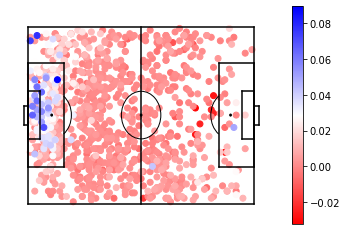

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
df_interception = df_interception.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_interception.x, df_interception.y, c=df_interception.xT_value, cmap="bwr_r")
# plt.clim(-0.06,0.06)
plt.colorbar()
plt.show()

### Transformer

In [ ]:
inp_interception_x = interception_x.reshape((interception_x.shape[0], interception_x.shape[1], 1))
TF_interception = transformer_model_reshape_ep100.predict(inp_interception_x)
TF_interception = scaler_y.inverse_transform(TF_interception)

36/36 [==============================] - 1s 20ms/step


In [ ]:
df_interception_TF = pd.DataFrame(columns=['x','y','xT_value'])
df_interception_TF['x'] = pd.Series(interception_loc[:,0])
df_interception_TF['y'] = pd.Series(interception_loc[:,1])
df_interception_TF['xT_value'] = pd.Series(TF_interception.reshape(TF_interception.shape[0]))
df_interception_TF = df_interception_TF.set_index(pd.Index(interception_index))
df_interception_TF

x      y  xT_value
53      79.80  56.44  0.000277
171     13.65  23.12 -0.006093
480     54.60  36.72 -0.005269
629      9.45  34.68  0.017196
767     60.90   5.44  0.001405
...       ...    ...       ...
481942   9.45  43.52  0.015555
482065  34.65  38.08 -0.002667
482112  49.35  17.00  0.001408
482250  13.65  35.36  0.002638
482775  28.35  46.24 -0.001337

[1124 rows x 3 columns]

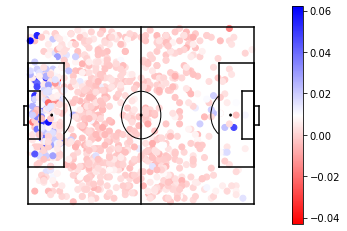

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_interception_TF = df_interception_TF.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_interception_TF.x, df_interception_TF.y, c=df_interception_TF.xT_value, cmap="bwr_r")
# plt.clim(-0.08,0.08)
plt.colorbar()
plt.show()

### LSTM

In [ ]:
inp_interception_x = interception_x.reshape((interception_x.shape[0], 1, interception_x.shape[1]))
LSTM_interception = model_LSTM.predict(inp_interception_x)
LSTM_interception = scaler_y.inverse_transform(LSTM_interception[:,0])

36/36 [==============================] - 0s 2ms/step


In [ ]:
df_interception_LSTM = pd.DataFrame(columns=['x','y','xT_value'])
df_interception_LSTM['x'] = pd.Series(interception_loc[:,0])
df_interception_LSTM['y'] = pd.Series(interception_loc[:,1])
df_interception_LSTM['xT_value'] = pd.Series(LSTM_interception.reshape(LSTM_interception.shape[0]))
df_interception_LSTM = df_interception_LSTM.set_index(pd.Index(interception_index))
df_interception_LSTM

x      y  xT_value
53      79.80  56.44 -0.000151
171     13.65  23.12  0.001178
480     54.60  36.72  0.000965
629      9.45  34.68  0.016673
767     60.90   5.44  0.001604
...       ...    ...       ...
481942   9.45  43.52  0.015073
482065  34.65  38.08  0.000995
482112  49.35  17.00  0.000983
482250  13.65  35.36  0.002705
482775  28.35  46.24  0.002668

[1124 rows x 3 columns]

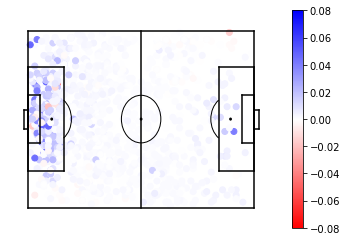

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_interception_LSTM = df_interception_LSTM.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_interception_LSTM.x, df_interception_LSTM.y, c=df_interception_LSTM.xT_value, cmap="bwr_r")
plt.clim(-0.08,0.08)
plt.colorbar()
plt.show()

### LSTM_inter

In [ ]:
inp_interception_x_inter = interception_x_inter.reshape((interception_x_inter.shape[0], 1, interception_x_inter.shape[1]))
LSTM_interception_inter = model_inter.predict(inp_interception_x_inter)
LSTM_interception_inter = scaler_y.inverse_transform(LSTM_interception_inter[:,0])

36/36 [==============================] - 0s 2ms/step


In [ ]:
df_interception_LSTM_inter = pd.DataFrame(columns=['x','y','xT_value'])
df_interception_LSTM_inter['x'] = pd.Series(interception_loc[:,0])
df_interception_LSTM_inter['y'] = pd.Series(interception_loc[:,1])
df_interception_LSTM_inter['xT_value'] = pd.Series(LSTM_interception_inter.reshape(LSTM_interception_inter.shape[0]))
df_interception_LSTM_inter = df_interception_LSTM_inter.set_index(pd.Index(interception_index))
df_interception_LSTM_inter

x      y  xT_value
53      79.80  56.44 -0.000146
171     13.65  23.12  0.001350
480     54.60  36.72  0.001326
629      9.45  34.68  0.005475
767     60.90   5.44  0.000371
...       ...    ...       ...
481942   9.45  43.52  0.005808
482065  34.65  38.08  0.000649
482112  49.35  17.00 -0.000835
482250  13.65  35.36  0.001159
482775  28.35  46.24  0.000878

[1124 rows x 3 columns]

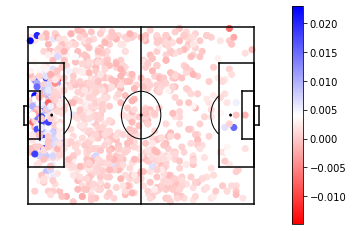

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_interception_LSTM_inter = df_interception_LSTM_inter.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_interception_LSTM_inter.x, df_interception_LSTM_inter.y, c=df_interception_LSTM_inter.xT_value, cmap="bwr_r")
# plt.clim(-0.02,0.02)
plt.colorbar()
plt.show()

### LSTM_node

In [ ]:
inp_interception_x_node = interception_x_node.reshape((interception_x_node.shape[0], 1, interception_x_node.shape[1]))
LSTM_interception_node = model_player.predict(inp_interception_x_node)
LSTM_interception_node = scaler_y.inverse_transform(LSTM_interception_node[:,0])

36/36 [==============================] - 0s 3ms/step


In [ ]:
df_interception_LSTM_node = pd.DataFrame(columns=['x','y','xT_value'])
df_interception_LSTM_node['x'] = pd.Series(interception_loc[:,0])
df_interception_LSTM_node['y'] = pd.Series(interception_loc[:,1])
df_interception_LSTM_node['xT_value'] = pd.Series(LSTM_interception_node.reshape(LSTM_interception_node.shape[0]))
df_interception_LSTM_node = df_interception_LSTM_node.set_index(pd.Index(interception_index))
df_interception_LSTM_node

x      y  xT_value
53      79.80  56.44  0.002759
171     13.65  23.12 -0.000572
480     54.60  36.72  0.002354
629      9.45  34.68  0.007767
767     60.90   5.44  0.000638
...       ...    ...       ...
481942   9.45  43.52  0.003511
482065  34.65  38.08  0.000289
482112  49.35  17.00  0.001481
482250  13.65  35.36  0.000932
482775  28.35  46.24  0.003844

[1124 rows x 3 columns]

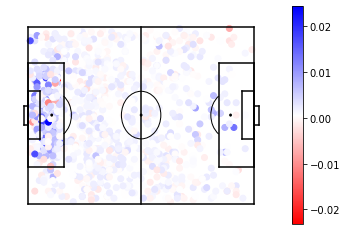

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_interception_LSTM_node = df_interception_LSTM_node.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_interception_LSTM_node.x, df_interception_LSTM_node.y, c=df_interception_LSTM_node.xT_value, cmap="bwr_r")
# plt.clim(-0.02,0.02)
plt.colorbar()
plt.show()

### LSTM_match

In [ ]:
inp_interception_x_match = interception_x_match.reshape((interception_x_match.shape[0], 1, interception_x_match.shape[1]))
LSTM_interception_match = model_match.predict(inp_interception_x_match)
LSTM_interception_match = scaler_y.inverse_transform(LSTM_interception_match[:,0])

36/36 [==============================] - 0s 2ms/step


In [ ]:
df_interception_LSTM_match = pd.DataFrame(columns=['x','y','xT_value'])
df_interception_LSTM_match['x'] = pd.Series(interception_loc[:,0])
df_interception_LSTM_match['y'] = pd.Series(interception_loc[:,1])
df_interception_LSTM_match['xT_value'] = pd.Series(LSTM_interception_match.reshape(LSTM_interception_match.shape[0]))
df_interception_LSTM_match = df_interception_LSTM_match.set_index(pd.Index(interception_index))
df_interception_LSTM_match

x      y  xT_value
53      79.80  56.44  0.000522
171     13.65  23.12  0.000814
480     54.60  36.72  0.000274
629      9.45  34.68  0.006340
767     60.90   5.44  0.000561
...       ...    ...       ...
481942   9.45  43.52  0.006045
482065  34.65  38.08  0.001091
482112  49.35  17.00  0.000215
482250  13.65  35.36  0.000244
482775  28.35  46.24  0.003606

[1124 rows x 3 columns]

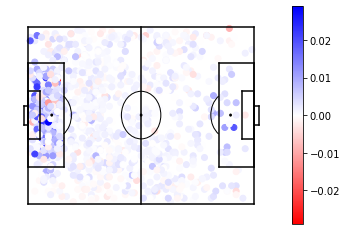

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_interception_LSTM_match = df_interception_LSTM_match.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_interception_LSTM_match.x, df_interception_LSTM_match.y, c=df_interception_LSTM_match.xT_value, cmap="bwr_r")
# plt.clim(-0.02,0.02)
plt.colorbar()
plt.show()

### LSTM_node_match

In [ ]:
inp_interception_x_node_match = interception_x_node_match.reshape((interception_x_node_match.shape[0], 1, interception_x_node_match.shape[1]))
LSTM_interception_node_match = model_node_match.predict(inp_interception_x_node_match)
LSTM_interception_node_match = scaler_y.inverse_transform(LSTM_interception_node_match[:,0])

36/36 [==============================] - 0s 2ms/step


In [ ]:
df_interception_LSTM_node_match = pd.DataFrame(columns=['x','y','xT_value'])
df_interception_LSTM_node_match['x'] = pd.Series(interception_loc[:,0])
df_interception_LSTM_node_match['y'] = pd.Series(interception_loc[:,1])
df_interception_LSTM_node_match['xT_value'] = pd.Series(LSTM_interception_node_match.reshape(LSTM_interception_node_match.shape[0]))
df_interception_LSTM_node_match = df_interception_LSTM_node_match.set_index(pd.Index(interception_index))
df_interception_LSTM_node_match

x      y  xT_value
53      79.80  56.44  0.000223
171     13.65  23.12 -0.000060
480     54.60  36.72  0.000983
629      9.45  34.68  0.008396
767     60.90   5.44 -0.000143
...       ...    ...       ...
481942   9.45  43.52  0.009299
482065  34.65  38.08  0.000363
482112  49.35  17.00  0.000186
482250  13.65  35.36  0.002486
482775  28.35  46.24  0.003069

[1124 rows x 3 columns]

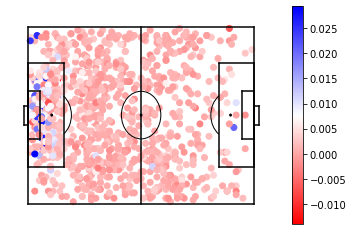

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_interception_LSTM_node_match = df_interception_LSTM_node_match.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_interception_LSTM_node_match.x, df_interception_LSTM_node_match.y, c=df_interception_LSTM_node_match.xT_value, cmap="bwr_r")
# plt.clim(-0.02,0.02)
plt.colorbar()
plt.show()

### LSTM_inter_node_match

In [ ]:
inp_interception_x_inter_node_match = interception_x_inter_node_match.reshape((interception_x_inter_node_match.shape[0], 1, interception_x_inter_node_match.shape[1]))
LSTM_interception_inter_node_match = model_inter_node_match.predict(inp_interception_x_inter_node_match)
LSTM_interception_inter_node_match = scaler_y.inverse_transform(LSTM_interception_inter_node_match[:,0])

36/36 [==============================] - 0s 3ms/step


In [ ]:
df_interception_LSTM_inter_node_match = pd.DataFrame(columns=['x','y','xT_value'])
df_interception_LSTM_inter_node_match['x'] = pd.Series(interception_loc[:,0])
df_interception_LSTM_inter_node_match['y'] = pd.Series(interception_loc[:,1])
df_interception_LSTM_inter_node_match['xT_value'] = pd.Series(LSTM_interception_inter_node_match.reshape(LSTM_interception_inter_node_match.shape[0]))
df_interception_LSTM_inter_node_match = df_interception_LSTM_inter_node_match.set_index(pd.Index(interception_index))
df_interception_LSTM_inter_node_match

x      y  xT_value
53      79.80  56.44  0.001992
171     13.65  23.12 -0.002360
480     54.60  36.72  0.000617
629      9.45  34.68  0.001108
767     60.90   5.44  0.000974
...       ...    ...       ...
481942   9.45  43.52 -0.000435
482065  34.65  38.08  0.001458
482112  49.35  17.00  0.001130
482250  13.65  35.36 -0.000105
482775  28.35  46.24  0.001901

[1124 rows x 3 columns]

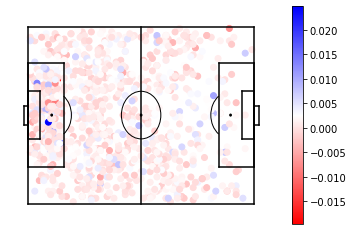

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_interception_LSTM_inter_node_match = df_interception_LSTM_inter_node_match.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_interception_LSTM_inter_node_match.x, df_interception_LSTM_inter_node_match.y, c=df_interception_LSTM_inter_node_match.xT_value, cmap="bwr_r")
# plt.clim(-0.02,0.02)
plt.colorbar()
plt.show()

## Tackle

### Original

In [ ]:
# test_tackle = model.predict(tackle_x, verbose=1)
test_tackle = MLP.predict(tackle_x)

25/25 [==============================] - 0s 2ms/step


In [ ]:
inv_test_tackle = scaler_y.inverse_transform(test_tackle)

In [ ]:
df_tackle = pd.DataFrame(columns=['x','y','xT_value'])
df_tackle['x'] = pd.Series(tackle_loc[:,0])
df_tackle['y'] = pd.Series(tackle_loc[:,1])
df_tackle['xT_value'] = pd.Series(inv_test_tackle.reshape(inv_test_tackle.shape[0]))
df_tackle = df_tackle.set_index(pd.Index(tackle_index))
df_tackle

x      y  xT_value
837     28.35  19.04  0.001291
1383    44.10  23.80 -0.002227
1838    48.30  47.60 -0.000253
2049    36.75  55.76  0.003952
2207    59.85  38.08  0.001984
...       ...    ...       ...
480268  38.85  21.08 -0.002169
480308  21.00  47.60  0.006010
480335  31.50  13.60 -0.000058
480941  59.85  21.76  0.008926
483251  36.75  32.64 -0.001790

[777 rows x 3 columns]

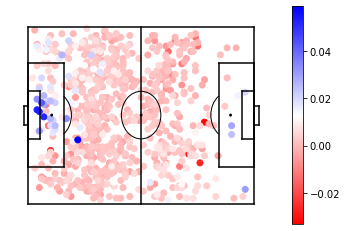

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
df_tackle = df_tackle.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_tackle.x, df_tackle.y, c=df_tackle.xT_value, cmap="bwr_r")
# plt.clim(-0.06,0.06)
plt.colorbar()
plt.show()

### Transformer

In [ ]:
inp_tackle_x = tackle_x.reshape((tackle_x.shape[0], tackle_x.shape[1], 1))
TF_tackle = transformer_model_reshape_ep100.predict(inp_tackle_x)
TF_tackle = scaler_y.inverse_transform(TF_tackle)

25/25 [==============================] - 1s 20ms/step


In [ ]:
df_tackle_TF = pd.DataFrame(columns=['x','y','xT_value'])
df_tackle_TF['x'] = pd.Series(tackle_loc[:,0])
df_tackle_TF['y'] = pd.Series(tackle_loc[:,1])
df_tackle_TF['xT_value'] = pd.Series(TF_tackle.reshape(TF_tackle.shape[0]))
df_tackle_TF = df_tackle_TF.set_index(pd.Index(tackle_index))
df_tackle_TF

x      y  xT_value
837     28.35  19.04  0.000921
1383    44.10  23.80  0.002925
1838    48.30  47.60 -0.003847
2049    36.75  55.76  0.006800
2207    59.85  38.08 -0.001457
...       ...    ...       ...
480268  38.85  21.08  0.004141
480308  21.00  47.60 -0.000773
480335  31.50  13.60 -0.000389
480941  59.85  21.76  0.003461
483251  36.75  32.64 -0.004494

[777 rows x 3 columns]

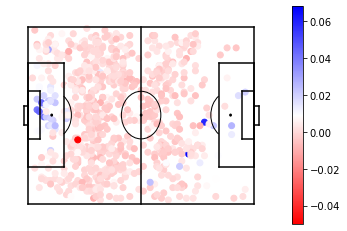

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_tackle_TF = df_tackle_TF.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_tackle_TF.x, df_tackle_TF.y, c=df_tackle_TF.xT_value, cmap="bwr_r")
# plt.clim(-0.08,0.08)
plt.colorbar()
plt.show()

### LSTM

In [ ]:
inp_tackle_x = tackle_x.reshape((tackle_x.shape[0], 1, tackle_x.shape[1]))
LSTM_tackle = model_LSTM.predict(inp_tackle_x)
LSTM_tackle = scaler_y.inverse_transform(LSTM_tackle[:,0])

25/25 [==============================] - 0s 2ms/step


In [ ]:
df_tackle_LSTM = pd.DataFrame(columns=['x','y','xT_value'])
df_tackle_LSTM['x'] = pd.Series(tackle_loc[:,0])
df_tackle_LSTM['y'] = pd.Series(tackle_loc[:,1])
df_tackle_LSTM['xT_value'] = pd.Series(LSTM_tackle.reshape(LSTM_tackle.shape[0]))
df_tackle_LSTM = df_tackle_LSTM.set_index(pd.Index(tackle_index))
df_tackle_LSTM

x      y  xT_value
837     28.35  19.04  0.000242
1383    44.10  23.80  0.001237
1838    48.30  47.60  0.001311
2049    36.75  55.76  0.002310
2207    59.85  38.08  0.000998
...       ...    ...       ...
480268  38.85  21.08  0.002040
480308  21.00  47.60  0.001944
480335  31.50  13.60  0.001743
480941  59.85  21.76  0.001402
483251  36.75  32.64  0.001633

[777 rows x 3 columns]

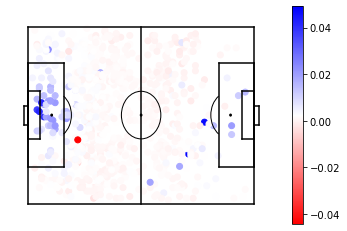

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_tackle = df_tackle.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_tackle_LSTM.x, df_tackle_LSTM.y, c=df_tackle_LSTM.xT_value, cmap="bwr_r")
# plt.clim(-0.08,0.08)
plt.colorbar()
plt.show()

### LSTM_inter

In [ ]:
inp_tackle_x_inter = tackle_x_inter.reshape((tackle_x_inter.shape[0], 1, tackle_x_inter.shape[1]))
LSTM_tackle_inter = model_inter.predict(inp_tackle_x_inter)
LSTM_tackle_inter = scaler_y.inverse_transform(LSTM_tackle_inter[:,0])

25/25 [==============================] - 0s 2ms/step


In [ ]:
df_tackle_LSTM_inter = pd.DataFrame(columns=['x','y','xT_value'])
df_tackle_LSTM_inter['x'] = pd.Series(tackle_loc[:,0])
df_tackle_LSTM_inter['y'] = pd.Series(tackle_loc[:,1])
df_tackle_LSTM_inter['xT_value'] = pd.Series(LSTM_tackle_inter.reshape(LSTM_tackle_inter.shape[0]))
df_tackle_LSTM_inter = df_tackle_LSTM_inter.set_index(pd.Index(tackle_index))
df_tackle_LSTM_inter

x      y  xT_value
837     28.35  19.04  0.000331
1383    44.10  23.80  0.001815
1838    48.30  47.60  0.001225
2049    36.75  55.76  0.000340
2207    59.85  38.08  0.000959
...       ...    ...       ...
480268  38.85  21.08  0.001213
480308  21.00  47.60  0.000281
480335  31.50  13.60  0.001834
480941  59.85  21.76  0.000340
483251  36.75  32.64  0.003224

[777 rows x 3 columns]

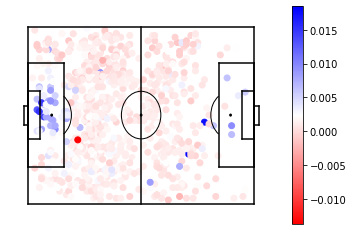

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_tackle_LSTM_inter = df_tackle_LSTM_inter.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_tackle_LSTM_inter.x, df_tackle_LSTM_inter.y, c=df_tackle_LSTM_inter.xT_value, cmap="bwr_r")
# plt.clim(-0.02,0.02)
plt.colorbar()
plt.show()

### LSTM_node

In [ ]:
inp_tackle_x_node = tackle_x_node.reshape((tackle_x_node.shape[0], 1, tackle_x_node.shape[1]))
LSTM_tackle_node = model_player.predict(inp_tackle_x_node)
LSTM_tackle_node = scaler_y.inverse_transform(LSTM_tackle_node[:,0])

25/25 [==============================] - 0s 2ms/step


In [ ]:
df_tackle_LSTM_node = pd.DataFrame(columns=['x','y','xT_value'])
df_tackle_LSTM_node['x'] = pd.Series(tackle_loc[:,0])
df_tackle_LSTM_node['y'] = pd.Series(tackle_loc[:,1])
df_tackle_LSTM_node['xT_value'] = pd.Series(LSTM_tackle_node.reshape(LSTM_tackle_node.shape[0]))
df_tackle_LSTM_node = df_tackle_LSTM_node.set_index(pd.Index(tackle_index))
df_tackle_LSTM_node

x      y  xT_value
837     28.35  19.04  0.001774
1383    44.10  23.80  0.001510
1838    48.30  47.60  0.001858
2049    36.75  55.76  0.002346
2207    59.85  38.08  0.001323
...       ...    ...       ...
480268  38.85  21.08  0.002567
480308  21.00  47.60  0.000442
480335  31.50  13.60  0.001720
480941  59.85  21.76 -0.000866
483251  36.75  32.64  0.000740

[777 rows x 3 columns]

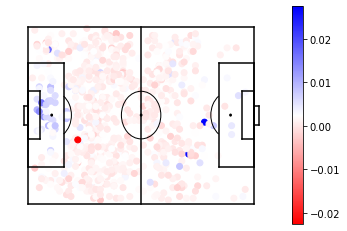

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_tackle_LSTM_node = df_tackle_LSTM_node.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_tackle_LSTM_node.x, df_tackle_LSTM_node.y, c=df_tackle_LSTM_node.xT_value, cmap="bwr_r")
# plt.clim(-0.02,0.02)
plt.colorbar()
plt.show()

### LSTM_match

In [ ]:
inp_tackle_x_match = tackle_x_match.reshape((tackle_x_match.shape[0], 1, tackle_x_match.shape[1]))
LSTM_tackle_match = model_match.predict(inp_tackle_x_match)
LSTM_tackle_match = scaler_y.inverse_transform(LSTM_tackle_match[:,0])

25/25 [==============================] - 0s 2ms/step


In [ ]:
df_tackle_LSTM_match = pd.DataFrame(columns=['x','y','xT_value'])
df_tackle_LSTM_match['x'] = pd.Series(tackle_loc[:,0])
df_tackle_LSTM_match['y'] = pd.Series(tackle_loc[:,1])
df_tackle_LSTM_match['xT_value'] = pd.Series(LSTM_tackle_match.reshape(LSTM_tackle_match.shape[0]))
df_tackle_LSTM_match = df_tackle_LSTM_match.set_index(pd.Index(tackle_index))
df_tackle_LSTM_match

x      y  xT_value
837     28.35  19.04  0.000156
1383    44.10  23.80  0.002083
1838    48.30  47.60  0.000232
2049    36.75  55.76 -0.000181
2207    59.85  38.08  0.000481
...       ...    ...       ...
480268  38.85  21.08  0.001364
480308  21.00  47.60  0.000256
480335  31.50  13.60  0.001997
480941  59.85  21.76  0.001020
483251  36.75  32.64  0.002779

[777 rows x 3 columns]

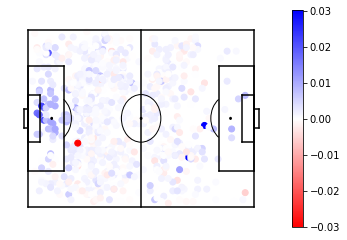

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_tackle_LSTM_match = df_tackle_LSTM_match.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_tackle_LSTM_match.x, df_tackle_LSTM_match.y, c=df_tackle_LSTM_match.xT_value, cmap="bwr_r")
# plt.clim(-0.02,0.02)
plt.colorbar()
plt.show()

### LSTM_node_match

In [ ]:
inp_tackle_x_node_match = tackle_x_node_match.reshape((tackle_x_node_match.shape[0], 1, tackle_x_node_match.shape[1]))
LSTM_tackle_node_match = model_node_match.predict(inp_tackle_x_node_match)
LSTM_tackle_node_match = scaler_y.inverse_transform(LSTM_tackle_node_match[:,0])

25/25 [==============================] - 0s 2ms/step


In [ ]:
df_tackle_LSTM_node_match = pd.DataFrame(columns=['x','y','xT_value'])
df_tackle_LSTM_node_match['x'] = pd.Series(tackle_loc[:,0])
df_tackle_LSTM_node_match['y'] = pd.Series(tackle_loc[:,1])
df_tackle_LSTM_node_match['xT_value'] = pd.Series(LSTM_tackle_node_match.reshape(LSTM_tackle_node_match.shape[0]))
df_tackle_LSTM_node_match = df_tackle_LSTM_node_match.set_index(pd.Index(tackle_index))
df_tackle_LSTM_node_match

x      y  xT_value
837     28.35  19.04  0.000210
1383    44.10  23.80  0.000950
1838    48.30  47.60  0.000482
2049    36.75  55.76  0.000513
2207    59.85  38.08 -0.000237
...       ...    ...       ...
480268  38.85  21.08  0.000934
480308  21.00  47.60 -0.000857
480335  31.50  13.60  0.001619
480941  59.85  21.76 -0.000004
483251  36.75  32.64  0.002319

[777 rows x 3 columns]

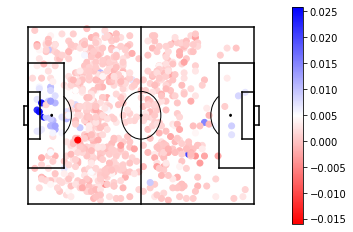

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_tackle_LSTM_node_match = df_tackle_LSTM_node_match.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_tackle_LSTM_node_match.x, df_tackle_LSTM_node_match.y, c=df_tackle_LSTM_node_match.xT_value, cmap="bwr_r")
# plt.clim(-0.02,0.02)
plt.colorbar()
plt.show()

### LSTM_inter_node_match

In [ ]:
inp_tackle_x_inter_node_match = tackle_x_inter_node_match.reshape((tackle_x_inter_node_match.shape[0], 1, tackle_x_inter_node_match.shape[1]))
LSTM_tackle_inter_node_match = model_inter_node_match.predict(inp_tackle_x_inter_node_match)
LSTM_tackle_inter_node_match = scaler_y.inverse_transform(LSTM_tackle_inter_node_match[:,0])

25/25 [==============================] - 0s 3ms/step


In [ ]:
df_tackle_LSTM_inter_node_match = pd.DataFrame(columns=['x','y','xT_value'])
df_tackle_LSTM_inter_node_match['x'] = pd.Series(tackle_loc[:,0])
df_tackle_LSTM_inter_node_match['y'] = pd.Series(tackle_loc[:,1])
df_tackle_LSTM_inter_node_match['xT_value'] = pd.Series(LSTM_tackle_inter_node_match.reshape(LSTM_tackle_inter_node_match.shape[0]))
df_tackle_LSTM_inter_node_match = df_tackle_LSTM_inter_node_match.set_index(pd.Index(tackle_index))
df_tackle_LSTM_inter_node_match

x      y  xT_value
837     28.35  19.04 -0.000004
1383    44.10  23.80 -0.000966
1838    48.30  47.60  0.002401
2049    36.75  55.76  0.001973
2207    59.85  38.08  0.002012
...       ...    ...       ...
480268  38.85  21.08  0.000090
480308  21.00  47.60  0.001146
480335  31.50  13.60  0.000979
480941  59.85  21.76 -0.000672
483251  36.75  32.64  0.001270

[777 rows x 3 columns]

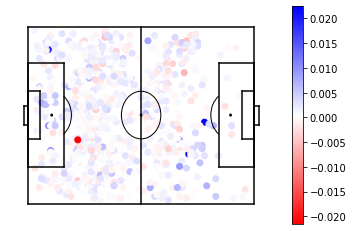

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_tackle_LSTM_inter_node_match = df_tackle_LSTM_inter_node_match.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_tackle_LSTM_inter_node_match.x, df_tackle_LSTM_inter_node_match.y, c=df_tackle_LSTM_inter_node_match.xT_value, cmap="bwr_r")
# plt.clim(-0.02,0.02)
plt.colorbar()
plt.show()

## Clearance

### Original

In [ ]:
# test_clearance = model.predict(clearance_x, verbose=1)
test_clearance = MLP.predict(clearance_x)

6/6 [==============================] - 0s 3ms/step


In [ ]:
inv_test_clearance = scaler_y.inverse_transform(test_clearance)

In [ ]:
df_clearance = pd.DataFrame(columns=['x','y','xT_value'])
df_clearance['x'] = pd.Series(clearance_loc[:,0])
df_clearance['y'] = pd.Series(clearance_loc[:,1])
df_clearance['xT_value'] = pd.Series(inv_test_clearance.reshape(inv_test_clearance.shape[0]))
df_clearance = df_clearance.set_index(pd.Index(clearance_index))
df_clearance

x      y  xT_value
3304    12.60  23.80  0.041434
4676    19.95  34.68  0.010294
5816     8.40  39.44  0.024288
7614     4.20  59.16  0.006503
10411    7.35  28.56  0.038162
...       ...    ...       ...
474420   8.40  32.64 -0.004600
474685  12.60  37.40 -0.007693
477237  23.10  31.28 -0.002395
478517   9.45  29.92 -0.005322
481566   9.45  34.68  0.057736

[189 rows x 3 columns]

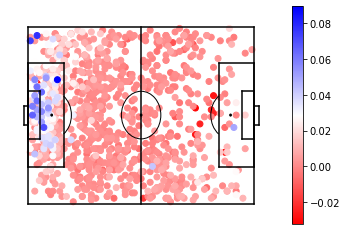

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
df_interception = df_interception.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_interception.x, df_interception.y, c=df_interception.xT_value, cmap="bwr_r")
# plt.clim(-0.06,0.06)
plt.colorbar()
plt.show()

### Transformer

In [ ]:
inp_clearance_x = clearance_x.reshape((clearance_x.shape[0], clearance_x.shape[1], 1))
TF_clearance = transformer_model_reshape_ep100.predict(inp_clearance_x)
TF_clearance = scaler_y.inverse_transform(TF_clearance)

6/6 [==============================] - 0s 21ms/step


In [ ]:
df_clearance_TF = pd.DataFrame(columns=['x','y','xT_value'])
df_clearance_TF['x'] = pd.Series(clearance_loc[:,0])
df_clearance_TF['y'] = pd.Series(clearance_loc[:,1])
df_clearance_TF['xT_value'] = pd.Series(TF_clearance.reshape(TF_clearance.shape[0]))
df_clearance_TF = df_clearance_TF.set_index(pd.Index(clearance_index))
df_clearance_TF

x      y  xT_value
3304    12.60  23.80 -0.017955
4676    19.95  34.68  0.008294
5816     8.40  39.44  0.020117
7614     4.20  59.16  0.003687
10411    7.35  28.56  0.025776
...       ...    ...       ...
474420   8.40  32.64  0.027071
474685  12.60  37.40  0.010660
477237  23.10  31.28 -0.003182
478517   9.45  29.92  0.002434
481566   9.45  34.68  0.042596

[189 rows x 3 columns]

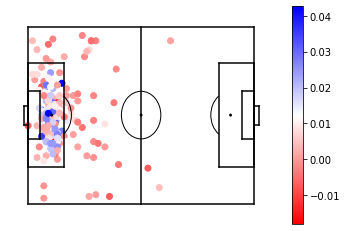

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_clearance_TF = df_clearance_TF.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_clearance_TF.x, df_clearance_TF.y, c=df_clearance_TF.xT_value, cmap="bwr_r")
# plt.clim(-0.08,0.08)
plt.colorbar()
plt.show()

### LSTM

In [ ]:
inp_clearance_x = clearance_x.reshape((clearance_x.shape[0], 1, clearance_x.shape[1]))
LSTM_clearance = model_LSTM.predict(inp_clearance_x)
LSTM_clearance = scaler_y.inverse_transform(LSTM_clearance[:,0])

6/6 [==============================] - 0s 5ms/step


In [ ]:
df_clearance_LSTM = pd.DataFrame(columns=['x','y','xT_value'])
df_clearance_LSTM['x'] = pd.Series(clearance_loc[:,0])
df_clearance_LSTM['y'] = pd.Series(clearance_loc[:,1])
df_clearance_LSTM['xT_value'] = pd.Series(LSTM_clearance.reshape(LSTM_clearance.shape[0]))
df_clearance_LSTM = df_clearance_LSTM.set_index(pd.Index(clearance_index))
df_clearance_LSTM

x      y  xT_value
3304    12.60  23.80 -0.009411
4676    19.95  34.68  0.004459
5816     8.40  39.44  0.020234
7614     4.20  59.16  0.000588
10411    7.35  28.56  0.021112
...       ...    ...       ...
474420   8.40  32.64  0.022189
474685  12.60  37.40  0.010274
477237  23.10  31.28  0.002404
478517   9.45  29.92 -0.000113
481566   9.45  34.68  0.040100

[189 rows x 3 columns]

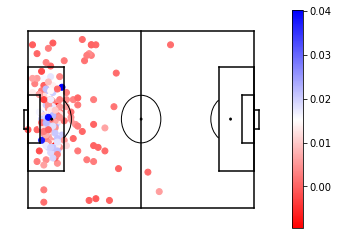

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_clearance_LSTM = df_clearance_LSTM.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_clearance_LSTM.x, df_clearance_LSTM.y, c=df_clearance_LSTM.xT_value, cmap="bwr_r")
# plt.clim(-0.08,0.08)
plt.colorbar()
plt.show()

### LSTM_inter

In [ ]:
inp_clearance_x_inter = clearance_x_inter.reshape((clearance_x_inter.shape[0], 1, clearance_x_inter.shape[1]))
LSTM_clearance_inter = model_inter.predict(inp_clearance_x_inter)
LSTM_clearance_inter = scaler_y.inverse_transform(LSTM_clearance_inter[:,0])

6/6 [==============================] - 0s 3ms/step


In [ ]:
df_clearance_LSTM_inter = pd.DataFrame(columns=['x','y','xT_value'])
df_clearance_LSTM_inter['x'] = pd.Series(clearance_loc[:,0])
df_clearance_LSTM_inter['y'] = pd.Series(clearance_loc[:,1])
df_clearance_LSTM_inter['xT_value'] = pd.Series(LSTM_clearance_inter.reshape(LSTM_clearance_inter.shape[0]))
df_clearance_LSTM_inter = df_clearance_LSTM_inter.set_index(pd.Index(clearance_index))
df_clearance_LSTM_inter

x      y  xT_value
3304    12.60  23.80 -0.000057
4676    19.95  34.68  0.001441
5816     8.40  39.44  0.007448
7614     4.20  59.16 -0.000720
10411    7.35  28.56  0.007007
...       ...    ...       ...
474420   8.40  32.64  0.008187
474685  12.60  37.40  0.003486
477237  23.10  31.28  0.001516
478517   9.45  29.92  0.001419
481566   9.45  34.68  0.014916

[189 rows x 3 columns]

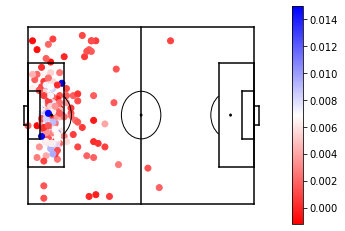

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_clearance_LSTM_inter = df_clearance_LSTM_inter.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_clearance_LSTM_inter.x, df_clearance_LSTM_inter.y, c=df_clearance_LSTM_inter.xT_value, cmap="bwr_r")
# plt.clim(-0.02,0.02)
plt.colorbar()
plt.show()

### LSTM_node

In [ ]:
inp_clearance_x_node = clearance_x_node.reshape((clearance_x_node.shape[0], 1, clearance_x_node.shape[1]))
LSTM_clearance_node = model_player.predict(inp_clearance_x_node)
LSTM_clearance_node = scaler_y.inverse_transform(LSTM_clearance_node[:,0])

6/6 [==============================] - 0s 3ms/step


In [ ]:
df_clearance_LSTM_node = pd.DataFrame(columns=['x','y','xT_value'])
df_clearance_LSTM_node['x'] = pd.Series(clearance_loc[:,0])
df_clearance_LSTM_node['y'] = pd.Series(clearance_loc[:,1])
df_clearance_LSTM_node['xT_value'] = pd.Series(LSTM_clearance_node.reshape(LSTM_clearance_node.shape[0]))
df_clearance_LSTM_node = df_clearance_LSTM_node.set_index(pd.Index(clearance_index))
df_clearance_LSTM_node

x      y  xT_value
3304    12.60  23.80 -0.008300
4676    19.95  34.68  0.002526
5816     8.40  39.44  0.004370
7614     4.20  59.16  0.000632
10411    7.35  28.56  0.007113
...       ...    ...       ...
474420   8.40  32.64  0.009069
474685  12.60  37.40  0.006327
477237  23.10  31.28  0.001445
478517   9.45  29.92  0.000722
481566   9.45  34.68  0.009636

[189 rows x 3 columns]

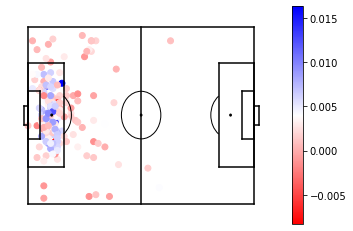

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_clearance_LSTM_node = df_clearance_LSTM_node.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_clearance_LSTM_node.x, df_clearance_LSTM_node.y, c=df_clearance_LSTM_node.xT_value, cmap="bwr_r")
# plt.clim(-0.02,0.02)
plt.colorbar()
plt.show()

### LSTM_match

In [ ]:
inp_clearance_x_match = clearance_x_match.reshape((clearance_x_match.shape[0], 1, clearance_x_match.shape[1]))
LSTM_clearance_match = model_match.predict(inp_clearance_x_match)
LSTM_clearance_match = scaler_y.inverse_transform(LSTM_clearance_match[:,0])

6/6 [==============================] - 0s 3ms/step


In [ ]:
df_clearance_LSTM_match = pd.DataFrame(columns=['x','y','xT_value'])
df_clearance_LSTM_match['x'] = pd.Series(clearance_loc[:,0])
df_clearance_LSTM_match['y'] = pd.Series(clearance_loc[:,1])
df_clearance_LSTM_match['xT_value'] = pd.Series(LSTM_clearance_match.reshape(LSTM_clearance_match.shape[0]))
df_clearance_LSTM_match = df_clearance_LSTM_match.set_index(pd.Index(clearance_index))
df_clearance_LSTM_match

x      y  xT_value
3304    12.60  23.80 -0.007004
4676    19.95  34.68  0.001456
5816     8.40  39.44  0.008954
7614     4.20  59.16 -0.000571
10411    7.35  28.56  0.010105
...       ...    ...       ...
474420   8.40  32.64  0.012322
474685  12.60  37.40  0.006037
477237  23.10  31.28  0.002540
478517   9.45  29.92 -0.000510
481566   9.45  34.68  0.018997

[189 rows x 3 columns]

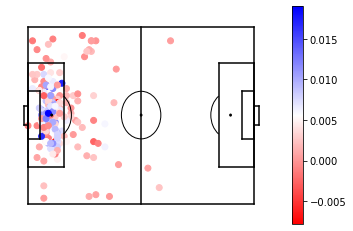

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_clearance_LSTM_match = df_clearance_LSTM_match.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_clearance_LSTM_match.x, df_clearance_LSTM_match.y, c=df_clearance_LSTM_match.xT_value, cmap="bwr_r")
# plt.clim(-0.02,0.02)
plt.colorbar()
plt.show()

### LSTM_node_match

In [ ]:
inp_clearance_x_node_match = clearance_x_node_match.reshape((clearance_x_node_match.shape[0], 1, clearance_x_node_match.shape[1]))
LSTM_clearance_node_match = model_node_match.predict(inp_clearance_x_node_match)
LSTM_clearance_node_match = scaler_y.inverse_transform(LSTM_clearance_node_match[:,0])

6/6 [==============================] - 0s 3ms/step


In [ ]:
df_clearance_LSTM_node_match = pd.DataFrame(columns=['x','y','xT_value'])
df_clearance_LSTM_node_match['x'] = pd.Series(clearance_loc[:,0])
df_clearance_LSTM_node_match['y'] = pd.Series(clearance_loc[:,1])
df_clearance_LSTM_node_match['xT_value'] = pd.Series(LSTM_clearance_node_match.reshape(LSTM_clearance_node_match.shape[0]))
df_clearance_LSTM_node_match = df_clearance_LSTM_node_match.set_index(pd.Index(clearance_index))
df_clearance_LSTM_node_match

x      y  xT_value
3304    12.60  23.80 -0.003667
4676    19.95  34.68  0.002497
5816     8.40  39.44  0.009097
7614     4.20  59.16  0.001058
10411    7.35  28.56  0.010181
...       ...    ...       ...
474420   8.40  32.64  0.010943
474685  12.60  37.40  0.002911
477237  23.10  31.28 -0.000564
478517   9.45  29.92  0.001292
481566   9.45  34.68  0.021549

[189 rows x 3 columns]

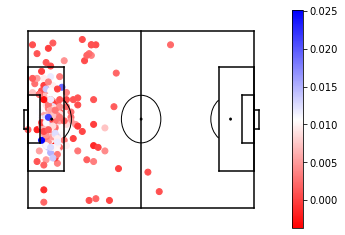

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_clearance_LSTM_node_match = df_clearance_LSTM_node_match.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_clearance_LSTM_node_match.x, df_clearance_LSTM_node_match.y, c=df_clearance_LSTM_node_match.xT_value, cmap="bwr_r")
# plt.clim(-0.02,0.02)
plt.colorbar()
plt.show()

### LSTM_inter_node_match

In [ ]:
inp_clearance_x_inter_node_match = clearance_x_inter_node_match.reshape((clearance_x_inter_node_match.shape[0], 1, clearance_x_inter_node_match.shape[1]))
LSTM_clearance_inter_node_match = model_inter_node_match.predict(inp_clearance_x_inter_node_match)
LSTM_clearance_inter_node_match = scaler_y.inverse_transform(LSTM_clearance_inter_node_match[:,0])

6/6 [==============================] - 0s 3ms/step


In [ ]:
df_clearance_LSTM_inter_node_match = pd.DataFrame(columns=['x','y','xT_value'])
df_clearance_LSTM_inter_node_match['x'] = pd.Series(clearance_loc[:,0])
df_clearance_LSTM_inter_node_match['y'] = pd.Series(clearance_loc[:,1])
df_clearance_LSTM_inter_node_match['xT_value'] = pd.Series(LSTM_clearance_inter_node_match.reshape(LSTM_clearance_inter_node_match.shape[0]))
df_clearance_LSTM_inter_node_match = df_clearance_LSTM_inter_node_match.set_index(pd.Index(clearance_index))
df_clearance_LSTM_inter_node_match

x      y  xT_value
3304    12.60  23.80 -0.008352
4676    19.95  34.68  0.001376
5816     8.40  39.44  0.002136
7614     4.20  59.16  0.001121
10411    7.35  28.56  0.001782
...       ...    ...       ...
474420   8.40  32.64  0.008816
474685  12.60  37.40  0.006059
477237  23.10  31.28  0.002244
478517   9.45  29.92  0.001432
481566   9.45  34.68  0.000945

[189 rows x 3 columns]

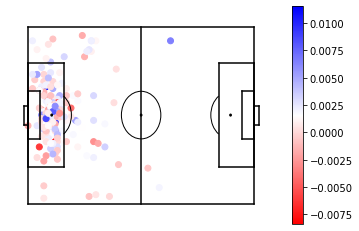

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_clearance_LSTM_inter_node_match = df_clearance_LSTM_inter_node_match.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(df_clearance_LSTM_inter_node_match.x, df_clearance_LSTM_inter_node_match.y, c=df_clearance_LSTM_inter_node_match.xT_value, cmap="bwr_r")
# plt.clim(-0.02,0.02)
plt.colorbar()
plt.show()

# Player Ranking

In [ ]:
players = pd.read_json(os.path.join(datafolder, "players.json"))

In [ ]:
teams = pd.read_json(os.path.join(datafolder, "teams.json"))

In [ ]:
teams

city                   name   wyId  \
0    Newcastle upon Tyne       Newcastle United   1613   
1                   Vigo          Celta de Vigo    692   
2              Barcelona               Espanyol    691   
3        Vitoria-Gasteiz  Deportivo Alav\u00e9s    696   
4               Valencia                Levante    695   
..                   ...                    ...    ...   
137            Las Rozas                  Spain   1598   
138              Beograd                 Serbia  17322   
139                 Bern            Switzerland   6697   
140             Warszawa                 Poland  13869   
141                Abuja                Nigeria  16823   

                     officialName  \
0             Newcastle United FC   
1         Real Club Celta de Vigo   
2    Reial Club Deportiu Espanyol   
3           Deportivo Alav\u00e9s   
4                      Levante UD   
..                            ...   
137                         Spain   
138                        Serbia   
139                   Switzerland   
140                        Poland   
141                       Nigeria   

                                                  area      type  
0    {'name': 'England', 'id': '0', 'alpha3code': '...      club  
1    {'name': 'Spain', 'id': '724', 'alpha3code': '...      club  
2    {'name': 'Spain', 'id': '724', 'alpha3code': '...      club  
3    {'name': 'Spain', 'id': '724', 'alpha3code': '...      club  
4    {'name': 'Spain', 'id': '724', 'alpha3code': '...      club  
..                                                 ...       ...  
137  {'name': 'Spain', 'id': 724, 'alpha3code': 'ES...  national  
138  {'name': 'Serbia', 'id': 688, 'alpha3code': 'S...  national  
139  {'name': 'Switzerland', 'id': 756, 'alpha3code...  national  
140  {'name': 'Poland', 'id': 616, 'alpha3code': 'P...  national  
141  {'name': 'Nigeria', 'id': 566, 'alpha3code': '...  national  

[142 rows x 6 columns]

In [ ]:
role_ls = []
for i in range(len(players)):
  role_ls.append(players['role'].to_dict()[i]['name'])
players['roleName'] = role_ls

In [ ]:
players = players.set_index('wyId')

## Combine DAxT with the original dataset

In [1]:
A['I_V'] = df_interception['xT_value']
A['T_V'] = df_tackle['xT_value']
A['CxT'] = df_clearance['xT_value']
# A['xT_value'] = mov_actions['xT_value']

In [ ]:
final_score = A.groupby("player_id", sort=False, as_index = False).apply(lambda x:(((x.I_V.sum() + x.T_V.sum() + x.CxT.sum()) / 3) + x.xT_value.sum()) / 4).rename(columns={None:'score'})
# final_score = A.groupby("player_id", sort=False, as_index = False).apply(lambda x:(((x.I_V.sum() + x.T_V.sum() + x.CxT.sum())) + x.xT_value.sum()) / 4).rename(columns={None:'score'})
final_score

player_id     score
0         9637  1.050413
1         8351  0.304991
2         9285  0.965867
3       239411  0.069724
4       245813  0.095638
..         ...       ...
509     297258 -0.013280
510     227756 -0.006830
511      20450  0.006556
512     447254  0.000535
513     134708  0.000294

[514 rows x 2 columns]

In [ ]:
final_score = final_score.merge(players[['firstName','middleName','lastName','currentTeamId','roleName']], left_on=['player_id'], right_on = ['wyId'], how='left')

In [ ]:
final_score

player_id     score firstName middleName               lastName  \
0         9637  1.050413    Joshua                              King   
1         8351  0.304991    Andrew                            Surman   
2         9285  0.965867   Charlie                           Daniels   
3       239411  0.069724    Tyrone                             Mings   
4       245813  0.095638       Lys                           Mousset   
..         ...       ...       ...        ...                    ...   
509     297258 -0.013280    Sullay                            Kaikai   
510     227756 -0.006830   Jeremie                              Boga   
511      20450  0.006556     Bojan             Krk\u00edc P\u00e9rez   
512     447254  0.000535    Rekeem                            Harper   
513     134708  0.000294    Divock                       Okoth Origi   

    currentTeamId    roleName  
0            1659     Forward  
1            1659  Midfielder  
2            1659    Defender  
3            1659    Defender  
4            1659     Forward  
..            ...         ...  
509          1628  Midfielder  
510          3315     Forward  
511           696     Forward  
512          1627  Midfielder  
513          2451     Forward  

[514 rows x 7 columns]

In [ ]:
defenders = final_score[final_score['roleName']=='Defender']

In [ ]:
defenders

player_id     score         firstName middleName           lastName  \
2         9285  0.965867           Charlie                       Daniels   
3       239411  0.069724            Tyrone                         Mings   
5         9433  0.388918            James                      Tarkowski   
6         8643  1.020186           Matthew                        Lowton   
8         9277  0.467888             Steve                          Cook   
..         ...       ...               ...        ...                ...   
496       8126  0.222293  Jos\u00e9 Miguel                da Rocha Fonte   
498      15301 -0.000850               Uwe                H\u00fcnemeier   
502       3557  0.128867        Jes\u00fas             G\u00e1mez Duarte   
503       9622  0.051616              Liam                      Rosenior   
506       8272  0.048291            Younes                        Kaboul   

    currentTeamId  roleName  
2            1659  Defender  
3            1659  Defender  
5            1646  Defender  
6            1646  Defender  
8            1659  Defender  
..            ...       ...  
496          3776  Defender  
498          2491  Defender  
502          null  Defender  
503          null  Defender  
506          1644  Defender  

[177 rows x 7 columns]

In [ ]:
defenders.sort_values("score", ascending=False).head(15) # No left-to-right conversion

player_id     score                 firstName middleName  \
154      25553  2.322122                C\u00e9sar              
120       7939  1.937622                   Ashley               
333       9279  1.653093                     Simon              
329       8277  1.625037                      Kyle              
285       7938  1.436201              Luis Antonio              
172      70389  1.408302       C\u00e9dric Ricardo              
327      70086  1.380001  Nicol\u00e1s Hern\u00e1n              
97      346101  1.307312                     Trent              
180       7885  1.277847                      Ryan              
215       8192  1.275945                    Martin              
299     136441  1.274896                       Ben              
18        8433  1.272475                   Stephen              
297       8945  1.241557                    Kieran              
65      167145  1.233491               H\u00e9ctor              
274       8313  1.193095              Pablo Javier              

                 lastName currentTeamId  roleName  
154     Azpilicueta Tanco          1610  Defender  
120                 Young          1611  Defender  
333               Francis          1659  Defender  
329                Walker          1625  Defender  
285     Valencia Mosquera          1611  Defender  
172          Alves Soares          1619  Defender  
327              Otamendi          1625  Defender  
97       Alexander-Arnold          1612  Defender  
180              Bertrand          1619  Defender  
215                Olsson         10531  Defender  
299                Davies          1624  Defender  
18                   Ward          1646  Defender  
297              Trippier          1624  Defender  
65   Beller\u00edn Moruno          1609  Defender  
274        Zabaleta Girod          1633  Defender

In [ ]:
rank = defenders['score'].rank(ascending=False)
defenders['rank'] = rank
defenders.sort_values("score", ascending=False)[['rank','firstName','lastName','score']].head(15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


rank                 firstName              lastName     score
154   1.0                C\u00e9sar     Azpilicueta Tanco  2.322122
120   2.0                   Ashley                  Young  1.937622
333   3.0                     Simon               Francis  1.653093
329   4.0                      Kyle                Walker  1.625037
285   5.0              Luis Antonio     Valencia Mosquera  1.436201
172   6.0       C\u00e9dric Ricardo          Alves Soares  1.408302
327   7.0  Nicol\u00e1s Hern\u00e1n              Otamendi  1.380001
97    8.0                     Trent      Alexander-Arnold  1.307312
180   9.0                      Ryan              Bertrand  1.277847
215  10.0                    Martin                Olsson  1.275945
299  11.0                       Ben                Davies  1.274896
18   12.0                   Stephen                  Ward  1.272475
297  13.0                    Kieran              Trippier  1.241557
65   14.0               H\u00e9ctor  Beller\u00edn Moruno  1.233491
274  15.0              Pablo Javier        Zabaleta Girod  1.193095

In [ ]:
rank = defenders['score'].rank(ascending=False)
defenders['rank'] = rank

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
defenders.sort_values("score", ascending=False)

player_id     score     firstName middleName           lastName  \
154      25553  2.322122    C\u00e9sar             Azpilicueta Tanco   
120       7939  1.937622       Ashley                          Young   
333       9279  1.653093         Simon                       Francis   
329       8277  1.625037          Kyle                        Walker   
285       7938  1.436201  Luis Antonio             Valencia Mosquera   
..         ...       ...           ...        ...                ...   
437      15474  0.001768       Michael                        Hefele   
481     415747  0.001632          Jack                       Simpson   
335      21333  0.001267         Yohan                    Benalouane   
168      26109 -0.000551      Massadio                  Ha\u00efdara   
498      15301 -0.000850           Uwe                H\u00fcnemeier   

    currentTeamId  roleName   rank  
154          1610  Defender    1.0  
120          1611  Defender    2.0  
333          1659  Defender    3.0  
329          1625  Defender    4.0  
285          1611  Defender    5.0  
..            ...       ...    ...  
437          1642  Defender  173.0  
481          1659  Defender  174.0  
335          1631  Defender  175.0  
168          3773  Defender  176.0  
498          2491  Defender  177.0  

[177 rows x 8 columns]

## Combine TF DAxT with the original dataset

In [ ]:
A['I_V'] = df_interception_TF['xT_value']
A['T_V'] = df_tackle_TF['xT_value']
A['CxT'] = df_clearance_TF['xT_value']
# A['xT_value'] = mov_actions['xT_value']

In [ ]:
# final_score = A.groupby("player_id", sort=False, as_index = False).apply(lambda x:(((x.I_V.sum() + x.T_V.sum() + x.CxT.sum()) / 3) + x.xT_value.sum()) / 4).rename(columns={None:'score'})
final_score = A.groupby("player_id", sort=False, as_index = False).apply(lambda x:(((x.I_V.sum() + x.T_V.sum() + x.CxT.sum())) + x.xT_value.sum()) / 4).rename(columns={None:'score'})
final_score

player_id     score
0         9637  1.049020
1         8351  0.317336
2         9285  0.969131
3       239411  0.069724
4       245813  0.095333
..         ...       ...
509     297258 -0.013280
510     227756 -0.006830
511      20450  0.006556
512     447254  0.000535
513     134708  0.000294

[514 rows x 2 columns]

In [ ]:
final_score = final_score.merge(players[['firstName','middleName','lastName','currentTeamId','roleName']], left_on=['player_id'], right_on = ['wyId'], how='left')

In [ ]:
final_score

player_id     score firstName middleName               lastName  \
0         9637  1.049020    Joshua                              King   
1         8351  0.317336    Andrew                            Surman   
2         9285  0.969131   Charlie                           Daniels   
3       239411  0.069724    Tyrone                             Mings   
4       245813  0.095333       Lys                           Mousset   
..         ...       ...       ...        ...                    ...   
509     297258 -0.013280    Sullay                            Kaikai   
510     227756 -0.006830   Jeremie                              Boga   
511      20450  0.006556     Bojan             Krk\u00edc P\u00e9rez   
512     447254  0.000535    Rekeem                            Harper   
513     134708  0.000294    Divock                       Okoth Origi   

    currentTeamId    roleName  
0            1659     Forward  
1            1659  Midfielder  
2            1659    Defender  
3            1659    Defender  
4            1659     Forward  
..            ...         ...  
509          1628  Midfielder  
510          3315     Forward  
511           696     Forward  
512          1627  Midfielder  
513          2451     Forward  

[514 rows x 7 columns]

In [ ]:
defenders = final_score[final_score['roleName']=='Defender']

In [ ]:
defenders

player_id     score         firstName middleName           lastName  \
2         9285  0.969131           Charlie                       Daniels   
3       239411  0.069724            Tyrone                         Mings   
5         9433  0.410363            James                      Tarkowski   
6         8643  1.018998           Matthew                        Lowton   
8         9277  0.476884             Steve                          Cook   
..         ...       ...               ...        ...                ...   
496       8126  0.218905  Jos\u00e9 Miguel                da Rocha Fonte   
498      15301 -0.000850               Uwe                H\u00fcnemeier   
502       3557  0.128867        Jes\u00fas             G\u00e1mez Duarte   
503       9622  0.051616              Liam                      Rosenior   
506       8272  0.048291            Younes                        Kaboul   

    currentTeamId  roleName  
2            1659  Defender  
3            1659  Defender  
5            1646  Defender  
6            1646  Defender  
8            1659  Defender  
..            ...       ...  
496          3776  Defender  
498          2491  Defender  
502          null  Defender  
503          null  Defender  
506          1644  Defender  

[177 rows x 7 columns]

In [ ]:
defenders.sort_values("score", ascending=False).head(15) # No left-to-right conversion

player_id     score                 firstName middleName  \
154      25553  2.329984                C\u00e9sar              
120       7939  1.937945                   Ashley               
333       9279  1.658661                     Simon              
329       8277  1.629164                      Kyle              
285       7938  1.445846              Luis Antonio              
172      70389  1.410882       C\u00e9dric Ricardo              
327      70086  1.399546  Nicol\u00e1s Hern\u00e1n              
97      346101  1.312018                     Trent              
215       8192  1.299242                    Martin              
180       7885  1.290249                      Ryan              
299     136441  1.278824                       Ben              
18        8433  1.274698                   Stephen              
297       8945  1.248657                    Kieran              
65      167145  1.234697               H\u00e9ctor              
274       8313  1.193015              Pablo Javier              

                 lastName currentTeamId  roleName  
154     Azpilicueta Tanco          1610  Defender  
120                 Young          1611  Defender  
333               Francis          1659  Defender  
329                Walker          1625  Defender  
285     Valencia Mosquera          1611  Defender  
172          Alves Soares          1619  Defender  
327              Otamendi          1625  Defender  
97       Alexander-Arnold          1612  Defender  
215                Olsson         10531  Defender  
180              Bertrand          1619  Defender  
299                Davies          1624  Defender  
18                   Ward          1646  Defender  
297              Trippier          1624  Defender  
65   Beller\u00edn Moruno          1609  Defender  
274        Zabaleta Girod          1633  Defender

In [ ]:
rank = defenders['score'].rank(ascending=False)
defenders['rank'] = rank
defenders.sort_values("score", ascending=False)[['rank','firstName','lastName','score']].head(15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


rank                 firstName              lastName     score
154   1.0                C\u00e9sar     Azpilicueta Tanco  2.329984
120   2.0                   Ashley                  Young  1.937945
333   3.0                     Simon               Francis  1.658661
329   4.0                      Kyle                Walker  1.629164
285   5.0              Luis Antonio     Valencia Mosquera  1.445846
172   6.0       C\u00e9dric Ricardo          Alves Soares  1.410882
327   7.0  Nicol\u00e1s Hern\u00e1n              Otamendi  1.399546
97    8.0                     Trent      Alexander-Arnold  1.312018
215   9.0                    Martin                Olsson  1.299242
180  10.0                      Ryan              Bertrand  1.290249
299  11.0                       Ben                Davies  1.278824
18   12.0                   Stephen                  Ward  1.274698
297  13.0                    Kieran              Trippier  1.248657
65   14.0               H\u00e9ctor  Beller\u00edn Moruno  1.234697
274  15.0              Pablo Javier        Zabaleta Girod  1.193015

In [ ]:
rank = defenders['score'].rank(ascending=False)
defenders['rank'] = rank

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
defenders.sort_values("score", ascending=False)

player_id     score     firstName middleName           lastName  \
154      25553  2.329984    C\u00e9sar             Azpilicueta Tanco   
120       7939  1.937945       Ashley                          Young   
333       9279  1.658661         Simon                       Francis   
329       8277  1.629164          Kyle                        Walker   
285       7938  1.445846  Luis Antonio             Valencia Mosquera   
..         ...       ...           ...        ...                ...   
437      15474  0.001768       Michael                        Hefele   
481     415747  0.001632          Jack                       Simpson   
335      21333  0.001267         Yohan                    Benalouane   
168      26109 -0.000551      Massadio                  Ha\u00efdara   
498      15301 -0.000850           Uwe                H\u00fcnemeier   

    currentTeamId  roleName   rank  
154          1610  Defender    1.0  
120          1611  Defender    2.0  
333          1659  Defender    3.0  
329          1625  Defender    4.0  
285          1611  Defender    5.0  
..            ...       ...    ...  
437          1642  Defender  173.0  
481          1659  Defender  174.0  
335          1631  Defender  175.0  
168          3773  Defender  176.0  
498          2491  Defender  177.0  

[177 rows x 8 columns]

## Combine LSTM DAxT with the original dataset

In [ ]:
A['I_V'] = df_interception_LSTM['xT_value']
A['T_V'] = df_tackle_LSTM['xT_value']
A['CxT'] = df_clearance_LSTM['xT_value']
# A['xT_value'] = mov_actions['xT_value']

In [ ]:
final_score = A.groupby("player_id", sort=False, as_index = False).apply(lambda x:(((x.I_V.sum() + x.T_V.sum() + x.CxT.sum()) / 3) + x.xT_value.sum()) / 4).rename(columns={None:'score'})
# final_score = A.groupby("player_id", sort=False, as_index = False).apply(lambda x:(((x.I_V.sum() + x.T_V.sum() + x.CxT.sum())) + x.xT_value.sum()) / 4).rename(columns={None:'score'})
final_score

player_id     score
0         9637  1.050842
1         8351  0.309135
2         9285  0.963800
3       239411  0.069724
4       245813  0.095275
..         ...       ...
509     297258 -0.013280
510     227756 -0.006830
511      20450  0.006556
512     447254  0.000535
513     134708  0.000294

[514 rows x 2 columns]

In [ ]:
final_score = final_score.merge(players[['firstName','middleName','lastName','currentTeamId','roleName']], left_on=['player_id'], right_on = ['wyId'], how='left')

In [ ]:
final_score

player_id     score firstName middleName               lastName  \
0         9637  1.050842    Joshua                              King   
1         8351  0.309135    Andrew                            Surman   
2         9285  0.963800   Charlie                           Daniels   
3       239411  0.069724    Tyrone                             Mings   
4       245813  0.095275       Lys                           Mousset   
..         ...       ...       ...        ...                    ...   
509     297258 -0.013280    Sullay                            Kaikai   
510     227756 -0.006830   Jeremie                              Boga   
511      20450  0.006556     Bojan             Krk\u00edc P\u00e9rez   
512     447254  0.000535    Rekeem                            Harper   
513     134708  0.000294    Divock                       Okoth Origi   

    currentTeamId    roleName  
0            1659     Forward  
1            1659  Midfielder  
2            1659    Defender  
3            1659    Defender  
4            1659     Forward  
..            ...         ...  
509          1628  Midfielder  
510          3315     Forward  
511           696     Forward  
512          1627  Midfielder  
513          2451     Forward  

[514 rows x 7 columns]

In [ ]:
defenders = final_score[final_score['roleName']=='Defender']

In [ ]:
defenders

player_id     score         firstName middleName           lastName  \
2         9285  0.963800           Charlie                       Daniels   
3       239411  0.069724            Tyrone                         Mings   
5         9433  0.393382            James                      Tarkowski   
6         8643  1.017403           Matthew                        Lowton   
8         9277  0.469634             Steve                          Cook   
..         ...       ...               ...        ...                ...   
496       8126  0.221227  Jos\u00e9 Miguel                da Rocha Fonte   
498      15301 -0.000850               Uwe                H\u00fcnemeier   
502       3557  0.128867        Jes\u00fas             G\u00e1mez Duarte   
503       9622  0.051616              Liam                      Rosenior   
506       8272  0.048291            Younes                        Kaboul   

    currentTeamId  roleName  
2            1659  Defender  
3            1659  Defender  
5            1646  Defender  
6            1646  Defender  
8            1659  Defender  
..            ...       ...  
496          3776  Defender  
498          2491  Defender  
502          null  Defender  
503          null  Defender  
506          1644  Defender  

[177 rows x 7 columns]

In [ ]:
defenders.sort_values("score", ascending=False).head(15) # No left-to-right conversion

player_id     score                 firstName middleName  \
154      25553  2.317206                C\u00e9sar              
120       7939  1.935794                   Ashley               
333       9279  1.648950                     Simon              
329       8277  1.624037                      Kyle              
285       7938  1.436567              Luis Antonio              
172      70389  1.406900       C\u00e9dric Ricardo              
327      70086  1.383592  Nicol\u00e1s Hern\u00e1n              
97      346101  1.306132                     Trent              
180       7885  1.277536                      Ryan              
215       8192  1.274723                    Martin              
299     136441  1.274644                       Ben              
18        8433  1.270499                   Stephen              
297       8945  1.238651                    Kieran              
65      167145  1.233275               H\u00e9ctor              
274       8313  1.192445              Pablo Javier              

                 lastName currentTeamId  roleName  
154     Azpilicueta Tanco          1610  Defender  
120                 Young          1611  Defender  
333               Francis          1659  Defender  
329                Walker          1625  Defender  
285     Valencia Mosquera          1611  Defender  
172          Alves Soares          1619  Defender  
327              Otamendi          1625  Defender  
97       Alexander-Arnold          1612  Defender  
180              Bertrand          1619  Defender  
215                Olsson         10531  Defender  
299                Davies          1624  Defender  
18                   Ward          1646  Defender  
297              Trippier          1624  Defender  
65   Beller\u00edn Moruno          1609  Defender  
274        Zabaleta Girod          1633  Defender

In [ ]:
rank = defenders['score'].rank(ascending=False)
defenders['rank'] = rank
defenders.sort_values("score", ascending=False)[['rank','firstName','lastName','score']].head(15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


rank                 firstName              lastName     score
154   1.0                C\u00e9sar     Azpilicueta Tanco  2.317206
120   2.0                   Ashley                  Young  1.935794
333   3.0                     Simon               Francis  1.648950
329   4.0                      Kyle                Walker  1.624037
285   5.0              Luis Antonio     Valencia Mosquera  1.436567
172   6.0       C\u00e9dric Ricardo          Alves Soares  1.406900
327   7.0  Nicol\u00e1s Hern\u00e1n              Otamendi  1.383592
97    8.0                     Trent      Alexander-Arnold  1.306132
180   9.0                      Ryan              Bertrand  1.277536
215  10.0                    Martin                Olsson  1.274723
299  11.0                       Ben                Davies  1.274644
18   12.0                   Stephen                  Ward  1.270499
297  13.0                    Kieran              Trippier  1.238651
65   14.0               H\u00e9ctor  Beller\u00edn Moruno  1.233275
274  15.0              Pablo Javier        Zabaleta Girod  1.192445

In [ ]:
rank = defenders['score'].rank(ascending=False)
defenders['rank'] = rank

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
defenders.sort_values("score", ascending=False)

player_id     score     firstName middleName           lastName  \
154      25553  2.317206    C\u00e9sar             Azpilicueta Tanco   
120       7939  1.935794       Ashley                          Young   
333       9279  1.648950         Simon                       Francis   
329       8277  1.624037          Kyle                        Walker   
285       7938  1.436567  Luis Antonio             Valencia Mosquera   
..         ...       ...           ...        ...                ...   
437      15474  0.001768       Michael                        Hefele   
481     415747  0.001632          Jack                       Simpson   
335      21333  0.001267         Yohan                    Benalouane   
168      26109 -0.000551      Massadio                  Ha\u00efdara   
498      15301 -0.000850           Uwe                H\u00fcnemeier   

    currentTeamId  roleName   rank  
154          1610  Defender    1.0  
120          1611  Defender    2.0  
333          1659  Defender    3.0  
329          1625  Defender    4.0  
285          1611  Defender    5.0  
..            ...       ...    ...  
437          1642  Defender  173.0  
481          1659  Defender  174.0  
335          1631  Defender  175.0  
168          3773  Defender  176.0  
498          2491  Defender  177.0  

[177 rows x 8 columns]

## Combine LSTM+inter DAxT with the original dataset

In [ ]:
A['I_V'] = df_interception_LSTM_inter['xT_value']
A['T_V'] = df_tackle_LSTM_inter['xT_value']
A['CxT'] = df_clearance_LSTM_inter['xT_value']

In [ ]:
A

game_id  period_id  time_seconds  team_id  player_id  start_x  \
0       2500089          1      2.763597     1659       9637    52.50   
1       2500089          1      4.761353     1659       8351    42.00   
2       2500089          1      5.533097     1659       9285    40.95   
3       2500089          1      7.707561     1659     239411    32.55   
4       2500089          1     11.614943     1659       9637    69.30   
...         ...        ...           ...      ...        ...      ...   
483660  2499719          2   2990.768201     1631       8653    11.55   
483661  2499719          2   2992.491575     1631       8480     7.35   
483662  2499719          2   2994.900590     1609      49876    56.70   
483663  2499719          2   2997.086392     1609       7870    76.65   
483664  2499719          2   3006.647279     1631       8480     5.00   

        start_y   end_x  end_y  bodypart_id  ...  result_id  \
0         34.00   42.00  37.40            0  ...          1   
1         37.40   40.95  57.80            0  ...          1   
2         57.80   32.55  47.60            0  ...          1   
3         47.60   69.30  48.96            0  ...          1   
4         48.96   74.55  55.76            0  ...          1   
...         ...     ...    ...          ...  ...        ...   
483660    21.76    7.35  31.96            0  ...          1   
483661    31.96   48.30  34.68            0  ...          0   
483662    33.32   76.65  28.56            1  ...          1   
483663    28.56  105.00  27.20            0  ...          0   
483664    34.00  105.00   0.00            0  ...          0   

        original_event_id  action_id  type_name result_name bodypart_name  \
0                       0          0       pass     success          foot   
1                       1          1       pass     success          foot   
2                       2          2       pass     success          foot   
3                       3          3       pass     success          foot   
4                       4          4       pass     success          foot   
...                   ...        ...        ...         ...           ...   
483660               1283       1283       pass     success          foot   
483661               1284       1284       pass        fail          foot   
483662               1285       1285       pass     success          head   
483663               1286       1286       shot        fail          foot   
483664               1287       1287   goalkick        fail          foot   

        xT_value  I_V  T_V  CxT  
0      -0.002848  NaN  NaN  NaN  
1      -0.001401  NaN  NaN  NaN  
2      -0.001135  NaN  NaN  NaN  
3       0.008513  NaN  NaN  NaN  
4       0.003371  NaN  NaN  NaN  
...          ...  ...  ...  ...  
483660  0.001169  NaN  NaN  NaN  
483661       NaN  NaN  NaN  NaN  
483662  0.008528  NaN  NaN  NaN  
483663       NaN  NaN  NaN  NaN  
483664       NaN  NaN  NaN  NaN  

[483665 rows x 21 columns]

In [ ]:
# eligible_player = A.groupby('player_id').agg(count=('player_id', 'count')).sort_values('count', ascending=False).iloc[:200].index.tolist()

In [ ]:
# len(eligible_player)

In [ ]:
# A = A[A['player_id'].isin(eligible_player)]

In [ ]:
A

game_id  period_id  time_seconds  team_id  player_id  start_x  \
0       2500089          1      2.763597     1659       9637    52.50   
1       2500089          1      4.761353     1659       8351    42.00   
2       2500089          1      5.533097     1659       9285    40.95   
3       2500089          1      7.707561     1659     239411    32.55   
4       2500089          1     11.614943     1659       9637    69.30   
...         ...        ...           ...      ...        ...      ...   
483660  2499719          2   2990.768201     1631       8653    11.55   
483661  2499719          2   2992.491575     1631       8480     7.35   
483662  2499719          2   2994.900590     1609      49876    56.70   
483663  2499719          2   2997.086392     1609       7870    76.65   
483664  2499719          2   3006.647279     1631       8480     5.00   

        start_y   end_x  end_y  bodypart_id  ...  result_id  \
0         34.00   42.00  37.40            0  ...          1   
1         37.40   40.95  57.80            0  ...          1   
2         57.80   32.55  47.60            0  ...          1   
3         47.60   69.30  48.96            0  ...          1   
4         48.96   74.55  55.76            0  ...          1   
...         ...     ...    ...          ...  ...        ...   
483660    21.76    7.35  31.96            0  ...          1   
483661    31.96   48.30  34.68            0  ...          0   
483662    33.32   76.65  28.56            1  ...          1   
483663    28.56  105.00  27.20            0  ...          0   
483664    34.00  105.00   0.00            0  ...          0   

        original_event_id  action_id  type_name result_name bodypart_name  \
0                       0          0       pass     success          foot   
1                       1          1       pass     success          foot   
2                       2          2       pass     success          foot   
3                       3          3       pass     success          foot   
4                       4          4       pass     success          foot   
...                   ...        ...        ...         ...           ...   
483660               1283       1283       pass     success          foot   
483661               1284       1284       pass        fail          foot   
483662               1285       1285       pass     success          head   
483663               1286       1286       shot        fail          foot   
483664               1287       1287   goalkick        fail          foot   

        xT_value  I_V  T_V  CxT  
0      -0.002848  NaN  NaN  NaN  
1      -0.001401  NaN  NaN  NaN  
2      -0.001135  NaN  NaN  NaN  
3       0.008513  NaN  NaN  NaN  
4       0.003371  NaN  NaN  NaN  
...          ...  ...  ...  ...  
483660  0.001169  NaN  NaN  NaN  
483661       NaN  NaN  NaN  NaN  
483662  0.008528  NaN  NaN  NaN  
483663       NaN  NaN  NaN  NaN  
483664       NaN  NaN  NaN  NaN  

[483665 rows x 21 columns]

In [ ]:
A[A['player_id']==245813]

game_id  period_id  time_seconds  team_id  player_id  start_x  \
5       2500089          1     15.373673     1659     245813    74.55   
44      2500089          1    217.060371     1659     245813    56.70   
50      2500089          1    247.395508     1659     245813    81.90   
52      2500089          1    249.176167     1659     245813    81.90   
53      2500089          1    250.936858     1659     245813    79.80   
...         ...        ...           ...      ...        ...      ...   
465241  2499729          2   2632.933026     1659     245813    75.60   
465242  2499729          2   2636.678478     1659     245813    82.95   
465243  2499729          2   2637.325506     1659     245813   100.80   
465285  2499729          2   2954.140028     1659     245813     5.25   
465286  2499729          2   2954.140028     1659     245813     5.25   

        start_y   end_x  end_y  bodypart_id  ...  result_id  \
5         55.76   95.55  63.24            0  ...          1   
44        35.36   70.35  30.60            0  ...          1   
50        56.44   82.95  61.88            0  ...          1   
52        53.72   79.80  56.44            0  ...          1   
53        56.44   94.50  57.80            0  ...          1   
...         ...     ...    ...          ...  ...        ...   
465241     6.12   82.95   8.16            0  ...          1   
465242     8.16  100.80   7.48            0  ...          1   
465243     7.48  100.80   7.48            0  ...          0   
465285    44.88    5.25  44.88            0  ...          0   
465286    44.88    0.00  53.72            1  ...          0   

        original_event_id  action_id     type_name result_name bodypart_name  \
5                       5          5          pass     success          foot   
44                     44         44          pass     success          foot   
50                     50         50          pass     success          foot   
52                     52         52          pass     success          foot   
53                     53         53  interception     success          foot   
...                   ...        ...           ...         ...           ...   
465241               1097       1097       dribble     success          foot   
465242               1098       1098       take_on     success          foot   
465243               1099       1099         cross        fail          foot   
465285               1141       1141  interception        fail          foot   
465286               1142       1142          pass        fail          head   

        xT_value       I_V  T_V  CxT  
5       0.003231       NaN  NaN  NaN  
44      0.004261       NaN  NaN  NaN  
50     -0.001551       NaN  NaN  NaN  
52      0.000000       NaN  NaN  NaN  
53           NaN -0.000146  NaN  NaN  
...          ...       ...  ...  ...  
465241  0.003617       NaN  NaN  NaN  
465242       NaN       NaN  NaN  NaN  
465243       NaN       NaN  NaN  NaN  
465285       NaN       NaN  NaN  NaN  
465286       NaN       NaN  NaN  NaN  

[316 rows x 21 columns]

In [ ]:
# 𝑆𝑐 = ( (𝐼𝑉 + 𝑇𝑉 + 𝐶𝑥𝑇 ) ÷ 3 + 𝑃𝑥𝑇 ) ÷ 4
p = A[A['player_id']==9637]['xT_value'].sum()
iv = A[A['player_id']==9637]['I_V'].sum()
tv = A[A['player_id']==9637]['T_V'].sum()
cxt = A[A['player_id']==9637]['CxT'].sum()
score = (((iv + tv + cxt) / 3) + p) / 4
score

1.0507308310845564

In [ ]:
final_score = A.groupby("player_id", sort=False, as_index = False).apply(lambda x:(((x.I_V.sum() + x.T_V.sum() + x.CxT.sum()) / 3) + x.xT_value.sum()) / 4).rename(columns={None:'score'})
# final_score = A.groupby("player_id", sort=False, as_index = False).apply(lambda x:(x.I_V.sum() + x.T_V.sum() + x.CxT.sum() + x.xT_value.sum()) / 4).rename(columns={None:'score'})
# final_score = A.groupby("player_id", sort=False, as_index = False).apply(lambda x:(x.xT_value.sum()) / 4).rename(columns={None:'score'})
final_score

player_id     score
0         9637  1.050731
1         8351  0.307347
2         9285  0.961228
3       239411  0.069724
4       245813  0.095163
..         ...       ...
509     297258 -0.013280
510     227756 -0.006830
511      20450  0.006556
512     447254  0.000535
513     134708  0.000294

[514 rows x 2 columns]

In [ ]:
A

game_id  period_id  time_seconds  team_id  player_id  start_x  \
0       2500089          1      2.763597     1659       9637    52.50   
1       2500089          1      4.761353     1659       8351    42.00   
2       2500089          1      5.533097     1659       9285    40.95   
3       2500089          1      7.707561     1659     239411    32.55   
4       2500089          1     11.614943     1659       9637    69.30   
...         ...        ...           ...      ...        ...      ...   
483660  2499719          2   2990.768201     1631       8653    11.55   
483661  2499719          2   2992.491575     1631       8480     7.35   
483662  2499719          2   2994.900590     1609      49876    56.70   
483663  2499719          2   2997.086392     1609       7870    76.65   
483664  2499719          2   3006.647279     1631       8480     5.00   

        start_y   end_x  end_y  bodypart_id  ...  result_id  \
0         34.00   42.00  37.40            0  ...          1   
1         37.40   40.95  57.80            0  ...          1   
2         57.80   32.55  47.60            0  ...          1   
3         47.60   69.30  48.96            0  ...          1   
4         48.96   74.55  55.76            0  ...          1   
...         ...     ...    ...          ...  ...        ...   
483660    21.76    7.35  31.96            0  ...          1   
483661    31.96   48.30  34.68            0  ...          0   
483662    33.32   76.65  28.56            1  ...          1   
483663    28.56  105.00  27.20            0  ...          0   
483664    34.00  105.00   0.00            0  ...          0   

        original_event_id  action_id  type_name result_name bodypart_name  \
0                       0          0       pass     success          foot   
1                       1          1       pass     success          foot   
2                       2          2       pass     success          foot   
3                       3          3       pass     success          foot   
4                       4          4       pass     success          foot   
...                   ...        ...        ...         ...           ...   
483660               1283       1283       pass     success          foot   
483661               1284       1284       pass        fail          foot   
483662               1285       1285       pass     success          head   
483663               1286       1286       shot        fail          foot   
483664               1287       1287   goalkick        fail          foot   

        xT_value  I_V  T_V  CxT  
0      -0.002848  NaN  NaN  NaN  
1      -0.001401  NaN  NaN  NaN  
2      -0.001135  NaN  NaN  NaN  
3       0.008513  NaN  NaN  NaN  
4       0.003371  NaN  NaN  NaN  
...          ...  ...  ...  ...  
483660  0.001169  NaN  NaN  NaN  
483661       NaN  NaN  NaN  NaN  
483662  0.008528  NaN  NaN  NaN  
483663       NaN  NaN  NaN  NaN  
483664       NaN  NaN  NaN  NaN  

[483665 rows x 21 columns]

In [ ]:
players = pd.read_json(os.path.join(datafolder, "players.json"))

In [ ]:
players

passportArea  weight  \
0     {'name': 'Turkey', 'id': '792', 'alpha3code': ...      78   
1     {'name': 'Senegal', 'id': '686', 'alpha3code':...      73   
2     {'name': 'France', 'id': '250', 'alpha3code': ...      72   
3     {'name': 'Senegal', 'id': '686', 'alpha3code':...      82   
4     {'name': 'France', 'id': '250', 'alpha3code': ...      84   
...                                                 ...     ...   
3598  {'name': 'Tunisia', 'id': 788, 'alpha3code': '...      72   
3599  {'name': 'Peru', 'id': 604, 'alpha3code': 'PER...      76   
3600  {'name': 'Peru', 'id': 604, 'alpha3code': 'PER...      78   
3601  {'name': 'Morocco', 'id': 504, 'alpha3code': '...      70   
3602  {'name': 'Panama', 'id': 591, 'alpha3code': 'P...       0   

              firstName middleName             lastName currentTeamId  \
0                 Harun                           Tekin          4502   
1                Malang                            Sarr          3775   
2                  Over                        Mandanda          3772   
3     Alfred John Momar                         N'Diaye           683   
4              Ibrahima                     Konat\u00e9          2975   
...                 ...        ...                  ...           ...   
3598                Ali                    Ma\u00e2loul         16041   
3599     Carlos Alberto             C\u00e1ceda Oyaguez         15591   
3600  Miguel Gianpierre                   Araujo Blanco         12072   
3601         Ahmed Reda                       Tagnaouti         16183   
3602            Ricardo                   Guardia Avila         62943   

       birthDate  height                                               role  \
0     1989-06-17     187  {'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...   
1     1999-01-23     182  {'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...   
2     1998-10-26     176  {'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...   
3     1990-03-06     187  {'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...   
4     1999-05-25     192  {'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...   
...          ...     ...                                                ...   
3598  1990-01-01     175  {'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...   
3599  1991-09-27     183  {'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...   
3600  1994-10-24     179  {'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...   
3601  1996-04-05     182  {'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...   
3602  1997-02-04       0  {'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...   

                                              birthArea    wyId   foot  \
0     {'name': 'Turkey', 'id': '792', 'alpha3code': ...   32777  right   
1     {'name': 'France', 'id': '250', 'alpha3code': ...  393228   left   
2     {'name': 'France', 'id': '250', 'alpha3code': ...  393230          
3     {'name': 'France', 'id': '250', 'alpha3code': ...   32793  right   
4     {'name': 'France', 'id': '250', 'alpha3code': ...  393247  right   
...                                                 ...     ...    ...   
3598  {'name': 'Tunisia', 'id': 788, 'alpha3code': '...  120839   left   
3599  {'name': 'Peru', 'id': 604, 'alpha3code': 'PER...  114736  right   
3600  {'name': 'Peru', 'id': 604, 'alpha3code': 'PER...  114908  right   
3601  {'name': 'Morocco', 'id': 504, 'alpha3code': '...  285583  right   
3602  {'name': 'Panama', 'id': 591, 'alpha3code': 'P...  361536   left   

            shortName currentNationalTeamId  
0            H. Tekin                  4687  
1             M. Sarr                  4423  
2         O. Mandanda                  null  
3          A. N'Diaye                 19314  
4      I. Konat\u00e9                  null  
...               ...                   ...  
3598  A. Ma\u00e2loul                  null  
3599   C. C\u00e1ceda                  null  
3600        M. Araujo                  null  
3601     A. Tagnaouti                  null  
3602         R. A

In [ ]:
players[players['firstName']=='Virgil']

passportArea  weight firstName  \
3058  {'name': 'Netherlands', 'id': 528, 'alpha3code...      92    Virgil   

     middleName  lastName currentTeamId   birthDate  height  \
3058             van Dijk          1612  1991-07-08     193   

                                                   role  \
3058  {'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...   

                                              birthArea  wyId   foot  \
3058  {'name': 'Netherlands', 'id': 528, 'alpha3code...   370  right   

        shortName currentNationalTeamId  
3058  V. van Dijk                   664

In [ ]:
role_ls = []
for i in range(len(players)):
  role_ls.append(players['role'].to_dict()[i]['name'])
players['roleName'] = role_ls

In [ ]:
players['roleName'].unique()

array(['Goalkeeper', 'Defender', 'Midfielder', 'Forward'], dtype=object)

In [ ]:
players = players.set_index('wyId')

In [ ]:
final_score = final_score.merge(players[['firstName','middleName','lastName','currentTeamId','roleName']], left_on=['player_id'], right_on = ['wyId'], how='left')

In [ ]:
final_score

player_id     score firstName middleName               lastName  \
0         9637  1.050731    Joshua                              King   
1         8351  0.307347    Andrew                            Surman   
2         9285  0.961228   Charlie                           Daniels   
3       239411  0.069724    Tyrone                             Mings   
4       245813  0.095163       Lys                           Mousset   
..         ...       ...       ...        ...                    ...   
509     297258 -0.013280    Sullay                            Kaikai   
510     227756 -0.006830   Jeremie                              Boga   
511      20450  0.006556     Bojan             Krk\u00edc P\u00e9rez   
512     447254  0.000535    Rekeem                            Harper   
513     134708  0.000294    Divock                       Okoth Origi   

    currentTeamId    roleName  
0            1659     Forward  
1            1659  Midfielder  
2            1659    Defender  
3            1659    Defender  
4            1659     Forward  
..            ...         ...  
509          1628  Midfielder  
510          3315     Forward  
511           696     Forward  
512          1627  Midfielder  
513          2451     Forward  

[514 rows x 7 columns]

In [ ]:
defenders = final_score[final_score['roleName']=='Defender']

In [ ]:
defenders

player_id     score         firstName middleName           lastName  \
2         9285  0.961228           Charlie                       Daniels   
3       239411  0.069724            Tyrone                         Mings   
5         9433  0.388168            James                      Tarkowski   
6         8643  1.017406           Matthew                        Lowton   
8         9277  0.468376             Steve                          Cook   
..         ...       ...               ...        ...                ...   
496       8126  0.221045  Jos\u00e9 Miguel                da Rocha Fonte   
498      15301 -0.000850               Uwe                H\u00fcnemeier   
502       3557  0.128867        Jes\u00fas             G\u00e1mez Duarte   
503       9622  0.051616              Liam                      Rosenior   
506       8272  0.048291            Younes                        Kaboul   

    currentTeamId  roleName  
2            1659  Defender  
3            1659  Defender  
5            1646  Defender  
6            1646  Defender  
8            1659  Defender  
..            ...       ...  
496          3776  Defender  
498          2491  Defender  
502          null  Defender  
503          null  Defender  
506          1644  Defender  

[177 rows x 7 columns]

In [ ]:
defenders.sort_values("score", ascending=False).head(15) # No left-to-right conversion

player_id     score                 firstName middleName  \
154      25553  2.314329                C\u00e9sar              
120       7939  1.934234                   Ashley               
333       9279  1.646485                     Simon              
329       8277  1.624013                      Kyle              
285       7938  1.432285              Luis Antonio              
172      70389  1.404999       C\u00e9dric Ricardo              
327      70086  1.378787  Nicol\u00e1s Hern\u00e1n              
97      346101  1.303711                     Trent              
180       7885  1.275378                      Ryan              
299     136441  1.272419                       Ben              
18        8433  1.269295                   Stephen              
215       8192  1.268371                    Martin              
297       8945  1.236257                    Kieran              
65      167145  1.232715               H\u00e9ctor              
274       8313  1.190956              Pablo Javier              

                 lastName currentTeamId  roleName  
154     Azpilicueta Tanco          1610  Defender  
120                 Young          1611  Defender  
333               Francis          1659  Defender  
329                Walker          1625  Defender  
285     Valencia Mosquera          1611  Defender  
172          Alves Soares          1619  Defender  
327              Otamendi          1625  Defender  
97       Alexander-Arnold          1612  Defender  
180              Bertrand          1619  Defender  
299                Davies          1624  Defender  
18                   Ward          1646  Defender  
215                Olsson         10531  Defender  
297              Trippier          1624  Defender  
65   Beller\u00edn Moruno          1609  Defender  
274        Zabaleta Girod          1633  Defender

In [ ]:
rank = defenders['score'].rank(ascending=False)
defenders['rank'] = rank
defenders.sort_values("score", ascending=False)[['rank','firstName','lastName','score']].head(15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


rank                 firstName              lastName     score
154   1.0                C\u00e9sar     Azpilicueta Tanco  2.314329
120   2.0                   Ashley                  Young  1.934234
333   3.0                     Simon               Francis  1.646485
329   4.0                      Kyle                Walker  1.624013
285   5.0              Luis Antonio     Valencia Mosquera  1.432285
172   6.0       C\u00e9dric Ricardo          Alves Soares  1.404999
327   7.0  Nicol\u00e1s Hern\u00e1n              Otamendi  1.378787
97    8.0                     Trent      Alexander-Arnold  1.303711
180   9.0                      Ryan              Bertrand  1.275378
299  10.0                       Ben                Davies  1.272419
18   11.0                   Stephen                  Ward  1.269295
215  12.0                    Martin                Olsson  1.268371
297  13.0                    Kieran              Trippier  1.236257
65   14.0               H\u00e9ctor  Beller\u00edn Moruno  1.232715
274  15.0              Pablo Javier        Zabaleta Girod  1.190956

In [ ]:
rank = defenders['score'].rank(ascending=False)
defenders['rank'] = rank

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
defenders.sort_values("score", ascending=False)

player_id     score     firstName middleName           lastName  \
154      25553  2.314329    C\u00e9sar             Azpilicueta Tanco   
120       7939  1.934234       Ashley                          Young   
333       9279  1.646485         Simon                       Francis   
329       8277  1.624013          Kyle                        Walker   
285       7938  1.432285  Luis Antonio             Valencia Mosquera   
..         ...       ...           ...        ...                ...   
437      15474  0.001768       Michael                        Hefele   
481     415747  0.001632          Jack                       Simpson   
335      21333  0.001267         Yohan                    Benalouane   
168      26109 -0.000551      Massadio                  Ha\u00efdara   
498      15301 -0.000850           Uwe                H\u00fcnemeier   

    currentTeamId  roleName   rank  
154          1610  Defender    1.0  
120          1611  Defender    2.0  
333          1659  Defender    3.0  
329          1625  Defender    4.0  
285          1611  Defender    5.0  
..            ...       ...    ...  
437          1642  Defender  173.0  
481          1659  Defender  174.0  
335          1631  Defender  175.0  
168          3773  Defender  176.0  
498          2491  Defender  177.0  

[177 rows x 8 columns]

## Combine LSTM+node DAxT with the original dataset

In [ ]:
A['I_V'] = df_interception_LSTM_node['xT_value']
A['T_V'] = df_tackle_LSTM_node['xT_value']
A['CxT'] = df_clearance_LSTM_node['xT_value']

In [ ]:
final_score = A.groupby("player_id", sort=False, as_index = False).apply(lambda x:(((x.I_V.sum() + x.T_V.sum() + x.CxT.sum()) / 3) + x.xT_value.sum()) / 4).rename(columns={None:'score'})
final_score

player_id     score
0         9637  1.050825
1         8351  0.307947
2         9285  0.962370
3       239411  0.069724
4       245813  0.095570
..         ...       ...
509     297258 -0.013280
510     227756 -0.006830
511      20450  0.006556
512     447254  0.000535
513     134708  0.000294

[514 rows x 2 columns]

In [ ]:
final_score = final_score.merge(players[['firstName','middleName','lastName','currentTeamId','roleName']], left_on=['player_id'], right_on = ['wyId'], how='left')

In [ ]:
final_score

player_id     score firstName middleName               lastName  \
0         9637  1.050825    Joshua                              King   
1         8351  0.307947    Andrew                            Surman   
2         9285  0.962370   Charlie                           Daniels   
3       239411  0.069724    Tyrone                             Mings   
4       245813  0.095570       Lys                           Mousset   
..         ...       ...       ...        ...                    ...   
509     297258 -0.013280    Sullay                            Kaikai   
510     227756 -0.006830   Jeremie                              Boga   
511      20450  0.006556     Bojan             Krk\u00edc P\u00e9rez   
512     447254  0.000535    Rekeem                            Harper   
513     134708  0.000294    Divock                       Okoth Origi   

    currentTeamId    roleName  
0            1659     Forward  
1            1659  Midfielder  
2            1659    Defender  
3            1659    Defender  
4            1659     Forward  
..            ...         ...  
509          1628  Midfielder  
510          3315     Forward  
511           696     Forward  
512          1627  Midfielder  
513          2451     Forward  

[514 rows x 7 columns]

In [ ]:
defenders = final_score[final_score['roleName']=='Defender']

In [ ]:
defenders

player_id     score         firstName middleName           lastName  \
2         9285  0.962370           Charlie                       Daniels   
3       239411  0.069724            Tyrone                         Mings   
5         9433  0.387124            James                      Tarkowski   
6         8643  1.017448           Matthew                        Lowton   
8         9277  0.468676             Steve                          Cook   
..         ...       ...               ...        ...                ...   
496       8126  0.220759  Jos\u00e9 Miguel                da Rocha Fonte   
498      15301 -0.000850               Uwe                H\u00fcnemeier   
502       3557  0.128867        Jes\u00fas             G\u00e1mez Duarte   
503       9622  0.051616              Liam                      Rosenior   
506       8272  0.048291            Younes                        Kaboul   

    currentTeamId  roleName  
2            1659  Defender  
3            1659  Defender  
5            1646  Defender  
6            1646  Defender  
8            1659  Defender  
..            ...       ...  
496          3776  Defender  
498          2491  Defender  
502          null  Defender  
503          null  Defender  
506          1644  Defender  

[177 rows x 7 columns]

In [ ]:
defenders.sort_values("score", ascending=False).head(15) # No left-to-right conversion

player_id     score                 firstName middleName  \
154      25553  2.314522                C\u00e9sar              
120       7939  1.933945                   Ashley               
333       9279  1.646678                     Simon              
329       8277  1.623658                      Kyle              
285       7938  1.432020              Luis Antonio              
172      70389  1.404419       C\u00e9dric Ricardo              
327      70086  1.378405  Nicol\u00e1s Hern\u00e1n              
97      346101  1.303222                     Trent              
180       7885  1.274901                      Ryan              
299     136441  1.272650                       Ben              
18        8433  1.269009                   Stephen              
215       8192  1.268149                    Martin              
297       8945  1.235970                    Kieran              
65      167145  1.232434               H\u00e9ctor              
274       8313  1.190997              Pablo Javier              

                 lastName currentTeamId  roleName  
154     Azpilicueta Tanco          1610  Defender  
120                 Young          1611  Defender  
333               Francis          1659  Defender  
329                Walker          1625  Defender  
285     Valencia Mosquera          1611  Defender  
172          Alves Soares          1619  Defender  
327              Otamendi          1625  Defender  
97       Alexander-Arnold          1612  Defender  
180              Bertrand          1619  Defender  
299                Davies          1624  Defender  
18                   Ward          1646  Defender  
215                Olsson         10531  Defender  
297              Trippier          1624  Defender  
65   Beller\u00edn Moruno          1609  Defender  
274        Zabaleta Girod          1633  Defender

In [ ]:
rank = defenders['score'].rank(ascending=False)
defenders['rank'] = rank
defenders.sort_values("score", ascending=False)[['rank','firstName','lastName','score']].head(15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


rank                 firstName              lastName     score
154   1.0                C\u00e9sar     Azpilicueta Tanco  2.314522
120   2.0                   Ashley                  Young  1.933945
333   3.0                     Simon               Francis  1.646678
329   4.0                      Kyle                Walker  1.623658
285   5.0              Luis Antonio     Valencia Mosquera  1.432020
172   6.0       C\u00e9dric Ricardo          Alves Soares  1.404419
327   7.0  Nicol\u00e1s Hern\u00e1n              Otamendi  1.378405
97    8.0                     Trent      Alexander-Arnold  1.303222
180   9.0                      Ryan              Bertrand  1.274901
299  10.0                       Ben                Davies  1.272650
18   11.0                   Stephen                  Ward  1.269009
215  12.0                    Martin                Olsson  1.268149
297  13.0                    Kieran              Trippier  1.235970
65   14.0               H\u00e9ctor  Beller\u00edn Moruno  1.232434
274  15.0              Pablo Javier        Zabaleta Girod  1.190997

In [ ]:
rank = defenders['score'].rank(ascending=False)
defenders['rank'] = rank

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
defenders.sort_values("score", ascending=False)

player_id     score     firstName middleName           lastName  \
154      25553  2.314522    C\u00e9sar             Azpilicueta Tanco   
120       7939  1.933945       Ashley                          Young   
333       9279  1.646678         Simon                       Francis   
329       8277  1.623658          Kyle                        Walker   
285       7938  1.432020  Luis Antonio             Valencia Mosquera   
..         ...       ...           ...        ...                ...   
437      15474  0.001768       Michael                        Hefele   
481     415747  0.001632          Jack                       Simpson   
335      21333  0.001267         Yohan                    Benalouane   
168      26109 -0.000551      Massadio                  Ha\u00efdara   
498      15301 -0.000850           Uwe                H\u00fcnemeier   

    currentTeamId  roleName   rank  
154          1610  Defender    1.0  
120          1611  Defender    2.0  
333          1659  Defender    3.0  
329          1625  Defender    4.0  
285          1611  Defender    5.0  
..            ...       ...    ...  
437          1642  Defender  173.0  
481          1659  Defender  174.0  
335          1631  Defender  175.0  
168          3773  Defender  176.0  
498          2491  Defender  177.0  

[177 rows x 8 columns]

## Combine LSTM+match DAxT with the original dataset

In [ ]:
A['I_V'] = df_interception_LSTM_match['xT_value']
A['T_V'] = df_tackle_LSTM_match['xT_value']
A['CxT'] = df_clearance_LSTM_match['xT_value']

In [ ]:
final_score = A.groupby("player_id", sort=False, as_index = False).apply(lambda x:(((x.I_V.sum() + x.T_V.sum() + x.CxT.sum()) / 3) + x.xT_value.sum()) / 4).rename(columns={None:'score'})
final_score

player_id     score
0         9637  1.050896
1         8351  0.307675
2         9285  0.961732
3       239411  0.069724
4       245813  0.095335
..         ...       ...
509     297258 -0.013280
510     227756 -0.006830
511      20450  0.006556
512     447254  0.000535
513     134708  0.000294

[514 rows x 2 columns]

In [ ]:
final_score = final_score.merge(players[['firstName','middleName','lastName','currentTeamId','roleName']], left_on=['player_id'], right_on = ['wyId'], how='left')

In [ ]:
final_score

player_id     score firstName middleName               lastName  \
0         9637  1.050896    Joshua                              King   
1         8351  0.307675    Andrew                            Surman   
2         9285  0.961732   Charlie                           Daniels   
3       239411  0.069724    Tyrone                             Mings   
4       245813  0.095335       Lys                           Mousset   
..         ...       ...       ...        ...                    ...   
509     297258 -0.013280    Sullay                            Kaikai   
510     227756 -0.006830   Jeremie                              Boga   
511      20450  0.006556     Bojan             Krk\u00edc P\u00e9rez   
512     447254  0.000535    Rekeem                            Harper   
513     134708  0.000294    Divock                       Okoth Origi   

    currentTeamId    roleName  
0            1659     Forward  
1            1659  Midfielder  
2            1659    Defender  
3            1659    Defender  
4            1659     Forward  
..            ...         ...  
509          1628  Midfielder  
510          3315     Forward  
511           696     Forward  
512          1627  Midfielder  
513          2451     Forward  

[514 rows x 7 columns]

In [ ]:
defenders = final_score[final_score['roleName']=='Defender']

In [ ]:
defenders

player_id     score         firstName middleName           lastName  \
2         9285  0.961732           Charlie                       Daniels   
3       239411  0.069724            Tyrone                         Mings   
5         9433  0.388749            James                      Tarkowski   
6         8643  1.016655           Matthew                        Lowton   
8         9277  0.469065             Steve                          Cook   
..         ...       ...               ...        ...                ...   
496       8126  0.220996  Jos\u00e9 Miguel                da Rocha Fonte   
498      15301 -0.000850               Uwe                H\u00fcnemeier   
502       3557  0.128867        Jes\u00fas             G\u00e1mez Duarte   
503       9622  0.051616              Liam                      Rosenior   
506       8272  0.048291            Younes                        Kaboul   

    currentTeamId  roleName  
2            1659  Defender  
3            1659  Defender  
5            1646  Defender  
6            1646  Defender  
8            1659  Defender  
..            ...       ...  
496          3776  Defender  
498          2491  Defender  
502          null  Defender  
503          null  Defender  
506          1644  Defender  

[177 rows x 7 columns]

In [ ]:
defenders.sort_values("score", ascending=False).head(15) # No left-to-right conversion

player_id     score                 firstName middleName  \
154      25553  2.315069                C\u00e9sar              
120       7939  1.934017                   Ashley               
333       9279  1.647220                     Simon              
329       8277  1.623688                      Kyle              
285       7938  1.433207              Luis Antonio              
172      70389  1.405561       C\u00e9dric Ricardo              
327      70086  1.379709  Nicol\u00e1s Hern\u00e1n              
97      346101  1.304014                     Trent              
180       7885  1.276047                      Ryan              
299     136441  1.272250                       Ben              
18        8433  1.269244                   Stephen              
215       8192  1.269122                    Martin              
297       8945  1.236297                    Kieran              
65      167145  1.232158               H\u00e9ctor              
274       8313  1.190952              Pablo Javier              

                 lastName currentTeamId  roleName  
154     Azpilicueta Tanco          1610  Defender  
120                 Young          1611  Defender  
333               Francis          1659  Defender  
329                Walker          1625  Defender  
285     Valencia Mosquera          1611  Defender  
172          Alves Soares          1619  Defender  
327              Otamendi          1625  Defender  
97       Alexander-Arnold          1612  Defender  
180              Bertrand          1619  Defender  
299                Davies          1624  Defender  
18                   Ward          1646  Defender  
215                Olsson         10531  Defender  
297              Trippier          1624  Defender  
65   Beller\u00edn Moruno          1609  Defender  
274        Zabaleta Girod          1633  Defender

In [ ]:
rank = defenders['score'].rank(ascending=False)
defenders['rank'] = rank
defenders.sort_values("score", ascending=False)[['rank','firstName','lastName','score']].head(15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


rank                 firstName              lastName     score
154   1.0                C\u00e9sar     Azpilicueta Tanco  2.315069
120   2.0                   Ashley                  Young  1.934017
333   3.0                     Simon               Francis  1.647220
329   4.0                      Kyle                Walker  1.623688
285   5.0              Luis Antonio     Valencia Mosquera  1.433207
172   6.0       C\u00e9dric Ricardo          Alves Soares  1.405561
327   7.0  Nicol\u00e1s Hern\u00e1n              Otamendi  1.379709
97    8.0                     Trent      Alexander-Arnold  1.304014
180   9.0                      Ryan              Bertrand  1.276047
299  10.0                       Ben                Davies  1.272250
18   11.0                   Stephen                  Ward  1.269244
215  12.0                    Martin                Olsson  1.269122
297  13.0                    Kieran              Trippier  1.236297
65   14.0               H\u00e9ctor  Beller\u00edn Moruno  1.232158
274  15.0              Pablo Javier        Zabaleta Girod  1.190952

In [ ]:
rank = defenders['score'].rank(ascending=False)
defenders['rank'] = rank

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
defenders.sort_values("score", ascending=False)

player_id     score     firstName middleName           lastName  \
154      25553  2.315069    C\u00e9sar             Azpilicueta Tanco   
120       7939  1.934017       Ashley                          Young   
333       9279  1.647220         Simon                       Francis   
329       8277  1.623688          Kyle                        Walker   
285       7938  1.433207  Luis Antonio             Valencia Mosquera   
..         ...       ...           ...        ...                ...   
437      15474  0.001768       Michael                        Hefele   
481     415747  0.001632          Jack                       Simpson   
335      21333  0.001267         Yohan                    Benalouane   
168      26109 -0.000551      Massadio                  Ha\u00efdara   
498      15301 -0.000850           Uwe                H\u00fcnemeier   

    currentTeamId  roleName   rank  
154          1610  Defender    1.0  
120          1611  Defender    2.0  
333          1659  Defender    3.0  
329          1625  Defender    4.0  
285          1611  Defender    5.0  
..            ...       ...    ...  
437          1642  Defender  173.0  
481          1659  Defender  174.0  
335          1631  Defender  175.0  
168          3773  Defender  176.0  
498          2491  Defender  177.0  

[177 rows x 8 columns]

## Combine LSTM+node+match DAxT with the original dataset

In [ ]:
A['I_V'] = df_interception_LSTM_node_match['xT_value']
A['T_V'] = df_tackle_LSTM_node_match['xT_value']
A['CxT'] = df_clearance_LSTM_node_match['xT_value']

In [ ]:
final_score = A.groupby("player_id", sort=False, as_index = False).apply(lambda x:(((x.I_V.sum() + x.T_V.sum() + x.CxT.sum()) / 3) + x.xT_value.sum()) / 4).rename(columns={None:'score'})
final_score

In [ ]:
final_score = final_score.merge(players[['firstName','middleName','lastName','currentTeamId','roleName']], left_on=['player_id'], right_on = ['wyId'], how='left')

In [ ]:
final_score

In [ ]:
defenders = final_score[final_score['roleName']=='Defender']

In [ ]:
defenders

In [ ]:
defenders.sort_values("score", ascending=False).head(15) # No left-to-right conversion

In [ ]:
rank = defenders['score'].rank(ascending=False)
defenders['rank'] = rank
defenders.sort_values("score", ascending=False)[['rank','firstName','lastName','score']].head(15)

In [ ]:
rank = defenders['score'].rank(ascending=False)
defenders['rank'] = rank

In [ ]:
defenders.sort_values("score", ascending=False)

## Combine LSTM+inter+node+match DAxT with the original dataset

In [ ]:
A['I_V'] = df_interception_LSTM_inter_node_match['xT_value']
A['T_V'] = df_tackle_LSTM_inter_node_match['xT_value']
A['CxT'] = df_clearance_LSTM_inter_node_match['xT_value']

In [ ]:
final_score = A.groupby("player_id", sort=False, as_index = False).apply(lambda x:(((x.I_V.sum() + x.T_V.sum() + x.CxT.sum()) / 3) + x.xT_value.sum()) / 4).rename(columns={None:'score'})
final_score

player_id     score
0         9637  1.050667
1         8351  0.307362
2         9285  0.959213
3       239411  0.069724
4       245813  0.095563
..         ...       ...
509     297258 -0.013280
510     227756 -0.006830
511      20450  0.006556
512     447254  0.000535
513     134708  0.000294

[514 rows x 2 columns]

In [ ]:
final_score = final_score.merge(players[['firstName','middleName','lastName','currentTeamId','roleName']], left_on=['player_id'], right_on = ['wyId'], how='left')

In [ ]:
final_score

player_id     score firstName middleName               lastName  \
0         9637  1.050667    Joshua                              King   
1         8351  0.307362    Andrew                            Surman   
2         9285  0.959213   Charlie                           Daniels   
3       239411  0.069724    Tyrone                             Mings   
4       245813  0.095563       Lys                           Mousset   
..         ...       ...       ...        ...                    ...   
509     297258 -0.013280    Sullay                            Kaikai   
510     227756 -0.006830   Jeremie                              Boga   
511      20450  0.006556     Bojan             Krk\u00edc P\u00e9rez   
512     447254  0.000535    Rekeem                            Harper   
513     134708  0.000294    Divock                       Okoth Origi   

    currentTeamId    roleName  
0            1659     Forward  
1            1659  Midfielder  
2            1659    Defender  
3            1659    Defender  
4            1659     Forward  
..            ...         ...  
509          1628  Midfielder  
510          3315     Forward  
511           696     Forward  
512          1627  Midfielder  
513          2451     Forward  

[514 rows x 7 columns]

In [ ]:
defenders = final_score[final_score['roleName']=='Defender']

In [ ]:
defenders

player_id     score         firstName middleName           lastName  \
2         9285  0.959213           Charlie                       Daniels   
3       239411  0.069724            Tyrone                         Mings   
5         9433  0.385155            James                      Tarkowski   
6         8643  1.017733           Matthew                        Lowton   
8         9277  0.468828             Steve                          Cook   
..         ...       ...               ...        ...                ...   
496       8126  0.220650  Jos\u00e9 Miguel                da Rocha Fonte   
498      15301 -0.000850               Uwe                H\u00fcnemeier   
502       3557  0.128867        Jes\u00fas             G\u00e1mez Duarte   
503       9622  0.051616              Liam                      Rosenior   
506       8272  0.048291            Younes                        Kaboul   

    currentTeamId  roleName  
2            1659  Defender  
3            1659  Defender  
5            1646  Defender  
6            1646  Defender  
8            1659  Defender  
..            ...       ...  
496          3776  Defender  
498          2491  Defender  
502          null  Defender  
503          null  Defender  
506          1644  Defender  

[177 rows x 7 columns]

In [ ]:
defenders.sort_values("score", ascending=False).head(15) # No left-to-right conversion

player_id     score                 firstName middleName  \
154      25553  2.313643                C\u00e9sar              
120       7939  1.933798                   Ashley               
333       9279  1.645479                     Simon              
329       8277  1.623507                      Kyle              
285       7938  1.430083              Luis Antonio              
172      70389  1.403833       C\u00e9dric Ricardo              
327      70086  1.376993  Nicol\u00e1s Hern\u00e1n              
97      346101  1.302218                     Trent              
180       7885  1.275308                      Ryan              
299     136441  1.271515                       Ben              
18        8433  1.268966                   Stephen              
215       8192  1.265588                    Martin              
297       8945  1.235288                    Kieran              
65      167145  1.232079               H\u00e9ctor              
274       8313  1.190463              Pablo Javier              

                 lastName currentTeamId  roleName  
154     Azpilicueta Tanco          1610  Defender  
120                 Young          1611  Defender  
333               Francis          1659  Defender  
329                Walker          1625  Defender  
285     Valencia Mosquera          1611  Defender  
172          Alves Soares          1619  Defender  
327              Otamendi          1625  Defender  
97       Alexander-Arnold          1612  Defender  
180              Bertrand          1619  Defender  
299                Davies          1624  Defender  
18                   Ward          1646  Defender  
215                Olsson         10531  Defender  
297              Trippier          1624  Defender  
65   Beller\u00edn Moruno          1609  Defender  
274        Zabaleta Girod          1633  Defender

In [ ]:
rank = defenders['score'].rank(ascending=False)
defenders['rank'] = rank
defenders.sort_values("score", ascending=False)[['rank','firstName','lastName','score']].head(15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


rank                 firstName              lastName     score
154   1.0                C\u00e9sar     Azpilicueta Tanco  2.313643
120   2.0                   Ashley                  Young  1.933798
333   3.0                     Simon               Francis  1.645479
329   4.0                      Kyle                Walker  1.623507
285   5.0              Luis Antonio     Valencia Mosquera  1.430083
172   6.0       C\u00e9dric Ricardo          Alves Soares  1.403833
327   7.0  Nicol\u00e1s Hern\u00e1n              Otamendi  1.376993
97    8.0                     Trent      Alexander-Arnold  1.302218
180   9.0                      Ryan              Bertrand  1.275308
299  10.0                       Ben                Davies  1.271515
18   11.0                   Stephen                  Ward  1.268966
215  12.0                    Martin                Olsson  1.265588
297  13.0                    Kieran              Trippier  1.235288
65   14.0               H\u00e9ctor  Beller\u00edn Moruno  1.232079
274  15.0              Pablo Javier        Zabaleta Girod  1.190463

In [ ]:
rank = defenders['score'].rank(ascending=False)
defenders['rank'] = rank

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
defenders.sort_values("score", ascending=False)

player_id     score     firstName middleName           lastName  \
154      25553  2.313643    C\u00e9sar             Azpilicueta Tanco   
120       7939  1.933798       Ashley                          Young   
333       9279  1.645479         Simon                       Francis   
329       8277  1.623507          Kyle                        Walker   
285       7938  1.430083  Luis Antonio             Valencia Mosquera   
..         ...       ...           ...        ...                ...   
437      15474  0.001768       Michael                        Hefele   
481     415747  0.001632          Jack                       Simpson   
335      21333  0.001267         Yohan                    Benalouane   
168      26109 -0.000551      Massadio                  Ha\u00efdara   
498      15301 -0.000850           Uwe                H\u00fcnemeier   

    currentTeamId  roleName   rank  
154          1610  Defender    1.0  
120          1611  Defender    2.0  
333          1659  Defender    3.0  
329          1625  Defender    4.0  
285          1611  Defender    5.0  
..            ...       ...    ...  
437          1642  Defender  173.0  
481          1659  Defender  174.0  
335          1631  Defender  175.0  
168          3773  Defender  176.0  
498          2491  Defender  177.0  

[177 rows x 8 columns]

# Distance

In [ ]:
players

In [ ]:
A

In [ ]:
official_rank = [134502,346101,135903,9380,222220,258154,241564,210044,3309,8277,136441,370,257762,49876]

### Original

In [ ]:
node_rank = defenders[defenders["player_id"].isin(official_rank)]

In [ ]:
node_rank

player_id     score firstName middleName           lastName  \
91         370  0.666552    Virgil                      van Dijk   
97      346101  1.317795     Trent              Alexander-Arnold   
103     222220  0.800056    Andrew                     Robertson   
170       9380  0.472233      John                        Stones   
175     134502  0.495697  Aymeric                        Laporte   
250     257762  0.661703  Davinson             S\u00e1nchez Mina   
299     136441  1.282440       Ben                        Davies   
329       8277  1.628325      Kyle                        Walker   

    currentTeamId  roleName  rank  
91           1612  Defender  53.0  
97           1612  Defender   8.0  
103          1612  Defender  42.0  
170          1625  Defender  81.0  
175          1625  Defender  79.0  
250          1624  Defender  55.0  
299          1624  Defender  11.0  
329          1625  Defender   4.0

In [ ]:
[1,3,5,6,11,12,13,14]

In [ ]:
# [109,16,99,59,6,13,51,56]
# [76,8,79,42,4,11,53,56]
[79,8,81,42,4,11,53,55]
# [134502,346101,135903,9380,222220,258154,241564,210044,3309,8277,136441,370,257762,49876]

In [ ]:
from scipy.spatial import distance

dst = distance.euclidean([1,3,5,6,11,12,13,14], [79,8,81,42,4,11,53,55])

In [ ]:
dst/8

16.06237840420901

### Transformer

In [ ]:
node_rank = defenders[defenders["player_id"].isin(official_rank)]

In [ ]:
node_rank

player_id     score firstName middleName           lastName  \
91         370  0.670528    Virgil                      van Dijk   
97      346101  1.312018     Trent              Alexander-Arnold   
103     222220  0.803730    Andrew                     Robertson   
170       9380  0.469815      John                        Stones   
175     134502  0.495697  Aymeric                        Laporte   
250     257762  0.658250  Davinson             S\u00e1nchez Mina   
299     136441  1.278824       Ben                        Davies   
329       8277  1.629164      Kyle                        Walker   

    currentTeamId  roleName  rank  
91           1612  Defender  52.0  
97           1612  Defender   8.0  
103          1612  Defender  42.0  
170          1625  Defender  80.0  
175          1625  Defender  78.0  
250          1624  Defender  55.0  
299          1624  Defender  11.0  
329          1625  Defender   4.0

In [ ]:
[1,3,5,6,11,12,13,14]

In [ ]:
# [76,8,79,41,4,11,52,56]
[78,8,80,42,4,11,52,55]
# [134502,346101,135903,9380,222220,258154,241564,210044,3309,8277,136441,370,257762,49876]

In [ ]:
from scipy.spatial import distance

dst = distance.euclidean([1,3,5,6,11,12,13,14], [78,8,80,42,4,11,52,55])

In [ ]:
dst/8

15.874015717517732

### LSTM

In [ ]:
node_rank = defenders[defenders["player_id"].isin(official_rank)]

In [ ]:
node_rank

player_id     score firstName middleName           lastName  \
91         370  0.670707    Virgil                      van Dijk   
97      346101  1.314255     Trent              Alexander-Arnold   
103     222220  0.804060    Andrew                     Robertson   
170       9380  0.471869      John                        Stones   
175     134502  0.495697  Aymeric                        Laporte   
250     257762  0.655716  Davinson             S\u00e1nchez Mina   
299     136441  1.281682       Ben                        Davies   
329       8277  1.625325      Kyle                        Walker   

    currentTeamId  roleName  rank  
91           1612  Defender  52.0  
97           1612  Defender   8.0  
103          1612  Defender  42.0  
170          1625  Defender  80.0  
175          1625  Defender  77.0  
250          1624  Defender  55.0  
299          1624  Defender  11.0  
329          1625  Defender   4.0

In [ ]:
[1,3,5,6,11,12,13,14]

In [ ]:
# [72,8,78,40,4,11,53,54]
# [76,8,79,41,4,11,53,56]
[76,8,79,41,4,11,53,56]
# [134502,346101,135903,9380,222220,258154,241564,210044,3309,8277,136441,370,257762,49876]

In [ ]:
from scipy.spatial import distance

dst = distance.euclidean([1,3,5,6,11,12,13,14], [76,8,79,41,4,11,53,56])

In [ ]:
dst/8

15.69484389855471

### LSTM_node

In [ ]:
node_rank = defenders[defenders["player_id"].isin(official_rank)]

In [ ]:
node_rank

player_id     score firstName middleName           lastName  \
91         370  0.659057    Virgil                      van Dijk   
97      346101  1.302218     Trent              Alexander-Arnold   
103     222220  0.799356    Andrew                     Robertson   
170       9380  0.471981      John                        Stones   
175     134502  0.495697  Aymeric                        Laporte   
250     257762  0.636878  Davinson             S\u00e1nchez Mina   
299     136441  1.271515       Ben                        Davies   
329       8277  1.623507      Kyle                        Walker   

    currentTeamId  roleName  rank  
91           1612  Defender  53.0  
97           1612  Defender   8.0  
103          1612  Defender  41.0  
170          1625  Defender  79.0  
175          1625  Defender  75.0  
250          1624  Defender  56.0  
299          1624  Defender  10.0  
329          1625  Defender   4.0

In [ ]:
[1,3,5,6,11,12,13,14]

In [ ]:
[75,8,79,41,4,10,53,56]
[134502,346101,135903,9380,222220,258154,241564,210044,3309,8277,136441,370,257762,49876]

In [ ]:
from scipy.spatial import distance

dst = distance.euclidean([1,3,5,6,11,12,13,14], [75,8,79,41,4,10,53,56])

In [ ]:
dst/8

15.580436450882884

### LSTM_match

In [ ]:
node_rank = defenders[defenders["player_id"].isin(official_rank)]

In [ ]:
node_rank

player_id     score firstName middleName           lastName  \
91         370  0.660634    Virgil                      van Dijk   
97      346101  1.304214     Trent              Alexander-Arnold   
103     222220  0.799836    Andrew                     Robertson   
170       9380  0.471201      John                        Stones   
175     134502  0.495697  Aymeric                        Laporte   
250     257762  0.640874  Davinson             S\u00e1nchez Mina   
299     136441  1.273707       Ben                        Davies   
329       8277  1.623436      Kyle                        Walker   

    currentTeamId  roleName  rank  
91           1612  Defender  53.0  
97           1612  Defender   8.0  
103          1612  Defender  41.0  
170          1625  Defender  79.0  
175          1625  Defender  76.0  
250          1624  Defender  56.0  
299          1624  Defender  10.0  
329          1625  Defender   4.0

In [ ]:
[1,3,5,6,11,12,13,14]

In [ ]:
[76,8,79,41,4,10,53,56]
[134502,346101,135903,9380,222220,258154,241564,210044,3309,8277,136441,370,257762,49876]

In [ ]:
from scipy.spatial import distance

dst = distance.euclidean([1,3,5,6,11,12,13,14], [76,8,79,41,4,10,53,56])

In [ ]:
dst/8

15.696337152342263

### LSTM_node_match

In [ ]:
node_rank = defenders[defenders["player_id"].isin(official_rank)]

In [ ]:
node_rank

player_id     score firstName middleName           lastName  \
91         370  0.539322    Virgil                      van Dijk   
97      346101  1.243989     Trent              Alexander-Arnold   
103     222220  0.762302    Andrew                     Robertson   
170       9380  0.399563      John                        Stones   
175     134502  0.495697  Aymeric                        Laporte   
250     257762  0.524665  Davinson             S\u00e1nchez Mina   
299     136441  1.081309       Ben                        Davies   
329       8277  1.572233      Kyle                        Walker   

    currentTeamId  roleName  rank  
91           1612  Defender  61.0  
97           1612  Defender   7.0  
103          1612  Defender  36.0  
170          1625  Defender  77.0  
175          1625  Defender  67.0  
250          1624  Defender  62.0  
299          1624  Defender  13.0  
329          1625  Defender   4.0

In [ ]:
[1,3,5,6,11,12,13,14]

In [ ]:
[67,7,77,36,4,13,61,62]
# [134502,346101,135903,9380,222220,258154,241564,210044,3309,8277,136441,370,257762,49876]

In [ ]:
from scipy.spatial import distance

dst = distance.euclidean([1,3,5,6,11,12,13,14], [67,7,77,36,4,13,61,62])

In [ ]:
dst/8

15.367376158603003

### LSTM_inter_node_match

In [ ]:
node_rank = defenders[defenders["player_id"].isin(official_rank)]

In [ ]:
node_rank

player_id     score firstName middleName           lastName  \
91         370  0.660992    Virgil                      van Dijk   
97      346101  1.304014     Trent              Alexander-Arnold   
103     222220  0.799991    Andrew                     Robertson   
170       9380  0.471238      John                        Stones   
175     134502  0.495697  Aymeric                        Laporte   
250     257762  0.639588  Davinson             S\u00e1nchez Mina   
299     136441  1.272250       Ben                        Davies   
329       8277  1.623688      Kyle                        Walker   

    currentTeamId  roleName  rank  
91           1612  Defender  53.0  
97           1612  Defender   8.0  
103          1612  Defender  41.0  
170          1625  Defender  79.0  
175          1625  Defender  76.0  
250          1624  Defender  56.0  
299          1624  Defender  10.0  
329          1625  Defender   4.0

In [ ]:
[1,3,5,6,11,12,13,14]

In [ ]:
[76,8,79,41,4,10,53,56]
[134502,346101,135903,9380,222220,258154,241564,210044,3309,8277,136441,370,257762,49876]

In [ ]:
from scipy.spatial import distance

dst = distance.euclidean([1,3,5,6,11,12,13,14], [76,8,79,41,4,10,53,56])

In [ ]:
dst/8

15.696337152342263

# Visualization

In [ ]:
A['I_V'] = df_interception['xT_value']
A['T_V'] = df_tackle['xT_value']
A['CxT'] = df_clearance['xT_value']
# A['xT_value'] = mov_actions['xT_value']

In [ ]:
# bad prediction
a_player = A[A['player_id']==48]

In [ ]:
a_player['off_def_values'] = pd.concat([a_player.iloc[:,-1],a_player.iloc[:,-2],a_player.iloc[:,-3],a_player.iloc[:,-4]]).dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


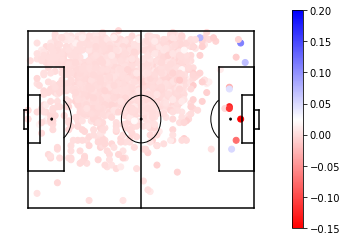

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_tackle = df_tackle.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(a_player.start_x, a_player.start_y, c=a_player.off_def_values, cmap="bwr_r")
plt.clim(-0.15,0.2)
plt.colorbar()
plt.show()

In [ ]:
# good prediction
b_player = A[A['player_id']==167145]

In [ ]:
b_player['off_def_values'] = pd.concat([b_player.iloc[:,-1],b_player.iloc[:,-2],b_player.iloc[:,-3],b_player.iloc[:,-4]]).dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


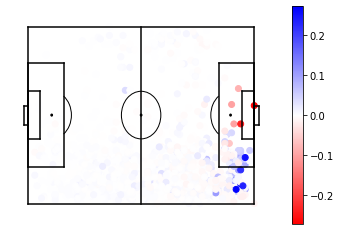

In [ ]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 

# Show actions with high xT Values on top
# df_tackle = df_tackle.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(b_player.start_x, b_player.start_y, c=b_player.off_def_values, cmap="bwr_r")
# plt.clim(-0.1,0.1)
plt.colorbar()
plt.show()